In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA, SparsePCA
from sklearn.cluster import KMeans
import seaborn as sb
from skfuzzy.cluster import cmeans, cmeans_predict

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Set up

In [0]:
## Upload files to colab first
test_data = pd.read_csv('test_data_processed.csv')
train_data = pd.read_csv('train_data_processed.csv')
test_lbl = pd.DataFrame(np.load('test_labels.csv.npy', allow_pickle = True))
train_lbl = pd.DataFrame(np.load('train_labels.csv.npy', allow_pickle = True))

In [0]:
train_data_lbl = pd.concat([train_data, train_lbl], axis = 1)
test_data_lbl = pd.concat([test_data, test_lbl], axis = 1)

train_data_lbl.columns.values[-1] = 'Grade'
test_data_lbl.columns.values[-1] = 'Grade'

In [0]:
def get_accuracy(true_labels, predicted_labels):
    accuracy = 0
    for i in range(len(true_labels)):
        if true_labels[i] == predicted_labels[i]:
            accuracy += 1
    return accuracy/len(true_labels)

# Factor Analysis

## Implement

In [0]:
from sklearn.decomposition import FactorAnalysis

In [0]:
factors = FactorAnalysis(n_components = 100, copy = True, random_state = 15)
fa_train_genes = factors.fit_transform(train_data)
fa_test_genes = factors.transform(test_data)

In [0]:
fa_train = pd.concat([pd.DataFrame(fa_train_genes), pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'Factor {x}' for x in range(1, 102)]
col_titles[-1] = 'Grade'
fa_train.columns = col_titles

fa_train.head()

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15,Factor 16,Factor 17,Factor 18,Factor 19,Factor 20,Factor 21,Factor 22,Factor 23,Factor 24,Factor 25,Factor 26,Factor 27,Factor 28,Factor 29,Factor 30,Factor 31,Factor 32,Factor 33,Factor 34,Factor 35,Factor 36,Factor 37,Factor 38,Factor 39,Factor 40,...,Factor 62,Factor 63,Factor 64,Factor 65,Factor 66,Factor 67,Factor 68,Factor 69,Factor 70,Factor 71,Factor 72,Factor 73,Factor 74,Factor 75,Factor 76,Factor 77,Factor 78,Factor 79,Factor 80,Factor 81,Factor 82,Factor 83,Factor 84,Factor 85,Factor 86,Factor 87,Factor 88,Factor 89,Factor 90,Factor 91,Factor 92,Factor 93,Factor 94,Factor 95,Factor 96,Factor 97,Factor 98,Factor 99,Factor 100,Grade
0,-0.767871,-0.385531,0.115836,2.388345,-0.383484,-0.467369,0.561467,-2.350664,0.418821,3.973832,1.393458,0.537795,-1.186955,0.241165,-2.461988,-0.384562,-0.998326,0.576849,1.282513,0.930144,-1.114290,-0.555400,0.582111,-1.286940,-0.756003,-0.851512,0.500168,-0.302530,-1.151444,1.133120,0.066960,-0.897220,0.713943,0.469944,0.523972,0.829169,-0.259754,0.334612,0.638612,0.837120,...,1.005647,0.667772,-0.687835,-1.093906,0.663421,1.777082,0.403360,1.039033,0.014080,0.939824,-0.798166,-0.012489,-1.292066,-1.089388,0.435321,1.080004,-0.580681,0.193973,-0.696573,0.209947,1.181998,1.581319,0.001383,-0.257150,0.536074,0.311319,0.998915,-0.095354,2.095175,0.483481,0.344128,1.088099,-1.533397,0.904053,-0.544323,-2.056798,1.683718,-0.716638,-0.717733,WHO II
1,0.539117,0.327107,0.852022,-0.332517,-0.004732,0.745542,0.420696,0.905649,-0.866477,1.996034,0.113299,-0.303487,-0.368289,-0.738100,-0.355224,-0.306828,1.579579,-0.624290,-0.943939,-0.140500,-0.371726,1.095854,-0.376742,-0.131920,1.156971,0.019174,0.526034,1.989616,1.022750,0.108739,-0.671821,-0.700076,0.210346,0.400768,-0.186391,-1.013761,1.210125,0.822048,-0.608654,0.412536,...,0.826723,-1.716859,0.398347,0.363219,0.184676,-0.871169,2.087683,-2.375473,4.507718,0.359282,0.120722,-1.184790,-1.131110,0.596269,-1.417280,3.027256,-1.059554,-1.926482,-1.727431,0.575586,-1.020027,-0.035904,-0.445189,0.958550,1.122069,-1.147704,1.916830,0.175825,-1.755637,-0.108784,0.047249,-2.818945,2.346825,-2.154707,-0.128855,-1.230194,0.923162,-1.032598,0.883319,WHO IV
2,-0.914146,-0.218124,-0.782675,1.019773,0.375657,0.519532,0.913710,-1.079186,-0.907992,1.785236,0.315228,0.503691,-0.523415,0.600933,-0.377421,1.659806,0.111216,-0.507630,0.373521,1.309040,2.158432,-0.649656,2.112633,-0.537144,-0.300375,0.304272,-1.232271,-0.303918,-0.466015,-0.998909,0.478124,0.124541,-0.578029,-0.843605,0.154575,0.143870,-0.867417,-0.063425,0.102344,-0.828719,...,0.717151,-0.342601,-1.091383,0.584348,0.084750,-0.297700,0.573446,-0.372649,0.069827,-0.060793,0.694590,1.544628,1.004739,1.563913,-0.019049,0.554957,0.060621,-0.619902,0.381322,0.727567,-0.004370,-0.079075,1.533853,-0.318394,0.100634,-0.178083,-0.220553,0.727758,-1.449127,0.138948,0.788301,0.348312,0.520673,1.320611,-0.702829,-0.331891,-0.452675,-0.783852,-0.367775,WHO II
3,-0.010240,-0.408593,-1.194213,-0.386557,0.003723,-1.695766,-0.276458,0.752302,1.858447,-0.038924,-0.494421,-0.505349,-1.804313,-0.779621,-1.425660,0.286663,0.260123,1.654794,-0.879751,-0.318515,0.663504,-0.573909,-0.654317,0.076841,-1.708391,-1.136160,-0.360114,0.521692,0.938267,-0.223938,-0.616241,-0.095428,-0.039779,1.251148,-0.454566,0.253899,-1.674527,0.542885,-0.161628,-0.132685,...,0.616032,0.414760,-1.054944,-0.810270,0.392132,0.229581,-0.028218,1.044777,0.852055,-0.145478,0.086758,-0.776033,0.473123,0.725105,0.000560,0.576832,-0.573361,-0.678358,1.069336,-0.443874,1.552338,-0.308504,-0.923042,-1.355427,0.088791,0.648256,-0.374091,-0.184248,-0.618326,-0.348110,1.108395,-0.278188,-0.167396,-0.417089,-0.212686,0.996606,0.270324,0.030926,0.107322,WHO II
4,-0.785148,-0.501948,-1.059175,-0.116568,-0.353897,1.322514,1.409249,-0.578670,0.985555,-0.809191,0.794120,0.010905,0.750028,0.052386,0.721943,0.340907,-1

In [0]:
fa_test = pd.concat([pd.DataFrame(fa_test_genes), pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'Factor {x}' for x in range(1, 102)]
col_titles[-1] = 'Grade'
fa_test.columns = col_titles

fa_test.head()

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15,Factor 16,Factor 17,Factor 18,Factor 19,Factor 20,Factor 21,Factor 22,Factor 23,Factor 24,Factor 25,Factor 26,Factor 27,Factor 28,Factor 29,Factor 30,Factor 31,Factor 32,Factor 33,Factor 34,Factor 35,Factor 36,Factor 37,Factor 38,Factor 39,Factor 40,...,Factor 62,Factor 63,Factor 64,Factor 65,Factor 66,Factor 67,Factor 68,Factor 69,Factor 70,Factor 71,Factor 72,Factor 73,Factor 74,Factor 75,Factor 76,Factor 77,Factor 78,Factor 79,Factor 80,Factor 81,Factor 82,Factor 83,Factor 84,Factor 85,Factor 86,Factor 87,Factor 88,Factor 89,Factor 90,Factor 91,Factor 92,Factor 93,Factor 94,Factor 95,Factor 96,Factor 97,Factor 98,Factor 99,Factor 100,Grade
0,-0.293440,2.538886,-0.681511,0.568800,-0.486379,-0.779511,0.319821,1.345924,-0.322250,-1.543843,0.583401,1.232805,1.015854,0.371118,0.726277,-1.793935,0.595507,1.381473,0.146248,-0.627867,1.816056,-1.514732,1.279376,-0.541915,-0.503033,0.677510,-2.602009,0.990409,-1.203804,-1.624827,1.442395,0.003285,-0.806711,-2.130532,-0.922185,1.211113,0.675092,0.930663,-0.030370,0.327993,...,-0.665342,0.181058,1.941298,-2.222015,-0.918663,-1.127551,0.955807,-0.755799,0.019922,3.750914,-0.136771,2.480472,1.341996,1.514001,-1.479348,-2.774186,2.167005,1.845020,-0.688455,-1.843069,-0.394638,2.116943,-0.407150,0.818184,-0.816016,0.064942,0.986092,0.205071,1.520231,-0.337685,-1.020581,-0.319427,-2.768241,0.609570,0.387526,-0.541136,0.203349,0.843216,-0.207020,WHO IV
1,0.324620,0.320905,-0.001379,3.038895,1.789471,0.165920,-2.021166,-1.015364,0.394811,-2.838859,-0.892280,-2.068333,0.330254,0.075194,-0.361176,0.709951,1.915603,-1.290557,-0.529883,1.427255,-0.678221,0.282330,0.281810,0.989438,0.133487,-0.813798,0.024551,1.098699,1.331911,-0.247413,1.089651,1.520390,2.552489,0.659972,0.443962,-1.244502,-0.129881,-0.534517,-0.642364,-0.998721,...,1.131960,-1.190419,0.839269,-0.432565,-0.610082,0.100808,-0.780341,-1.514881,0.213097,0.493203,-1.221235,0.915697,0.513288,0.614149,-0.283112,0.548249,-0.632030,1.084227,0.111545,1.039633,-0.012621,0.441137,0.886790,-0.718504,-1.305706,0.202242,-0.760016,1.094748,-0.414678,0.618624,-0.250067,-0.622165,-0.176920,1.646883,-1.226587,0.509953,0.791242,-0.390949,-0.668325,WHO IV
2,-1.149085,-0.725466,-0.161190,0.100292,-0.135751,0.447639,1.397324,0.732199,0.198626,-0.174552,0.252575,0.098434,-0.201954,1.109297,-0.362313,0.611463,0.252529,-0.328643,0.187580,-0.351575,1.453071,-0.282818,0.086284,-0.131108,-0.075098,0.546457,-0.347318,0.404466,0.175415,-0.935541,0.697452,0.543868,-1.326968,-0.798311,0.110845,-1.492511,-0.294801,0.442117,-0.170704,-1.192030,...,0.263661,-0.183156,-0.440594,0.938233,-0.046092,-0.661072,0.329273,-0.586578,0.515794,-0.039014,0.324517,0.114069,-0.110840,0.209480,-0.006129,-0.641516,0.481802,0.213864,0.377849,0.004588,-0.405983,-0.021938,1.210337,0.795871,-0.848095,0.590221,0.391976,-0.268752,-0.157662,-0.176234,0.056113,-0.188803,-0.267155,0.447616,-0.704491,0.614786,0.263612,0.665294,-0.383083,WHO II
3,-1.171114,0.380817,-0.509393,-0.778159,0.568190,0.228791,0.408663,-1.304155,0.910656,-0.400083,0.108526,-0.780755,-0.610037,-0.624102,-1.455385,0.215294,-1.350310,-0.298107,-0.909006,0.128485,-0.005939,-1.041672,0.504513,0.006271,0.233487,0.173494,-0.586015,0.290266,-0.825464,0.271224,0.395707,-0.256013,0.119838,-0.852398,0.395025,-0.068228,-0.552795,-0.170839,0.146349,-0.367205,...,0.193013,0.171287,-0.204903,0.103397,-0.068474,0.006126,-0.111813,0.439918,0.409053,0.541837,-0.766683,-0.208610,0.150967,0.201722,0.477650,0.570681,-0.450848,-0.179122,-0.210300,-0.046033,-0.044556,-0.177725,-0.080124,-0.229516,0.140195,0.034021,0.122877,0.360044,0.347633,0.132775,0.123528,0.107490,0.339592,-0.311282,0.034030,-0.348044,0.098321,-0.154382,-0.752504,WHO II
4,-0.999554,0.257892,-0.399793,-0.399037,0.653508,-0.356721,0.683092,-0.835377,2.041559,-0.493432,0.701805,-0.706554,-1.159834,-0.390775,-0.939134,0.467496,-0.0

## Plot factors

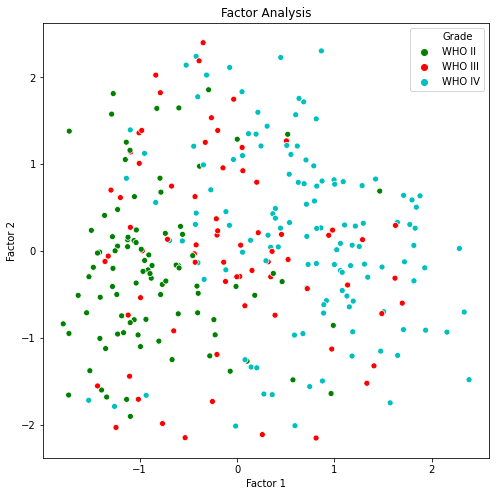

In [0]:
x = fa_train['Factor 1']
y = fa_train['Factor 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = fa_train['Grade'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("Factor Analysis")
plt.show()

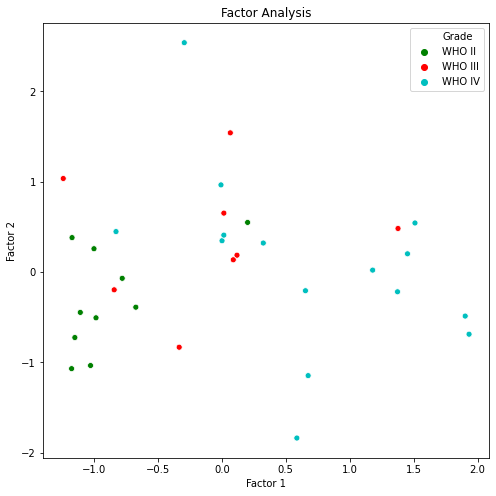

In [0]:
x = fa_test['Factor 1']
y = fa_test['Factor 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = fa_test['Grade'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("Factor Analysis")
plt.show()

## Identify important genes

In [0]:
### Find the 100 top features for top PCs
all_weights = pd.DataFrame(factors.components_)
col_names = train_data.columns.values
all_weights.columns = col_names
all_weights.head()

,0,2,4,7,15,28,31,32,33,38,39,42,43,44,45,47,50,55,56,61,62,64,65,66,67,68,69,70,78,79,82,86,88,89,96,98,102,103,106,107,...,24150,24155,24156,24160,24163,24164,24165,24168,24184,24191,24202,24203,24207,24214,24215,24220,24223,24224,24237,24244,24253,24255,24256,24260,24261,24271,24272,24273,24277,24283,24285,24288,24291,24296,24308,24309,24313,24316,24317,24323
0,0.394535,0.686760,-0.793877,0.360274,-0.120240,-1.073860,-0.928904,0.008527,0.309969,-0.463421,-0.404720,0.305538,0.390072,0.312580,0.123763,-0.309546,0.699998,0.091294,0.478405,2.151520,-0.041044,0.141447,0.045779,-0.053478,-1.502464,-0.110747,0.507746,-0.282826,-0.516769,-0.514027,-0.285012,-0.399564,-0.483148,-0.493682,-0.459505,-0.061641,-0.559857,-0.186352,0.711557,-0.117918,...,-0.318457,-0.112810,-0.131265,-0.343320,-0.442717,-0.208567,-0.479205,0.117654,-0.324475,-0.334541,0.145330,-0.287848,-0.814989,0.248605,0.209345,0.042402,-0.371714,-0.315404,-0.488269,-0.083497,-0.181307,-0.226476,0.295612,0.010933,-0.813638,0.410216,-0.198011,-0.288114,0.543581,-0.150288,-0.628002,0.062737,-0.174492,-0.538345,0.232680,-0.482441,0.144702,0.342350,0.463540,0.824403
1,-0.365092,-0.308476,-0.506988,-0.464917,-0.324035,-0.850296,-0.035858,0.062682,-0.059075,-0.308486,-0.677046,-0.722874,-0.567031,-0.443744,-0.549277,-0.401505,0.088854,-0.310717,0.089248,-0.279759,-0.006797,-0.376615,-0.055678,-0.093861,-0.305259,-0.378854,-0.081368,-0.339470,-0.209851,-0.542684,-0.473866,-1.059023,-0.285787,0.026818,-0.189734,0.066158,-0.199383,-0.564098,-0.466285,-0.231032,...,0.378543,0.689172,0.459955,0.731361,0.296188,0.423435,0.397988,-0.044376,-0.045264,0.095649,0.037665,0.061768,0.237743,-0.423039,0.199891,-0.092132,-0.164534,0.362356,0.026411,0.393754,0.166431,0.387866,0.501716,0.612015,0.127472,-0.286495,0.055565,0.118039,-0.523248,-0.076079,-0.046152,-0.234878,-0.205588,0.400540,0.367268,0.119743,-0.083416,0.311430,0.779608,0.064631
2,0.053511,-0.214387,-0.497603,0.144263,0.471806,-0.298401,-0.170068,0.070859,-0.415713,-0.225586,-0.109313,0.573530,-0.137415,0.057423,-0.216757,-0.057985,-0.042092,0.413433,-0.027255,0.416236,-0.378010,-0.275605,-0.060572,-0.255059,-0.077373,-0.128937,-0.135708,0.425625,-0.222800,0.854402,-0.031826,0.235360,0.063446,-0.035069,-0.103102,0.085296,-0.293820,0.346790,-0.416195,-0.867555,...,-0.072683,0.095240,0.021864,-0.053968,-0.094921,-0.103319,-0.070674,0.143013,-0.060735,-0.039310,-0.020146,0.039400,-0.072841,-0.549922,-0.164976,-0.078914,-0.269970,-0.110258,-0.176039,-0.000604,-0.070783,-0.012414,0.003029,-0.122696,0.405555,-0.156949,-0.095267,-0.096055,0.217537,-0.095917,-0.195742,-0.084611,0.062812,-0.254547,0.058194,-0.213946,0.005693,0.253435,0.245738,0.210490
3,0.375425,-0.201619,0.229096,0.030218,0.053694,0.157241,0.078677,0.432345,-0.180992,0.334877,0.279586,-0.049308,-0.228047,0.370557,-0.238934,0.221651,0.313943,0.021352,0.128731,0.268483,-0.108241,0.369930,0.402155,0.431709,0.593654,-0.236625,0.180729,-0.309003,-0.055278,-0.022848,0.397324,-0.111221,0.322530,0.017234,-0.155658,-0.430064,0.023653,0.159534,0.131136,-0.295012,...,-0.074272,-0.350022,0.319413,0.107344,-0.114033,0.251350,0.182713,0.154355,-0.113162,0.260760,-0.090089,0.001279,-0.106950,-0.034895,-0.113645,-0.137721,-0.010671,0.024138,-0.033835,-0.158404,0.160279,-0.101910,0.394061,-0.003358,0.206732,-0.123152,-0.133733,-0.259931,0.207891,0.211978,0.675565,0.005485,0.207299,-0.349961,0.158213,-0.030908,0.534420,0.086908,0.147582,0.113144
4,-0.194167,-0.216237,0.942580,-0.175547,-0.039104,-0.789547,0.391960,0.069670,0.148736,0.138910,-0.430728,0.104015,-0.094954,0.194195,-0.095556,0.103591,-0.100789,0.019701,-0.084990,0.291680,-0.004978,0.237814,0.406409,0.423284,0.031007,0.275728,0.026385,0.477183,0.130073,0.120325,0.360704,-0.563221,0.081320,0.128988,-0.307715,0.084985,-0.223643,0.251542,-0.219176,-0.048057,...,-0.107376,-0.234130,-0.220133,-0.385818,-0.134099,-0.269876,-0.213664,-0.108191,0.196692,-0.230299,-0.043239,-0.016933,-0.401253,-0.137849,-0.027067,-0.009740,-0.367276

In [0]:
fa_important_genes = []
temp = pd.DataFrame(np.abs(all_weights)).T
for i in range(50):
    fa_important_genes.extend(temp.nlargest(100, i).index.values)
fa_important_genes = np.unique(fa_important_genes)

In [0]:
# Make new training and testing sets with these genes
fa_important_train = train_data[fa_important_genes]
fa_important_test = test_data[fa_important_genes]
fa_important_train.head()

,10006,10013,10042,10057,10070,10101,10108,10124,10127,10129,1013,10130,10136,1016,10176,10190,10191,10197,10200,10231,10257,10282,10286,10291,10293,10314,10329,10336,10340,10344,10386,10396,10405,10410,10414,10422,10426,10457,10463,10465,...,9644,9667,9687,9689,9744,9745,9746,9754,977,9817,9821,9822,9834,9837,9841,9843,9846,9853,9854,9855,9856,9863,9867,9870,9871,9876,9877,9882,9888,9891,9895,9897,9901,9903,9906,9930,9948,9955,9963,9976
0,1.774303,0.792760,2.385850,1.204737,0.875901,1.158044,0.638037,4.442473,3.391916,2.034238,2.134118,0.943540,3.379758,5.602296,0.336381,3.197829,0.852631,8.562009,-0.767955,-0.159146,2.049668,-2.182993,0.080042,-0.045489,4.166325,4.788934,1.810983,2.134118,1.711016,4.398961,1.417911,0.986932,0.898801,-3.767955,1.417911,-0.389444,-0.630452,-0.045489,3.564753,3.681606,...,1.186241,-0.231902,1.080042,-0.697566,1.353060,0.997579,5.048388,6.448791,2.586074,2.008149,0.954511,1.915741,2.460863,-0.089883,5.576784,1.786634,0.954511,0.213897,1.417911,5.611856,6.871566,0.624362,5.026461,0.943540,2.904470,3.519295,1.638037,2.298134,1.561168,2.029058,5.612722,0.099941,7.131855,0.039400,-0.256993,3.918545,-1.630452,-1.135687,4.937331,3.393932
1,1.484901,0.756814,1.266067,-0.525825,-1.733933,3.334382,0.302903,4.252791,2.308952,1.000543,2.734515,0.557833,4.449745,1.958832,3.231453,0.474175,-1.269986,1.597910,-3.132483,-1.733933,-2.891475,-0.269986,-3.006952,-0.234362,4.468782,2.062722,-0.288134,1.895926,3.681881,3.736761,-1.784559,-0.614634,-1.784559,-3.269986,-2.132483,-0.116181,1.838538,0.000000,4.176270,2.547637,...,0.474175,-1.006952,-0.132483,-1.948058,0.408086,0.350600,2.037442,6.545557,0.808965,-0.288134,-2.006952,2.218657,1.842714,0.597910,5.977704,1.506118,-1.948058,-1.100061,0.266067,5.535758,3.071644,-2.199597,2.208986,-0.504452,1.542512,2.698104,0.867517,1.030137,0.899939,0.547637,2.438753,-0.288134,5.451455,0.385366,0.302903,1.587995,-0.022059,3.918850,2.471481,2.929686
2,1.722956,0.753983,1.985119,0.300932,0.647855,1.490949,0.023823,6.180962,5.353369,3.184287,-0.319479,-2.298105,5.635065,4.254677,0.545169,4.752704,-0.800606,5.623561,-0.028016,-1.578213,-0.657648,-0.063640,0.408848,-1.800606,4.145813,4.138974,2.965371,1.913640,1.814104,4.443362,-2.926137,2.161326,2.614432,0.421787,-2.926137,-1.256285,-2.926137,-1.298105,1.647855,4.243788,...,0.459922,0.355899,1.006749,0.214345,-0.478678,0.899834,4.569355,6.269515,1.774303,0.199394,1.369319,1.428213,3.325238,0.199394,3.982938,-1.298105,-1.800606,-0.277044,2.487876,6.191389,6.202678,-1.862006,4.590280,0.871820,1.799307,2.503175,1.362625,1.895203,-0.341174,0.794341,4.525824,-1.741712,5.663259,-1.100166,-0.478678,1.032284,0.591712,3.349141,3.699240,1.769250
3,0.496771,1.487249,1.081734,0.666696,1.784119,2.134540,0.552625,5.439286,3.478864,3.040007,1.870896,1.597572,4.477663,3.113030,1.062625,3.322985,0.203040,6.859292,0.969943,-0.685067,1.113030,-1.465754,-0.078731,0.833806,2.732660,2.140628,1.372965,0.131487,1.649723,1.615166,2.579761,3.942331,1.173656,0.803433,0.615166,0.030204,-1.465754,1.524968,1.167707,2.628222,...,0.935344,-0.918266,0.623883,0.003731,1.732660,1.423770,3.280890,6.562436,1.700055,-0.151243,1.069023,2.052975,5.032661,-0.918266,1.463163,-0.393604,1.795738,-0.181301,2.119209,5.432789,3.584234,0.069023,4.615712,1.472846,1.803433,2.125361,1.487249,3.244611,1.243197,0.780225,2.791876,1.293238,4.961371,0.398591,-0.728788,0.534246,-0.685067,4.143662,2.545760,1.287763
4,-0.342156,2.211946,-0.071508,-0.109982,1.196264,1.046887,-1.412545,4.553239,4.379269,3.746654,0.474980,0.448749,4.557849,3.387924,2.569308,7.113367,-3.512081,4.984345,-0.090617,-0.190152,0.000000,-0.512081,0.513455,-1.860004,3.957852,2.374052,1.628932,1.374052,2.590458,3.834117,-1.071508,3.684785,4.385333,-0.795873,-1.734473,-0.149510,-2.319435,-2.618996,2.276754,5.856738,...,-0.512081,0.563208,0.550929,1.081444,-0.436792,2.200201,3.939131,6.253265,3.186376,-1.675579,-1.149510,1.860474,2.799506,-0.342156,2.954360,-3.997507,0.928492,0.295274,3.372308,4.649951,7.126743,-0.2

# PCA

## Scale

In [0]:
# Scale to mean = 0, sd = 1
scaler = StandardScaler()
train_genes_scaled = scaler.fit_transform(train_data)
test_genes_scaled = scaler.transform(test_data)

## Determine optimal number of components

In [13]:
pca = PCA(150)
pca.fit(train_genes_scaled)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0, 0.5, 'Cumulative Explained Variance')

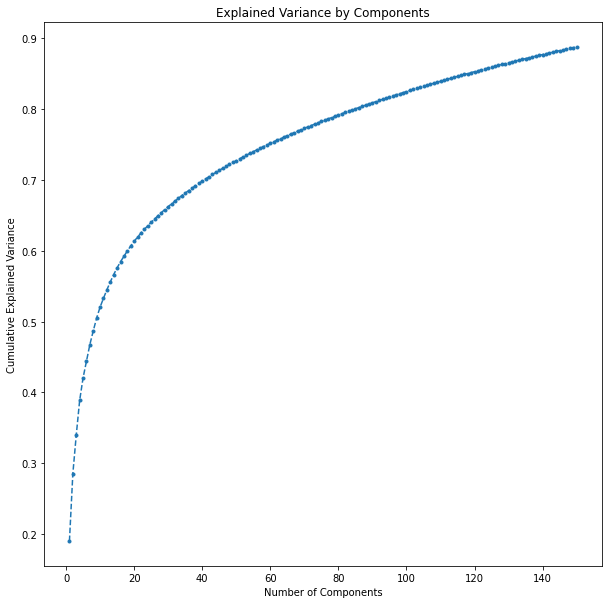

In [14]:
plt.figure(figsize = (10,10))
plt.plot(range(1,151), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--', markersize = 3)
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [15]:
pca.explained_variance_ratio_.cumsum()[100]

0.8258795945623919

We determined that 83% of the variance, with 100 Components is a good variance/complexity balance.

## Implement

In [0]:
pca = PCA(100)
pca_train_genes = pca.fit_transform(train_genes_scaled)
pca_test_genes = pca.transform(test_genes_scaled)

In [0]:
pca_test = pd.concat([pd.DataFrame(pca_test_genes), pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, 102)]
col_titles[-1] = 'Grade'
pca_test.columns = col_titles

pca_test.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,...,PC 62,PC 63,PC 64,PC 65,PC 66,PC 67,PC 68,PC 69,PC 70,PC 71,PC 72,PC 73,PC 74,PC 75,PC 76,PC 77,PC 78,PC 79,PC 80,PC 81,PC 82,PC 83,PC 84,PC 85,PC 86,PC 87,PC 88,PC 89,PC 90,PC 91,PC 92,PC 93,PC 94,PC 95,PC 96,PC 97,PC 98,PC 99,PC 100,Grade
0,-17.018512,-76.678514,15.561575,3.062704,-7.722779,-8.775850,-4.664851,23.154748,0.509266,7.973678,-3.623022,5.866161,-4.550189,12.146785,-1.392219,-18.246023,6.896821,0.944526,11.384552,6.991666,12.338170,11.705946,0.708997,2.287630,-13.341123,6.993175,-10.261956,8.248515,-2.400219,-1.427749,-4.416294,1.179152,9.364390,11.176043,8.197916,0.347621,-5.342266,6.541101,9.915753,-1.131762,...,10.899702,-1.568144,0.758518,1.980277,4.713281,4.851716,-5.931367,-4.419590,-1.302903,-5.505166,1.024360,-2.717740,-8.427008,8.541599,-1.745657,8.284553,-3.434737,-9.377509,-9.517866,8.774370,-2.559249,0.977984,-0.086417,1.912350,-2.874511,0.575641,-1.678528,-6.968492,3.596621,0.387272,-1.224354,4.477667,-4.144775,-2.552277,-1.567604,-1.138090,-3.252450,6.836434,0.187049,WHO IV
1,10.671509,6.637014,61.410853,35.650647,23.106033,-2.143400,-25.585916,-1.896293,-3.161299,29.643057,20.772200,-8.631180,10.108813,-4.321810,-1.290577,12.302224,5.609744,10.251688,-11.286736,8.424100,-7.446585,0.833440,6.362327,-1.295788,-0.538751,-2.789574,-0.909597,3.487231,13.054560,9.224215,-0.364302,-0.802777,9.328509,-10.093221,-1.792623,-4.062803,1.789310,-1.835673,0.649405,4.240894,...,5.582312,2.205854,-2.969950,-0.531894,2.501960,-2.282490,-0.616521,-5.275008,2.981498,-4.601314,0.469132,-3.394217,5.113290,2.023322,-1.051664,-0.371899,3.816695,-0.850683,0.229438,1.325637,-0.948086,0.219822,-5.783033,2.556722,-1.987221,-2.458668,1.409523,-2.752795,4.696642,-4.087550,2.507288,5.316961,1.223567,1.236127,-1.043795,-2.984997,-2.397036,-3.314017,0.924540,WHO IV
2,-47.478944,19.938839,0.775281,-5.393339,1.060002,-1.258285,18.845099,10.749346,8.432701,-1.510634,2.498965,2.215257,-3.571031,5.632856,3.777480,3.711318,-0.018851,-0.569086,-3.031431,4.688648,9.404736,-0.974123,-0.790132,0.615564,-4.147071,8.098679,1.431979,2.792576,-0.381679,-5.142564,-0.689776,2.999639,7.062379,6.517923,-4.294524,-4.471987,2.412686,-1.969096,-0.674309,5.679641,...,-0.551585,1.325819,1.072653,1.519531,2.222347,-3.172628,-0.909233,3.724285,-0.655441,2.266533,1.877241,-0.885325,1.589409,0.469133,2.633640,1.337861,2.052690,-1.653839,-2.518615,0.860467,-0.412610,3.996704,2.738325,-1.375810,-0.843922,0.995765,-3.157285,-2.557065,0.082646,-0.126904,0.214093,0.752416,1.038075,-1.575182,1.096215,2.445567,-0.557107,-0.759410,1.535533,WHO II
3,-46.293701,-8.338783,-8.556460,-11.787487,7.931985,-12.844711,6.540826,-18.449559,8.280567,2.268379,6.155999,6.697884,12.438830,-3.760121,3.321463,1.446364,-10.134700,-5.682686,-2.644134,3.815761,-2.071600,7.834877,-0.859072,-0.570158,-3.168933,-0.344856,-2.032103,3.334026,-3.248693,3.036791,3.179862,-0.565128,0.365566,3.902595,-1.120040,-1.179762,-0.556647,1.268869,-1.564766,0.533795,...,0.332806,2.495933,-0.372766,-0.927606,0.403050,0.726465,-0.684169,0.750278,-1.785646,-0.733537,3.459306,-0.805410,1.273227,0.250722,1.422381,1.070423,1.603022,0.121284,0.918156,-2.341091,0.902276,-2.473149,0.797977,0.554601,2.005249,0.440211,1.854731,-0.984441,0.483813,1.189386,-0.137946,1.147722,-1.115155,0.602337,-0.278470,2.430697,-0.163343,-0.634093,-0.515978,WHO II
4,-39.708933,-1.918164,-1.080752,-5.932954,7.909142,-28.034355,4.023443,-14.541399,18.140554,-0.283957,4.532071,6.897541,6.876370,-6.633463,1.865288,2.967301,-10.198049,1.619586,-1.488168,2.531958,4.955702,6.443589,-2.912846,-0.136850,-4.473982,4.336008,-2.179830,0.619619,-1.113891,-1.565422,-3.957438,-4.143265,-1.543306,0.800459,-1.424751,-0.076890,0.131354,-0.574398,1.389086,-0.054548,...,0.057689,1.942085,1.935728,-0.081159,0.762961,1.8

In [0]:
pca_train = pd.concat([pd.DataFrame(pca_train_genes), pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, 102)]
col_titles[-1] = 'Grade'
pca_train.columns = col_titles

pca_train.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,...,PC 62,PC 63,PC 64,PC 65,PC 66,PC 67,PC 68,PC 69,PC 70,PC 71,PC 72,PC 73,PC 74,PC 75,PC 76,PC 77,PC 78,PC 79,PC 80,PC 81,PC 82,PC 83,PC 84,PC 85,PC 86,PC 87,PC 88,PC 89,PC 90,PC 91,PC 92,PC 93,PC 94,PC 95,PC 96,PC 97,PC 98,PC 99,PC 100,Grade
0,-33.435050,22.490684,38.097767,33.143324,-17.619483,-3.171199,20.422858,-43.082454,-8.627830,-40.189536,-5.465451,12.660921,6.473937,1.850705,17.776311,3.827960,5.569363,-7.038127,5.134618,-1.663095,-6.170663,4.012359,-1.837601,9.008581,6.178398,-7.795723,-4.336150,1.467781,-4.227110,3.907333,3.873936,-5.471964,-7.335916,-0.225879,-0.498414,2.383156,-2.361388,0.037723,-0.908430,-3.256367,...,1.472668,2.803386,2.272098,-6.949592,-4.367347,3.341168,1.947714,0.368989,4.152339,-1.243948,6.176505,0.441244,3.876104,-1.597739,-1.460799,2.279836,3.711773,-4.189875,-1.905389,-0.335042,4.345799,0.330479,-0.276266,-2.592846,-1.454869,5.041591,5.734734,0.123303,0.652437,4.450397,4.326512,-0.874418,-1.986951,-2.692382,-1.379689,1.034875,-3.335310,3.982891,-3.748216,WHO II
1,23.423648,-7.423201,-17.507606,8.792664,6.431287,18.670136,9.897008,4.258857,-5.588947,-21.095098,-0.322124,0.209306,0.053304,-8.668610,0.180721,-4.388219,-2.996144,16.387477,-4.154526,-6.628741,-1.232861,-4.223455,5.966935,2.511681,-3.733841,1.644175,11.705988,4.247669,6.254536,2.301708,4.047875,-1.748213,-5.792585,-3.768745,6.325283,-4.410534,2.398020,-8.268529,10.467071,-0.573543,...,16.601840,-2.924163,8.960608,3.823409,-1.243221,-7.467617,-7.572804,10.589349,0.772206,-11.084777,2.638333,3.811274,4.791859,7.358702,1.595207,-7.155816,6.898175,-1.040545,-0.265182,-8.283871,4.145279,0.835572,6.715944,-3.471030,11.431920,-3.422275,3.884578,-0.331670,4.339098,-4.573922,-1.594635,-8.345405,-3.611264,5.372493,0.348840,1.586277,3.331050,-0.243719,5.853999,WHO IV
2,-40.110197,7.114937,26.472899,-2.714790,2.348762,10.846683,24.951134,-15.586976,-12.524094,-13.831167,-8.258101,3.049686,-0.538163,4.341180,2.305371,13.008403,2.597718,-4.470039,-2.298502,17.885348,8.249679,7.956260,7.983512,4.190690,-6.485299,6.298476,-5.140809,0.337568,-6.390877,-3.273234,-3.172202,2.805812,4.912493,5.161848,-1.987693,-0.899333,-5.078180,-0.617562,-0.176509,2.137058,...,-1.853073,4.914696,3.133128,3.798334,3.028337,-0.084716,-0.897116,0.959289,-2.269742,0.740839,-1.123870,-4.365821,-1.742024,-2.435739,3.307302,-1.834632,6.475913,1.375272,0.094449,0.035361,-2.306720,-2.782514,-2.975034,-5.741852,-2.000292,-1.551768,-0.109299,-1.936931,4.388676,-3.977612,1.910316,3.031441,-3.236150,-0.829958,0.282971,1.168424,3.326105,0.266835,1.991631,WHO II
3,-4.322818,5.918644,3.995310,-19.628973,-7.751300,-32.174292,-13.651544,2.071658,15.121449,-6.344336,-5.886292,0.644285,14.280968,-13.589546,9.365648,4.461883,-8.266585,2.415868,8.723480,0.640381,6.564455,2.067038,-4.285749,-0.938584,4.231604,1.755127,-3.522140,1.826236,7.630807,-3.197037,-6.149750,0.346512,-2.897506,-3.820346,-1.361873,-4.142842,-7.828329,-2.262813,3.168992,5.944592,...,0.914863,2.550852,-0.166442,-1.226370,-1.065782,6.247316,2.170066,4.669627,-2.872206,0.270311,-1.223580,-2.399002,0.008102,-0.680455,-5.269030,-1.359116,-2.503650,-0.514182,3.798668,-5.069770,2.514992,-2.986627,1.182284,2.554844,-1.019743,-1.606059,1.312819,0.347434,-2.273195,0.749121,-2.407184,4.828789,-1.261966,1.076348,-0.596083,-3.169724,-2.342887,2.049022,3.854297,WHO II
4,-32.589107,10.796249,10.908327,-21.124218,-3.384025,1.144437,17.386578,-5.382837,19.263953,8.948880,2.557172,6.291258,-4.473211,8.318475,-10.763676,0.585800,-2.121526,-7.917563,-0.147576,-3.251826,-7.029230,-4.653908,1.834073,1.242064,1.823627,-0.874835,-4.370777,-1.894273,7.025319,-4.739808,4.005834,5.864892,3.790564,7.195704,-0.669111,0.070380,-2.022720,0.079781,5.210897,-1.290279,...,4.859572,-2.062645,1.687858,-1.904295,-1.1399

## Identify important genes

In [0]:
### Find the 100 top features for top PCs
all_weights = pd.DataFrame(pca.components_)
col_names = train_data.columns.values
all_weights.columns = col_names
all_weights.head()

,0,2,4,7,15,28,31,32,33,38,39,42,43,44,45,47,50,55,56,61,62,64,65,66,67,68,69,70,78,79,82,86,88,89,96,98,102,103,106,107,...,24150,24155,24156,24160,24163,24164,24165,24168,24184,24191,24202,24203,24207,24214,24215,24220,24223,24224,24237,24244,24253,24255,24256,24260,24261,24271,24272,24273,24277,24283,24285,24288,24291,24296,24308,24309,24313,24316,24317,24323
0,0.008215,0.016406,-0.010689,0.009826,-0.002291,-0.014719,-0.019281,0.000038,0.007378,-0.010204,-0.008444,0.006166,0.006864,0.007682,0.002823,-0.007670,0.013360,0.003646,0.015329,0.020299,-0.002254,0.003059,0.000745,-0.001481,-0.017192,-0.002346,0.016853,-0.004423,-0.011929,-0.007855,-0.005333,-0.004929,-0.014132,-0.012180,-0.014556,-0.001615,-0.016073,-0.004268,0.015283,-0.002419,...,-0.009631,-0.002611,-0.004240,-0.006697,-0.015077,-0.007282,-0.015820,0.003599,-0.010264,-0.008822,0.004549,-0.009973,-0.013086,0.003135,0.006203,0.001225,-0.006325,-0.010789,-0.014232,-0.002744,-0.006257,-0.007014,0.006986,-0.000561,-0.010456,0.014137,-0.004011,-0.007450,0.010110,-0.003341,-0.009956,0.001303,-0.005647,-0.012069,0.007486,-0.014391,0.002447,0.011021,0.008919,0.019882
1,0.010133,0.007019,0.010700,0.016851,0.013382,0.014902,0.002296,-0.000596,-0.000456,0.009795,0.019583,0.019373,0.012362,0.016415,0.013536,0.015230,-0.002216,0.014717,-0.005440,0.004128,-0.002641,0.012619,0.002804,0.003632,0.006611,0.011924,0.002164,0.012195,0.006557,0.017826,0.015282,0.020667,0.013959,0.000432,0.007279,-0.003463,0.005683,0.025088,0.010539,0.001298,...,-0.015841,-0.021275,-0.017192,-0.018330,-0.014529,-0.019302,-0.017630,0.002287,0.002258,-0.003214,-0.001341,-0.002426,-0.005430,0.005922,-0.010857,0.002837,0.002411,-0.016669,-0.000413,-0.016175,-0.007584,-0.015666,-0.017689,-0.025847,-0.000683,0.011098,-0.001436,-0.005099,0.014662,0.002980,0.001662,0.005600,0.011218,-0.012990,-0.018025,-0.005489,0.003824,-0.013364,-0.021723,-0.002692
2,0.010485,-0.001818,0.014249,-0.002143,-0.010963,0.004033,0.005557,0.013898,0.005769,0.016484,0.009433,-0.008153,-0.002725,0.014941,-0.002445,0.010128,0.011254,-0.010650,0.008396,0.002557,0.006664,0.022361,0.014301,0.020399,0.009900,-0.003377,0.015421,-0.015055,0.002562,-0.015580,0.014719,-0.007490,0.011575,0.001479,-0.007099,-0.024822,0.006416,-0.001621,0.013488,0.006309,...,-0.003561,-0.015788,0.011181,0.001637,-0.005160,0.012062,0.007310,0.001669,-0.003128,0.009171,-0.003511,-0.002051,-0.003657,0.006852,-0.000111,-0.002737,0.002568,0.003324,0.003294,-0.007634,0.008616,-0.005291,0.014703,0.001155,-0.002678,0.000754,-0.001848,-0.008510,0.004562,0.009544,0.017944,0.001994,0.009198,-0.006928,0.005139,0.003710,0.017180,-0.004890,-0.002584,-0.000243
3,0.006638,-0.016023,-0.010486,0.002594,0.017510,-0.006042,-0.004240,0.012981,-0.022607,-0.002218,-0.000903,0.011227,-0.010482,0.008432,-0.016430,0.001288,0.006825,0.015273,0.002928,0.007061,-0.024279,-0.004608,0.004649,-0.001154,0.006353,-0.014659,-0.003452,0.004256,-0.010644,0.022129,0.005077,-0.000631,0.010525,0.000565,-0.010086,-0.009876,-0.013365,0.013516,-0.015186,-0.027227,...,-0.001037,0.001834,0.016328,0.007060,-0.003674,0.009537,0.008789,0.011210,-0.007515,0.008229,-0.001052,0.004803,0.000477,-0.014624,-0.009885,-0.007484,-0.006846,-0.000814,-0.008254,0.000735,0.005011,0.003413,0.016315,0.001078,0.013050,-0.017458,-0.006079,-0.010839,0.007073,0.000881,0.006720,-0.003362,0.008552,-0.012437,0.013011,-0.008160,0.011702,0.020079,0.016825,0.009623
4,-0.009823,-0.016222,0.026893,-0.013655,-0.001620,-0.026712,0.020842,0.003620,0.005219,-0.002409,-0.020375,0.007958,-0.007485,0.002511,-0.003382,0.003071,-0.007164,0.005550,-0.010132,0.002402,-0.005051,0.006252,0.018155,0.016187,-0.002965,0.013226,-0.001752,0.029817,0.008160,0.004919,0.011740,-0.016480,0.002641,0.005293,-0.020545,0.011760,-0.019199,0.016120,-0.016093,-0.009784,...,-0.001732,-0.002173,-0.010615,-0.010737,-0.007133,-0.013909,-0.013819,-0.005588,0.015991,-0.012758,-0.005936,0.003163,-0.019795,-0.007802,0.001254,-0.001929,-0.017858,0.008798,0.012538,-0.000179

In [0]:
important_genes = []
temp = pd.DataFrame(np.abs(all_weights)).T
for i in range(50):
    important_genes.extend(temp.nlargest(100, i).index.values)
important_genes = np.unique(important_genes)

In [0]:
# Make new training and testing sets with these genes
important_train = train_data[important_genes]
important_test = test_data[important_genes]

# Sparse (L1 Regularized) PCA

## Implement

In [0]:
from sklearn.decomposition import MiniBatchSparsePCA

In [0]:
n = 2
sparse_pca = MiniBatchSparsePCA(n_components = n).fit(train_genes_scaled)
sparse_train_genes = sparse_pca.transform(train_genes_scaled)
sparse_test_genes = sparse_pca.transform(test_genes_scaled)

In [0]:
sparse_test = pd.concat([pd.DataFrame(sparse_test_genes), pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, n+2)]
col_titles[-1] = 'Grade'
sparse_test.columns = col_titles

sparse_test.head()

,PC 1,PC 2,Grade
0,37.152352,-70.491281,WHO IV
1,8.400580,7.307506,WHO IV
2,-47.912547,-11.787691,WHO II
3,-28.936388,-34.764760,WHO II
4,-27.600268,-26.016465,WHO II


In [0]:
sparse_train = pd.concat([pd.DataFrame(sparse_train_genes), pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, n+2)]
col_titles[-1] = 'Grade'
sparse_train.columns = col_titles

sparse_train.head()

,PC 1,PC 2,Grade
0,-36.592388,-3.616241,WHO II
1,21.645254,8.726605,WHO IV
2,-32.763010,-18.839944,WHO II
3,-7.433758,2.223518,WHO II
4,-30.657532,-10.679793,WHO II


## Plot components

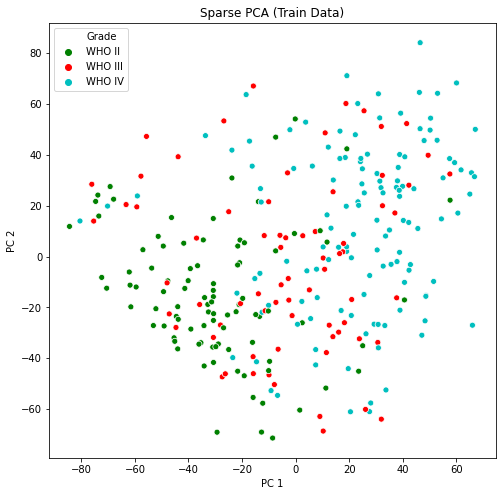

In [0]:
x = sparse_train['PC 1']
y = sparse_train['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = sparse_train['Grade'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("Sparse PCA (Train Data)")
plt.show()

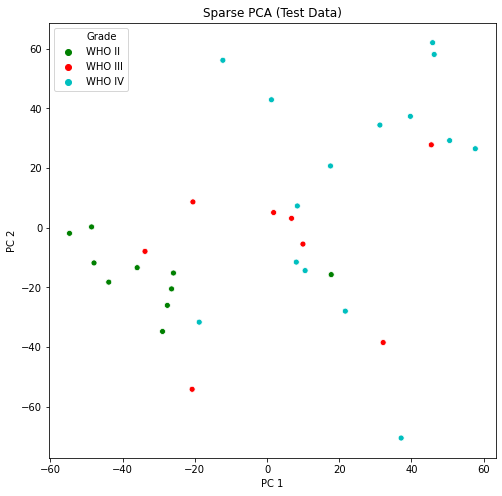

In [0]:
x = sparse_test['PC 1']
y = sparse_test['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = sparse_test['Grade'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("Sparse PCA (Test Data)")
plt.show()

## Identify important genes

In [0]:
### Find the 100 top features for top PCs
all_weights = pd.DataFrame(sparse_pca.components_)
col_names = train_data.columns.values
all_weights.columns = col_names
all_weights.head()

,0,2,4,7,15,28,31,32,33,38,39,42,43,44,45,47,50,55,56,61,62,64,65,66,67,68,69,70,78,79,82,86,88,89,96,98,102,103,106,107,...,24150,24155,24156,24160,24163,24164,24165,24168,24184,24191,24202,24203,24207,24214,24215,24220,24223,24224,24237,24244,24253,24255,24256,24260,24261,24271,24272,24273,24277,24283,24285,24288,24291,24296,24308,24309,24313,24316,24317,24323
0,0.000000,0.007725,-0.014357,-0.000147,-0.008364,-0.021933,-0.016821,0.0,0.005862,-0.013287,-0.018831,-0.005704,-0.000036,-0.000806,-0.004558,-0.014586,0.012985,-0.004247,0.016764,0.014667,0.000000,-0.002030,0.0,-0.000358,-0.017769,-0.007883,0.013092,-0.010433,-0.014676,-0.017020,-0.011300,-0.017503,-0.018995,-0.009669,-0.018736,0.000000,-0.017552,-0.018557,0.004558,-0.001922,...,0.000000,0.008374,0.005151,0.003442,-0.003239,0.003797,-0.000349,0.000340,-0.009757,-0.004549,0.00318,-0.006653,-0.007516,0.000000,0.010603,0.00000,-0.006219,0.000000,-0.010492,0.005887,0.000000,0.001118,0.016201,0.014157,-0.007425,0.002841,-0.001341,-0.002062,0.000000,-0.002442,-0.007797,0.000000,-0.009559,-0.00080,0.017515,-0.008219,0.000000,0.01544,0.020130,0.019186
1,0.013042,0.017970,0.000000,0.020034,0.007763,0.001195,-0.011117,0.0,0.001729,0.000000,0.009820,0.018267,0.013324,0.016278,0.011564,0.005692,0.005185,0.013822,0.004179,0.016100,-0.002267,0.008933,0.0,0.000000,-0.005299,0.005997,0.012257,0.004980,-0.000098,0.007434,0.005379,0.013920,0.000000,-0.007636,-0.001034,-0.001793,-0.004148,0.016554,0.019980,0.000000,...,-0.018424,-0.017030,-0.015062,-0.017914,-0.021594,-0.018253,-0.025498,0.003151,-0.004448,-0.007388,0.00000,-0.007052,-0.012409,0.005996,-0.002578,0.00047,-0.000350,-0.020604,-0.009931,-0.013705,-0.009419,-0.016744,-0.007969,-0.019840,-0.006550,0.018783,-0.003637,-0.008718,0.017211,0.000000,-0.005095,0.002528,0.002498,-0.01998,-0.007794,-0.013869,0.001902,0.00000,-0.009333,0.010971


In [0]:
sparse_important_genes = []
temp = pd.DataFrame(np.abs(all_weights)).T
for i in range(n):
    sparse_important_genes.extend(temp.nlargest(100, i).index.values)
sparse_important_genes = np.unique(sparse_important_genes)

In [0]:
# Make new training and testing sets with these genes
sparse_important_train = train_data[sparse_important_genes]
sparse_important_test = test_data[sparse_important_genes]
sparse_important_train.head()

,10007,10036,10071,10091,10093,10095,10163,10465,10528,10529,10982,1100,11002,11131,11173,11238,11251,11295,11302,11348,11351,11509,11535,11539,11562,11740,12197,12264,12265,12272,12370,12724,1295,13078,13162,13178,13259,13278,13296,13579,...,5110,5507,5643,5668,5855,5856,5868,6011,6331,6344,6848,6938,6950,6956,7107,7196,7350,7442,7574,7735,7812,7887,7913,8067,8127,8140,8435,8595,8696,8714,8788,9086,9095,9205,9372,9432,9679,9721,9876,9991
0,2.018641,1.954511,6.122917,-0.182993,5.247738,6.143137,1.080042,3.681606,2.377722,1.810983,1.852631,4.128074,6.425077,2.039400,2.445392,5.754430,5.968447,2.008149,3.373641,3.457011,2.049668,3.519295,3.493199,0.267669,5.213327,6.072508,1.532168,4.890256,6.420139,4.493199,1.575452,7.284749,2.749320,1.804934,1.069988,4.218456,3.136529,2.665004,3.213897,4.793524,...,-0.089883,5.363902,3.730296,4.922741,2.746167,2.405972,3.573675,2.924137,3.077535,3.476171,6.467102,6.300017,3.472359,6.427540,3.373641,1.881660,5.702500,2.453148,2.840854,3.072508,2.711016,4.699650,1.691476,3.393932,5.696795,1.932484,2.397957,4.107333,5.047108,2.176903,4.068726,4.069988,2.970813,2.557575,5.347869,3.634630,5.209325,0.510029,3.519295,3.005514
1,0.907932,1.253576,6.036987,2.688856,4.697528,5.888371,3.508748,2.547637,2.007998,1.578011,0.923785,2.218657,4.828572,3.479548,4.937028,4.985986,3.875691,2.747936,0.253576,-0.116181,1.756814,3.033794,1.332898,1.747936,4.346930,5.001944,1.665473,2.338823,4.003343,3.843756,2.925755,7.505377,3.024634,2.547637,1.007998,4.339562,2.498198,-0.402090,4.833302,6.162138,...,-0.182523,6.330298,2.813227,6.264900,4.070754,2.231453,3.419313,2.482227,2.341776,4.627859,1.958832,9.519527,3.905937,4.981733,1.129185,3.460654,5.396770,1.927722,2.802548,3.530914,-3.132483,3.884832,1.408086,3.656013,4.431147,1.000543,1.326949,4.439442,3.821714,3.316478,0.883819,2.739002,4.819597,3.732266,2.529619,4.552106,5.034707,0.883819,2.698104,3.954015
2,1.153591,1.993810,6.334890,-0.741712,5.377229,5.376399,0.814104,4.243788,1.899834,1.764179,0.472413,4.128159,5.678501,2.153591,3.195632,5.791851,5.426609,3.065643,2.203146,0.954282,0.954282,2.874175,2.931844,-0.045718,4.308790,5.355056,1.675128,3.932975,5.735642,4.005675,-0.319479,7.141053,2.642338,1.145813,1.300932,3.656091,3.342352,2.521322,1.122226,5.092696,...,-0.137641,6.018775,3.855223,4.607370,2.571534,1.521322,2.243788,2.985119,2.804256,2.325238,6.146788,3.730776,3.044884,6.342352,2.539244,1.675128,5.101769,1.293912,2.098248,3.145813,3.799307,4.385921,1.286857,4.757815,3.661556,0.614432,3.588846,3.098248,4.233735,2.082037,4.955395,4.300932,3.088138,2.032284,4.796826,2.934104,4.775564,0.184287,2.503175,3.261890
3,2.271212,2.237529,5.876834,-0.092945,4.318965,4.939278,0.928324,2.628222,1.874553,0.346876,0.606396,3.636861,5.245317,3.230411,3.763558,5.175510,4.148956,3.236108,1.704171,-1.050716,3.240366,3.057808,2.550340,1.287763,4.283643,4.754159,2.240366,3.208846,5.091194,3.407454,1.408715,6.362423,1.784119,1.708275,2.768480,4.168452,1.903480,2.257272,1.243197,5.263910,...,0.214628,6.537422,2.666696,4.593695,2.416262,3.699024,5.184009,3.164723,2.158737,2.143662,5.628493,4.024454,3.742699,5.547479,1.191358,1.658235,3.792842,2.926564,4.367785,2.878200,1.271212,4.766513,2.837559,4.545760,4.626597,2.656112,2.173656,2.515630,4.342261,1.357368,4.255871,3.188423,3.699024,2.975062,3.851543,4.129958,6.613115,2.634706,2.125361,4.118438
4,1.820116,2.428757,7.221540,-0.734473,4.716738,5.909684,1.855490,5.856738,1.634761,2.055604,0.899733,5.349450,5.234674,3.308098,2.827769,5.264117,4.923143,3.738556,0.367065,0.928492,2.059943,3.265527,2.608343,0.563208,4.038117,4.913585,2.254212,3.391371,5.101051,3.121434,-0.090617,7.083443,3.338776,1.830312,1.196264,4.186376,0.394810,4.316283,3.614255,4.660704,...,-1.461454,6.005308,3.461924,5.030951,3.208042,1.835383,2.954360,4.120395,3.387924,2.478226,5.340115,3.855490,2.904566,6.971159,2.115193,2.432109,5.182899,2.235153,2.522915,3.381004,2.435452,5.028186,1.309921,3.405078,4.137945,1.415274,4.744634,4.345012,5.866679,2.072882,6.

# K-Means

## On all 8000+ genes

### Implement

In [0]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

kmeans.fit(train_data)
test_pred = kmeans.predict(test_data)

In [0]:
kmeans_test = pd.concat([pd.DataFrame(pca_test_genes), pd.DataFrame(test_pred), pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, 103)]
col_titles[-2:] = ['K-Means Group', 'Grade']
kmeans_test.columns = col_titles

kmeans_test = kmeans_test.replace({'K-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

kmeans_test.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,...,PC 63,PC 64,PC 65,PC 66,PC 67,PC 68,PC 69,PC 70,PC 71,PC 72,PC 73,PC 74,PC 75,PC 76,PC 77,PC 78,PC 79,PC 80,PC 81,PC 82,PC 83,PC 84,PC 85,PC 86,PC 87,PC 88,PC 89,PC 90,PC 91,PC 92,PC 93,PC 94,PC 95,PC 96,PC 97,PC 98,PC 99,PC 100,K-Means Group,Grade
0,-17.018512,-76.678514,15.561575,3.062704,-7.722779,-8.775850,-4.664851,23.154748,0.509266,7.973678,-3.623022,5.866161,-4.550189,12.146785,-1.392219,-18.246023,6.896821,0.944526,11.384552,6.991666,12.338170,11.705946,0.708997,2.287630,-13.341123,6.993175,-10.261956,8.248515,-2.400219,-1.427749,-4.416294,1.179152,9.364390,11.176043,8.197916,0.347621,-5.342266,6.541101,9.915753,-1.131762,...,-1.568144,0.758518,1.980277,4.713281,4.851716,-5.931367,-4.419590,-1.302903,-5.505166,1.024360,-2.717740,-8.427008,8.541599,-1.745657,8.284553,-3.434737,-9.377509,-9.517866,8.774370,-2.559249,0.977984,-0.086417,1.912350,-2.874511,0.575641,-1.678528,-6.968492,3.596621,0.387272,-1.224354,4.477667,-4.144775,-2.552277,-1.567604,-1.138090,-3.252450,6.836434,0.187049,WHO III,WHO IV
1,10.671509,6.637014,61.410853,35.650647,23.106033,-2.143400,-25.585916,-1.896293,-3.161299,29.643057,20.772200,-8.631180,10.108813,-4.321810,-1.290577,12.302224,5.609744,10.251688,-11.286736,8.424100,-7.446585,0.833440,6.362327,-1.295788,-0.538751,-2.789574,-0.909597,3.487231,13.054560,9.224215,-0.364302,-0.802777,9.328509,-10.093221,-1.792623,-4.062803,1.789310,-1.835673,0.649405,4.240894,...,2.205854,-2.969950,-0.531894,2.501960,-2.282490,-0.616521,-5.275008,2.981498,-4.601314,0.469132,-3.394217,5.113290,2.023322,-1.051664,-0.371899,3.816695,-0.850683,0.229438,1.325637,-0.948086,0.219822,-5.783033,2.556722,-1.987221,-2.458668,1.409523,-2.752795,4.696642,-4.087550,2.507288,5.316961,1.223567,1.236127,-1.043795,-2.984997,-2.397036,-3.314017,0.924540,WHO IV,WHO IV
2,-47.478944,19.938839,0.775281,-5.393339,1.060002,-1.258285,18.845099,10.749346,8.432701,-1.510634,2.498965,2.215257,-3.571031,5.632856,3.777480,3.711318,-0.018851,-0.569086,-3.031431,4.688648,9.404736,-0.974123,-0.790132,0.615564,-4.147071,8.098679,1.431979,2.792576,-0.381679,-5.142564,-0.689776,2.999639,7.062379,6.517923,-4.294524,-4.471987,2.412686,-1.969096,-0.674309,5.679641,...,1.325819,1.072653,1.519531,2.222347,-3.172628,-0.909233,3.724285,-0.655441,2.266533,1.877241,-0.885325,1.589409,0.469133,2.633640,1.337861,2.052690,-1.653839,-2.518615,0.860467,-0.412610,3.996704,2.738325,-1.375810,-0.843922,0.995765,-3.157285,-2.557065,0.082646,-0.126904,0.214093,0.752416,1.038075,-1.575182,1.096215,2.445567,-0.557107,-0.759410,1.535533,WHO II,WHO II
3,-46.293701,-8.338783,-8.556460,-11.787487,7.931985,-12.844711,6.540826,-18.449559,8.280567,2.268379,6.155999,6.697884,12.438830,-3.760121,3.321463,1.446364,-10.134700,-5.682686,-2.644134,3.815761,-2.071600,7.834877,-0.859072,-0.570158,-3.168933,-0.344856,-2.032103,3.334026,-3.248693,3.036791,3.179862,-0.565128,0.365566,3.902595,-1.120040,-1.179762,-0.556647,1.268869,-1.564766,0.533795,...,2.495933,-0.372766,-0.927606,0.403050,0.726465,-0.684169,0.750278,-1.785646,-0.733537,3.459306,-0.805410,1.273227,0.250722,1.422381,1.070423,1.603022,0.121284,0.918156,-2.341091,0.902276,-2.473149,0.797977,0.554601,2.005249,0.440211,1.854731,-0.984441,0.483813,1.189386,-0.137946,1.147722,-1.115155,0.602337,-0.278470,2.430697,-0.163343,-0.634093,-0.515978,WHO III,WHO II
4,-39.708933,-1.918164,-1.080752,-5.932954,7.909142,-28.034355,4.023443,-14.541399,18.140554,-0.283957,4.532071,6.897541,6.876370,-6.633463,1.865288,2.967301,-10.198049,1.619586,-1.488168,2.531958,4.955702,6.443589,-2.912846,-0.136850,-4.473982,4.336008,-2.179830,0.619619,-1.113891,-1.565422,-3.957438,-4.143265,-1.543306,0.800459,-1.424751,-0.076890,0.131354,-0.574398,1.389086,-0.054548,...,1.942085,1.935728,-0.081159,0.762961,1.872073,-0.

In [0]:
kmeans_train = pd.concat([pd.DataFrame(pca_train_genes), pd.DataFrame(kmeans.labels_), pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, 103)]
col_titles[-2:] = ['K-Means Group', 'Grade']
kmeans_train.columns = col_titles

kmeans_train = kmeans_train.replace({'K-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

kmeans_train.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,...,PC 63,PC 64,PC 65,PC 66,PC 67,PC 68,PC 69,PC 70,PC 71,PC 72,PC 73,PC 74,PC 75,PC 76,PC 77,PC 78,PC 79,PC 80,PC 81,PC 82,PC 83,PC 84,PC 85,PC 86,PC 87,PC 88,PC 89,PC 90,PC 91,PC 92,PC 93,PC 94,PC 95,PC 96,PC 97,PC 98,PC 99,PC 100,K-Means Group,Grade
0,-33.435050,22.490684,38.097767,33.143324,-17.619483,-3.171199,20.422858,-43.082454,-8.627830,-40.189536,-5.465451,12.660921,6.473937,1.850705,17.776311,3.827960,5.569363,-7.038127,5.134618,-1.663095,-6.170663,4.012359,-1.837601,9.008581,6.178398,-7.795723,-4.336150,1.467781,-4.227110,3.907333,3.873936,-5.471964,-7.335916,-0.225879,-0.498414,2.383156,-2.361388,0.037723,-0.908430,-3.256367,...,2.803386,2.272098,-6.949592,-4.367347,3.341168,1.947714,0.368989,4.152339,-1.243948,6.176505,0.441244,3.876104,-1.597739,-1.460799,2.279836,3.711773,-4.189875,-1.905389,-0.335042,4.345799,0.330479,-0.276266,-2.592846,-1.454869,5.041591,5.734734,0.123303,0.652437,4.450397,4.326512,-0.874418,-1.986951,-2.692382,-1.379689,1.034875,-3.335310,3.982891,-3.748216,WHO II,WHO II
1,23.423648,-7.423201,-17.507606,8.792664,6.431287,18.670136,9.897008,4.258857,-5.588947,-21.095098,-0.322124,0.209306,0.053304,-8.668610,0.180721,-4.388219,-2.996144,16.387477,-4.154526,-6.628741,-1.232861,-4.223455,5.966935,2.511681,-3.733841,1.644175,11.705988,4.247669,6.254536,2.301708,4.047875,-1.748213,-5.792585,-3.768745,6.325283,-4.410534,2.398020,-8.268529,10.467071,-0.573543,...,-2.924163,8.960608,3.823409,-1.243221,-7.467617,-7.572804,10.589349,0.772206,-11.084777,2.638333,3.811274,4.791859,7.358702,1.595207,-7.155816,6.898175,-1.040545,-0.265182,-8.283871,4.145279,0.835572,6.715944,-3.471030,11.431920,-3.422275,3.884578,-0.331670,4.339098,-4.573922,-1.594635,-8.345405,-3.611264,5.372493,0.348840,1.586277,3.331050,-0.243719,5.853999,WHO IV,WHO IV
2,-40.110197,7.114937,26.472899,-2.714790,2.348762,10.846683,24.951134,-15.586976,-12.524094,-13.831167,-8.258101,3.049686,-0.538163,4.341180,2.305371,13.008403,2.597718,-4.470039,-2.298502,17.885348,8.249679,7.956260,7.983512,4.190690,-6.485299,6.298476,-5.140809,0.337568,-6.390877,-3.273234,-3.172202,2.805812,4.912493,5.161848,-1.987693,-0.899333,-5.078180,-0.617562,-0.176509,2.137058,...,4.914696,3.133128,3.798334,3.028337,-0.084716,-0.897116,0.959289,-2.269742,0.740839,-1.123870,-4.365821,-1.742024,-2.435739,3.307302,-1.834632,6.475913,1.375272,0.094449,0.035361,-2.306720,-2.782514,-2.975034,-5.741852,-2.000292,-1.551768,-0.109299,-1.936931,4.388676,-3.977612,1.910316,3.031441,-3.236150,-0.829958,0.282971,1.168424,3.326105,0.266835,1.991631,WHO III,WHO II
3,-4.322818,5.918644,3.995310,-19.628973,-7.751300,-32.174292,-13.651544,2.071658,15.121449,-6.344336,-5.886292,0.644285,14.280968,-13.589546,9.365648,4.461883,-8.266585,2.415868,8.723480,0.640381,6.564455,2.067038,-4.285749,-0.938584,4.231604,1.755127,-3.522140,1.826236,7.630807,-3.197037,-6.149750,0.346512,-2.897506,-3.820346,-1.361873,-4.142842,-7.828329,-2.262813,3.168992,5.944592,...,2.550852,-0.166442,-1.226370,-1.065782,6.247316,2.170066,4.669627,-2.872206,0.270311,-1.223580,-2.399002,0.008102,-0.680455,-5.269030,-1.359116,-2.503650,-0.514182,3.798668,-5.069770,2.514992,-2.986627,1.182284,2.554844,-1.019743,-1.606059,1.312819,0.347434,-2.273195,0.749121,-2.407184,4.828789,-1.261966,1.076348,-0.596083,-3.169724,-2.342887,2.049022,3.854297,WHO III,WHO II
4,-32.589107,10.796249,10.908327,-21.124218,-3.384025,1.144437,17.386578,-5.382837,19.263953,8.948880,2.557172,6.291258,-4.473211,8.318475,-10.763676,0.585800,-2.121526,-7.917563,-0.147576,-3.251826,-7.029230,-4.653908,1.834073,1.242064,1.823627,-0.874835,-4.370777,-1.894273,7.025319,-4.739808,4.005834,5.864892,3.790564,7.195704,-0.669111,0.070380,-2.022720,0.079781,5.210897,-1.290279,...,-2.062645,1.687858,-1.904295,-1.139900,-4.287

### Plot Clusters

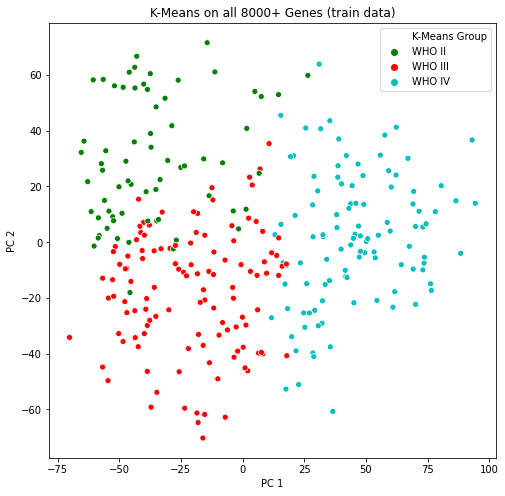

In [0]:
x = kmeans_train['PC 1']
y = kmeans_train['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = kmeans_train['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on all 8000+ Genes (train data)")
plt.show()

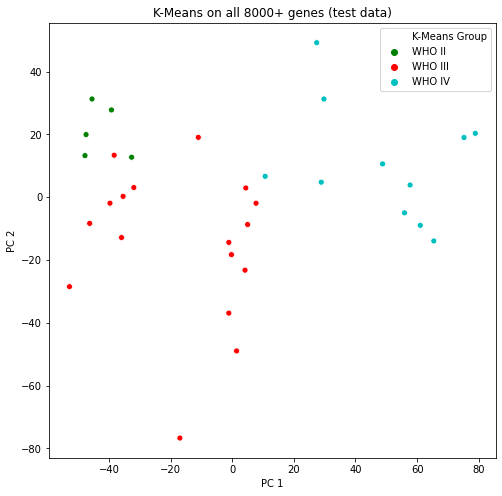

In [0]:
x = kmeans_test['PC 1']
y = kmeans_test['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = kmeans_test['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on all 8000+ genes (test data)")
plt.show()

### Compare Clusters to Grades

#### Visually

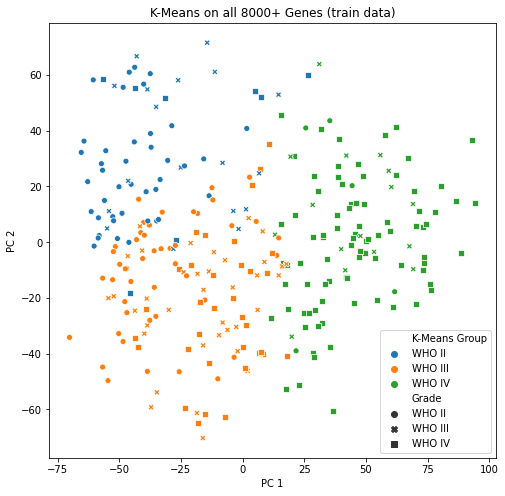

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = kmeans_train)
plt.title("K-Means on all 8000+ Genes (train data)")
plt.show()

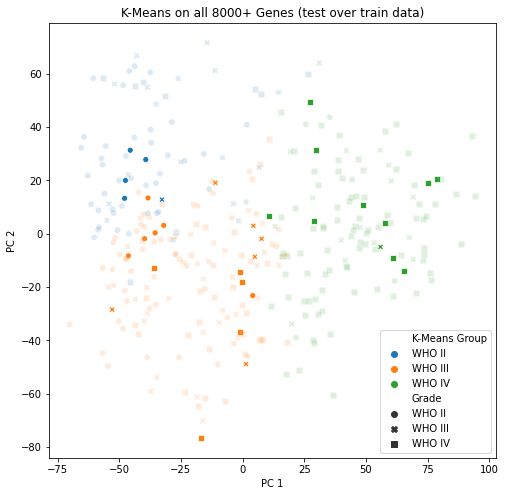

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = kmeans_test)
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = kmeans_train, alpha = .15, legend = False)
plt.title("K-Means on all 8000+ Genes (test over train data)")
plt.show()

#### Accuracy score

In [0]:
get_accuracy(kmeans_train['Grade'], kmeans_train['K-Means Group'])

0.5616438356164384

In [0]:
get_accuracy(kmeans_test['Grade'], kmeans_test['K-Means Group'])

0.6060606060606061

## On 100 PCs

### Implement

In [0]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

kmeans.fit(pca_train_genes)
test_pred = kmeans.predict(pca_test_genes)

In [0]:
pca_kmeans_test = pd.concat([pd.DataFrame(pca_test_genes), pd.DataFrame(test_pred), pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, 103)]
col_titles[-2:] = ['K-Means Group', 'Grade']
pca_kmeans_test.columns = col_titles

pca_kmeans_test = pca_kmeans_test.replace({'K-Means Group': {2:'WHO III', 1:'WHO IV', 0:'WHO II'}})

pca_kmeans_test.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,...,PC 63,PC 64,PC 65,PC 66,PC 67,PC 68,PC 69,PC 70,PC 71,PC 72,PC 73,PC 74,PC 75,PC 76,PC 77,PC 78,PC 79,PC 80,PC 81,PC 82,PC 83,PC 84,PC 85,PC 86,PC 87,PC 88,PC 89,PC 90,PC 91,PC 92,PC 93,PC 94,PC 95,PC 96,PC 97,PC 98,PC 99,PC 100,K-Means Group,Grade
0,-17.018512,-76.678514,15.561575,3.062704,-7.722779,-8.775850,-4.664851,23.154748,0.509266,7.973678,-3.623022,5.866161,-4.550189,12.146785,-1.392219,-18.246023,6.896821,0.944526,11.384552,6.991666,12.338170,11.705946,0.708997,2.287630,-13.341123,6.993175,-10.261956,8.248515,-2.400219,-1.427749,-4.416294,1.179152,9.364390,11.176043,8.197916,0.347621,-5.342266,6.541101,9.915753,-1.131762,...,-1.568144,0.758518,1.980277,4.713281,4.851716,-5.931367,-4.419590,-1.302903,-5.505166,1.024360,-2.717740,-8.427008,8.541599,-1.745657,8.284553,-3.434737,-9.377509,-9.517866,8.774370,-2.559249,0.977984,-0.086417,1.912350,-2.874511,0.575641,-1.678528,-6.968492,3.596621,0.387272,-1.224354,4.477667,-4.144775,-2.552277,-1.567604,-1.138090,-3.252450,6.836434,0.187049,WHO III,WHO IV
1,10.671509,6.637014,61.410853,35.650647,23.106033,-2.143400,-25.585916,-1.896293,-3.161299,29.643057,20.772200,-8.631180,10.108813,-4.321810,-1.290577,12.302224,5.609744,10.251688,-11.286736,8.424100,-7.446585,0.833440,6.362327,-1.295788,-0.538751,-2.789574,-0.909597,3.487231,13.054560,9.224215,-0.364302,-0.802777,9.328509,-10.093221,-1.792623,-4.062803,1.789310,-1.835673,0.649405,4.240894,...,2.205854,-2.969950,-0.531894,2.501960,-2.282490,-0.616521,-5.275008,2.981498,-4.601314,0.469132,-3.394217,5.113290,2.023322,-1.051664,-0.371899,3.816695,-0.850683,0.229438,1.325637,-0.948086,0.219822,-5.783033,2.556722,-1.987221,-2.458668,1.409523,-2.752795,4.696642,-4.087550,2.507288,5.316961,1.223567,1.236127,-1.043795,-2.984997,-2.397036,-3.314017,0.924540,WHO IV,WHO IV
2,-47.478944,19.938839,0.775281,-5.393339,1.060002,-1.258285,18.845099,10.749346,8.432701,-1.510634,2.498965,2.215257,-3.571031,5.632856,3.777480,3.711318,-0.018851,-0.569086,-3.031431,4.688648,9.404736,-0.974123,-0.790132,0.615564,-4.147071,8.098679,1.431979,2.792576,-0.381679,-5.142564,-0.689776,2.999639,7.062379,6.517923,-4.294524,-4.471987,2.412686,-1.969096,-0.674309,5.679641,...,1.325819,1.072653,1.519531,2.222347,-3.172628,-0.909233,3.724285,-0.655441,2.266533,1.877241,-0.885325,1.589409,0.469133,2.633640,1.337861,2.052690,-1.653839,-2.518615,0.860467,-0.412610,3.996704,2.738325,-1.375810,-0.843922,0.995765,-3.157285,-2.557065,0.082646,-0.126904,0.214093,0.752416,1.038075,-1.575182,1.096215,2.445567,-0.557107,-0.759410,1.535533,WHO II,WHO II
3,-46.293701,-8.338783,-8.556460,-11.787487,7.931985,-12.844711,6.540826,-18.449559,8.280567,2.268379,6.155999,6.697884,12.438830,-3.760121,3.321463,1.446364,-10.134700,-5.682686,-2.644134,3.815761,-2.071600,7.834877,-0.859072,-0.570158,-3.168933,-0.344856,-2.032103,3.334026,-3.248693,3.036791,3.179862,-0.565128,0.365566,3.902595,-1.120040,-1.179762,-0.556647,1.268869,-1.564766,0.533795,...,2.495933,-0.372766,-0.927606,0.403050,0.726465,-0.684169,0.750278,-1.785646,-0.733537,3.459306,-0.805410,1.273227,0.250722,1.422381,1.070423,1.603022,0.121284,0.918156,-2.341091,0.902276,-2.473149,0.797977,0.554601,2.005249,0.440211,1.854731,-0.984441,0.483813,1.189386,-0.137946,1.147722,-1.115155,0.602337,-0.278470,2.430697,-0.163343,-0.634093,-0.515978,WHO II,WHO II
4,-39.708933,-1.918164,-1.080752,-5.932954,7.909142,-28.034355,4.023443,-14.541399,18.140554,-0.283957,4.532071,6.897541,6.876370,-6.633463,1.865288,2.967301,-10.198049,1.619586,-1.488168,2.531958,4.955702,6.443589,-2.912846,-0.136850,-4.473982,4.336008,-2.179830,0.619619,-1.113891,-1.565422,-3.957438,-4.143265,-1.543306,0.800459,-1.424751,-0.076890,0.131354,-0.574398,1.389086,-0.054548,...,1.942085,1.935728,-0.081159,0.762961,1.872073,-0.0

In [0]:
pca_kmeans_train = pd.concat([pd.DataFrame(pca_train_genes), pd.DataFrame(kmeans.labels_), 
                              pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, 103)]
col_titles[-2:] = ['K-Means Group', 'Grade']
pca_kmeans_train.columns = col_titles

pca_kmeans_train = pca_kmeans_train.replace({'K-Means Group': {2:'WHO III', 1:'WHO IV', 0:'WHO II'}})

pca_kmeans_train.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,...,PC 63,PC 64,PC 65,PC 66,PC 67,PC 68,PC 69,PC 70,PC 71,PC 72,PC 73,PC 74,PC 75,PC 76,PC 77,PC 78,PC 79,PC 80,PC 81,PC 82,PC 83,PC 84,PC 85,PC 86,PC 87,PC 88,PC 89,PC 90,PC 91,PC 92,PC 93,PC 94,PC 95,PC 96,PC 97,PC 98,PC 99,PC 100,K-Means Group,Grade
0,-33.435050,22.490684,38.097767,33.143324,-17.619483,-3.171199,20.422858,-43.082454,-8.627830,-40.189536,-5.465451,12.660921,6.473937,1.850705,17.776311,3.827960,5.569363,-7.038127,5.134618,-1.663095,-6.170663,4.012359,-1.837601,9.008581,6.178398,-7.795723,-4.336150,1.467781,-4.227110,3.907333,3.873936,-5.471964,-7.335916,-0.225879,-0.498414,2.383156,-2.361388,0.037723,-0.908430,-3.256367,...,2.803386,2.272098,-6.949592,-4.367347,3.341168,1.947714,0.368989,4.152339,-1.243948,6.176505,0.441244,3.876104,-1.597739,-1.460799,2.279836,3.711773,-4.189875,-1.905389,-0.335042,4.345799,0.330479,-0.276266,-2.592846,-1.454869,5.041591,5.734734,0.123303,0.652437,4.450397,4.326512,-0.874418,-1.986951,-2.692382,-1.379689,1.034875,-3.335310,3.982891,-3.748216,WHO II,WHO II
1,23.423648,-7.423201,-17.507606,8.792664,6.431287,18.670136,9.897008,4.258857,-5.588947,-21.095098,-0.322124,0.209306,0.053304,-8.668610,0.180721,-4.388219,-2.996144,16.387477,-4.154526,-6.628741,-1.232861,-4.223455,5.966935,2.511681,-3.733841,1.644175,11.705988,4.247669,6.254536,2.301708,4.047875,-1.748213,-5.792585,-3.768745,6.325283,-4.410534,2.398020,-8.268529,10.467071,-0.573543,...,-2.924163,8.960608,3.823409,-1.243221,-7.467617,-7.572804,10.589349,0.772206,-11.084777,2.638333,3.811274,4.791859,7.358702,1.595207,-7.155816,6.898175,-1.040545,-0.265182,-8.283871,4.145279,0.835572,6.715944,-3.471030,11.431920,-3.422275,3.884578,-0.331670,4.339098,-4.573922,-1.594635,-8.345405,-3.611264,5.372493,0.348840,1.586277,3.331050,-0.243719,5.853999,WHO IV,WHO IV
2,-40.110197,7.114937,26.472899,-2.714790,2.348762,10.846683,24.951134,-15.586976,-12.524094,-13.831167,-8.258101,3.049686,-0.538163,4.341180,2.305371,13.008403,2.597718,-4.470039,-2.298502,17.885348,8.249679,7.956260,7.983512,4.190690,-6.485299,6.298476,-5.140809,0.337568,-6.390877,-3.273234,-3.172202,2.805812,4.912493,5.161848,-1.987693,-0.899333,-5.078180,-0.617562,-0.176509,2.137058,...,4.914696,3.133128,3.798334,3.028337,-0.084716,-0.897116,0.959289,-2.269742,0.740839,-1.123870,-4.365821,-1.742024,-2.435739,3.307302,-1.834632,6.475913,1.375272,0.094449,0.035361,-2.306720,-2.782514,-2.975034,-5.741852,-2.000292,-1.551768,-0.109299,-1.936931,4.388676,-3.977612,1.910316,3.031441,-3.236150,-0.829958,0.282971,1.168424,3.326105,0.266835,1.991631,WHO II,WHO II
3,-4.322818,5.918644,3.995310,-19.628973,-7.751300,-32.174292,-13.651544,2.071658,15.121449,-6.344336,-5.886292,0.644285,14.280968,-13.589546,9.365648,4.461883,-8.266585,2.415868,8.723480,0.640381,6.564455,2.067038,-4.285749,-0.938584,4.231604,1.755127,-3.522140,1.826236,7.630807,-3.197037,-6.149750,0.346512,-2.897506,-3.820346,-1.361873,-4.142842,-7.828329,-2.262813,3.168992,5.944592,...,2.550852,-0.166442,-1.226370,-1.065782,6.247316,2.170066,4.669627,-2.872206,0.270311,-1.223580,-2.399002,0.008102,-0.680455,-5.269030,-1.359116,-2.503650,-0.514182,3.798668,-5.069770,2.514992,-2.986627,1.182284,2.554844,-1.019743,-1.606059,1.312819,0.347434,-2.273195,0.749121,-2.407184,4.828789,-1.261966,1.076348,-0.596083,-3.169724,-2.342887,2.049022,3.854297,WHO III,WHO II
4,-32.589107,10.796249,10.908327,-21.124218,-3.384025,1.144437,17.386578,-5.382837,19.263953,8.948880,2.557172,6.291258,-4.473211,8.318475,-10.763676,0.585800,-2.121526,-7.917563,-0.147576,-3.251826,-7.029230,-4.653908,1.834073,1.242064,1.823627,-0.874835,-4.370777,-1.894273,7.025319,-4.739808,4.005834,5.864892,3.790564,7.195704,-0.669111,0.070380,-2.022720,0.079781,5.210897,-1.290279,...,-2.062645,1.687858,-1.904295,-1.139900,-4.2871

### Plot Clusters


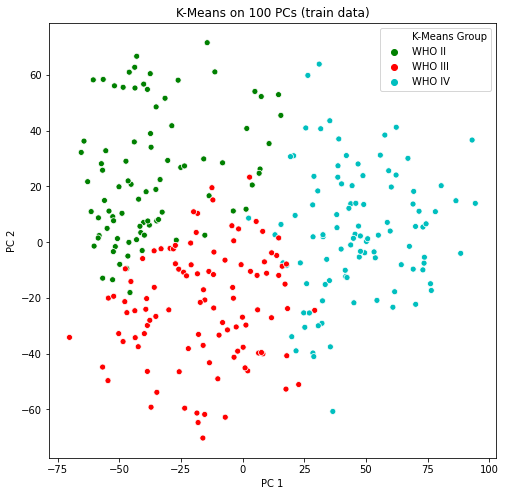

In [0]:
x = pca_kmeans_train['PC 1']
y = pca_kmeans_train['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = pca_kmeans_train['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on 100 PCs (train data)")
plt.show()

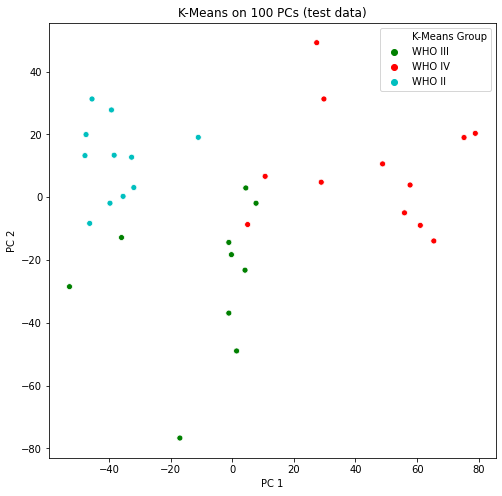

In [0]:
x = pca_kmeans_test['PC 1']
y = pca_kmeans_test['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = pca_kmeans_test['K-Means Group'], palette = ['g', 'r','c'])
plt.title("K-Means on 100 PCs (test data)")
plt.show()

### Compare Clusters to Grades

#### Visually

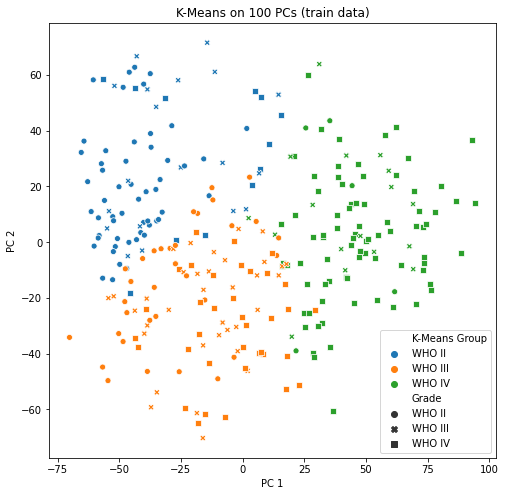

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = pca_kmeans_train)
plt.title("K-Means on 100 PCs (train data)")
plt.show()

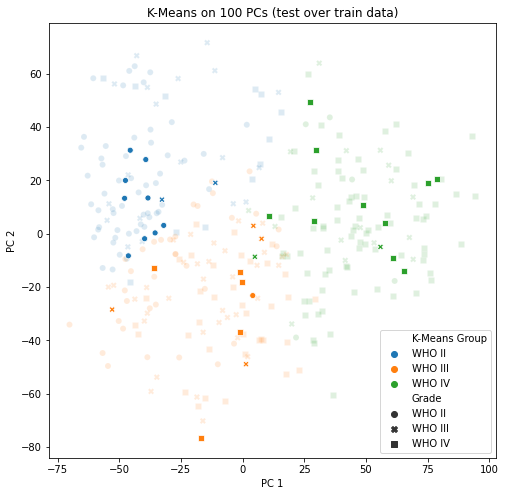

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = pca_kmeans_train, alpha = .15)
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = pca_kmeans_test, legend = False)
plt.title("K-Means on 100 PCs (test over train data)")
plt.show()

#### Accuracy score

In [0]:
get_accuracy(pca_kmeans_train['Grade'], pca_kmeans_train['K-Means Group'])

0.5787671232876712

In [0]:
get_accuracy(pca_kmeans_test['Grade'], pca_kmeans_test['K-Means Group'])

0.696969696969697

## On genes identified by PCA

### Implement

In [0]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

kmeans.fit(important_train)
test_pred = kmeans.predict(important_test)

In [0]:
top_kmeans_test = pd.concat([pd.DataFrame(important_test), pd.DataFrame(test_pred), pd.DataFrame(test_lbl)], axis = 1)

col_titles[:-2] = important_train.columns.values
col_titles[-2:] = ['K-Means Group', 'Grade']
top_kmeans_test.columns = col_titles

top_kmeans_test = top_kmeans_test.replace({'K-Means Group': {2:'WHO III', 1:'WHO IV', 0:'WHO II'}})

top_kmeans_test.head()

,10001,10013,10016,10023,10031,10037,10041,10044,10049,10050,10052,10054,10060,10069,10070,10072,10073,10076,10080,10084,10108,10111,10112,10121,10124,10125,10127,10129,10131,10135,10136,10151,10156,10163,10165,10173,10176,1018,10185,1019,...,9760,9762,9765,9766,9779,978,9787,979,9790,9805,9815,982,9821,9822,9826,9837,9843,9855,9856,9858,9867,9868,9869,9874,9889,989,9896,9897,9903,9910,9917,9930,9948,9955,9959,9962,9963,9985,K-Means Group,Grade
0,3.932932,0.043894,0.614781,3.613602,2.910062,2.328937,0.927249,-0.555144,2.972103,-0.998751,3.280720,0.586212,3.662315,4.052621,-1.835252,5.922257,4.101386,5.566846,1.276256,1.043894,-3.320679,0.824999,3.581395,0.507140,5.927960,1.323177,1.652014,0.633517,3.958235,-2.835252,5.290715,4.035993,2.428855,-0.711870,-1.119045,1.390816,3.040388,5.020506,3.008445,4.062161,...,3.422136,1.674806,1.050880,3.795145,-1.357205,-1.433154,0.000000,4.986750,1.043894,0.979445,-1.688411,0.714945,-1.119045,2.071638,2.955445,-2.394680,-3.320679,3.536058,2.672543,2.911982,1.340387,0.202883,-0.998751,1.919635,0.904287,2.075069,3.528570,-0.534083,-0.199664,1.938594,2.745410,-0.555144,1.537302,5.011581,2.331808,0.783658,1.015604,-3.472682,WHO III,WHO IV
1,4.391580,-0.125221,1.736499,1.679916,3.998288,3.212137,1.224363,4.943412,4.940173,1.464903,1.574025,-1.020524,2.385468,3.285447,5.840439,4.911632,5.343698,4.844405,3.166927,1.831475,-0.188647,1.500527,0.335620,-0.963940,4.908320,2.090507,2.751362,2.097171,4.679361,1.924334,1.693172,1.897862,2.657548,0.630241,2.221316,-1.494455,0.464903,6.893323,3.401709,4.921991,...,5.310034,0.369043,1.894041,2.585918,4.396991,3.519255,0.380014,4.125968,1.583547,1.510546,-0.687100,1.823460,4.560225,3.283987,1.423083,-1.454927,-0.172527,3.782703,3.751362,4.048147,2.859182,0.077087,-1.140818,2.090507,4.065241,2.992045,3.558415,1.807295,4.962698,1.648503,3.725789,0.433652,3.173248,4.264878,0.401709,-1.909493,2.404398,2.537744,WHO IV,WHO IV
2,6.991915,2.270290,2.962168,3.799381,2.994872,3.342440,1.721853,-1.725606,4.415805,0.369552,2.058137,-0.302394,1.480299,0.792243,4.124439,5.445685,6.207817,4.902425,0.100365,0.994872,-0.327056,2.515402,4.072350,1.215842,6.518217,4.477631,5.121024,2.977354,4.745700,-0.975584,5.360892,2.330662,4.072350,2.185650,2.159259,0.515402,1.487388,3.726355,4.074706,4.480299,...,5.252195,2.145880,2.062890,1.691480,1.999838,3.511930,0.241227,4.649434,2.034131,1.715829,0.136891,0.369552,2.081749,3.200825,3.420442,1.314809,2.754542,5.292721,6.956591,6.093122,4.670610,1.666712,0.487388,2.599598,4.060515,4.408354,5.084089,-1.230841,0.043781,1.536062,5.347319,2.515402,0.709780,-3.377682,2.294743,-1.327056,3.941667,1.072350,WHO II,WHO II
3,5.480287,1.175103,2.124581,3.006455,2.686167,2.734530,1.445904,0.899161,4.347621,1.109378,2.306220,-0.363874,0.584287,1.340478,0.811698,5.190715,5.586485,5.251183,-0.143908,1.469909,0.046914,3.738488,2.732547,0.968202,4.144853,2.794691,2.215420,1.215420,3.142615,0.034090,3.574357,3.078484,3.773630,1.133626,-0.234106,0.994920,1.562126,2.669679,4.337219,3.599600,...,5.183837,1.484123,1.694341,1.249103,0.877787,2.783241,-0.234106,4.264969,0.180932,1.909730,-0.313833,1.661364,0.292825,1.909730,2.932368,-1.281412,-0.234106,4.954230,6.477626,5.833603,4.471099,1.584287,-0.173352,2.548663,3.759091,3.269763,4.452545,-0.234106,-0.750897,2.421492,5.412540,2.163373,-1.487862,-1.415713,2.366287,1.072225,2.327398,-0.143908,WHO II,WHO II
4,6.272283,1.441327,2.268776,3.256902,3.015759,2.898372,1.650922,1.865516,3.858658,1.557208,2.343664,0.507964,0.704361,1.884933,2.382433,5.267667,5.883727,4.858167,0.877198,1.609502,0.024540,3.546273,3.319606,1.349266,5.942129,2.855708,3.346468,2.349266,4.059138,0.829892,4.676775,2.621127,3.795420,1.360407,0.268776,1.482697,1.145394,3.151820,4.273204,3.504202,...,5.123900,1.717417,1.825879,2.430796,1.926754,2.564451,-2.340033,4.375586,0.244930,1.941665,2.072749,2.099590,2.003375,2.289324,3.047123,-0.219018,-0.340033,5.417857,7.135397,6.055073,4.844842,1.497910,0.517948,2.537711,3.404128,3.753781,4.890228,1.

In [0]:
top_kmeans_train = pd.concat([pd.DataFrame(important_train), pd.DataFrame(kmeans.labels_), pd.DataFrame(train_lbl)], axis = 1)

col_titles[:-2] = important_train.columns.values
col_titles[-2:] = ['K-Means Group', 'Grade']
top_kmeans_train.columns = col_titles

top_kmeans_train = top_kmeans_train.replace({'K-Means Group': {2:'WHO III', 1:'WHO IV', 0:'WHO II'}})

top_kmeans_train.head()

,10001,10013,10016,10023,10031,10037,10041,10044,10049,10050,10052,10054,10060,10069,10070,10072,10073,10076,10080,10084,10108,10111,10112,10121,10124,10125,10127,10129,10131,10135,10136,10151,10156,10163,10165,10173,10176,1018,10185,1019,...,9760,9762,9765,9766,9779,978,9787,979,9790,9805,9815,982,9821,9822,9826,9837,9843,9855,9856,9858,9867,9868,9869,9874,9889,989,9896,9897,9903,9910,9917,9930,9948,9955,9959,9962,9963,9985,K-Means Group,Grade
0,5.727900,0.792760,2.373641,2.377722,3.707778,3.094992,2.049668,1.743007,5.635909,1.090026,1.840854,-1.389444,0.976206,0.921344,0.875901,4.718276,4.286242,5.225832,0.080042,1.792760,0.638037,2.510029,2.539473,1.008149,4.442473,3.521141,3.391916,2.034238,3.039400,-0.135687,3.379758,3.619200,4.047108,1.080042,0.691476,2.114688,0.336381,3.544928,3.803418,2.707778,...,5.339000,2.276439,3.160415,1.723898,1.780481,3.596617,1.267669,4.637186,1.926925,3.746167,0.638037,1.828980,0.954511,1.915741,2.069988,-0.089883,1.786634,5.611856,6.871566,5.761866,5.026461,0.898801,-2.389444,3.190887,4.551265,3.092511,3.671668,0.099941,0.039400,2.340569,5.395946,3.918545,-1.630452,-1.135687,1.369548,-0.045489,4.937331,-0.207240,WHO II,WHO II
1,5.279606,0.756814,2.460654,2.332898,1.373870,1.752382,2.055544,-1.421989,3.046522,-0.977205,1.396770,-0.891475,2.725498,1.859297,-1.733933,3.843756,5.592961,4.442197,-0.382461,2.996800,0.302903,1.176270,3.460654,0.765638,4.252791,4.062722,2.308952,1.000543,5.857234,0.791790,4.449745,3.581763,3.746822,3.508748,0.842714,-0.919489,3.231453,6.903441,3.409494,4.508748,...,5.440820,1.108525,-0.006952,2.941415,2.681881,3.231453,0.817477,5.297970,0.278450,0.851029,-0.052756,1.247289,-2.006952,2.218657,0.240976,0.597910,1.506118,5.535758,3.071644,3.953050,2.208986,0.907932,0.506118,3.438753,5.088445,3.595438,2.776592,-0.288134,0.385366,0.350600,4.791790,1.587995,-0.022059,3.918850,2.350600,-0.661177,2.471481,-0.919489,WHO IV,WHO IV
2,5.540728,0.753983,1.214345,2.254677,2.345751,2.114278,1.408848,-0.502925,4.545908,0.395792,0.591712,-1.926137,1.023823,0.395792,0.647855,4.660192,4.484797,5.429014,-1.137641,-0.408288,0.023823,3.769250,3.764179,0.945349,6.180962,2.804256,5.353369,3.184287,4.189025,-2.215643,5.635065,2.904451,3.909053,0.814104,-0.604208,2.053224,0.545169,3.862359,4.314872,3.707189,...,6.021434,1.614432,3.055301,1.375983,0.369319,3.212484,-0.830979,4.776194,1.753983,3.013176,-0.028016,0.434611,1.369319,1.428213,3.023823,0.199394,-1.298105,6.191389,6.202678,5.213415,4.590280,0.355899,-0.830979,3.155528,4.083056,4.128159,4.121235,-1.741712,-1.100166,1.733373,5.544430,1.032284,0.591712,3.349141,2.082037,-0.959303,3.699240,-0.630681,WHO II,WHO II
3,5.700313,1.487249,2.197211,1.732660,2.998713,2.623883,0.870896,1.463163,3.418769,0.892700,2.883655,0.293238,0.956203,2.406191,1.784119,5.584792,5.853629,4.108379,0.716449,1.687636,0.552625,0.748690,2.200129,1.728624,5.439286,3.002061,3.478864,3.040007,5.045695,1.113030,4.477663,2.728624,3.925682,0.928324,-0.136446,0.561727,1.062625,4.431238,3.898100,4.415007,...,5.142145,1.799591,0.658235,3.117666,0.314933,3.030204,0.131487,5.002896,1.049744,1.352132,1.788003,2.730643,1.069023,2.052975,3.065827,-0.918266,-0.393604,5.432789,3.584234,4.786062,4.615712,1.845034,-0.050716,2.211740,4.211017,5.632548,4.516801,1.293238,0.398591,2.091194,6.104686,0.534246,-0.685067,4.143662,1.610788,1.520307,2.545760,-0.341765,WHO III,WHO II
4,5.865440,2.211946,2.148170,4.633306,3.365313,2.743960,0.880237,-0.169688,4.270216,0.280477,2.405078,0.072882,0.789089,-0.231973,1.196264,5.531533,6.476604,5.124026,-0.461454,0.669249,-1.412545,1.928492,3.492742,1.581431,4.553239,2.418657,4.379269,3.746654,4.511080,-0.591515,4.557849,3.465199,4.336989,1.855490,0.487919,-0.052649,2.569308,3.996846,4.044699,4.456998,...,5.131260,2.768027,2.077169,1.713988,1.196264,3.319000,-0.538076,4.713299,1.820116,2.219723,-0.675579,0.381004,-1.149510,1.860474,2.688993,-0.342156,-3.997507,4.649951,7.126743,3.597937,4.340560,2.381004,1.242807,2.842956,3.156298,4.676332,4.705704,-

### Plot clusters

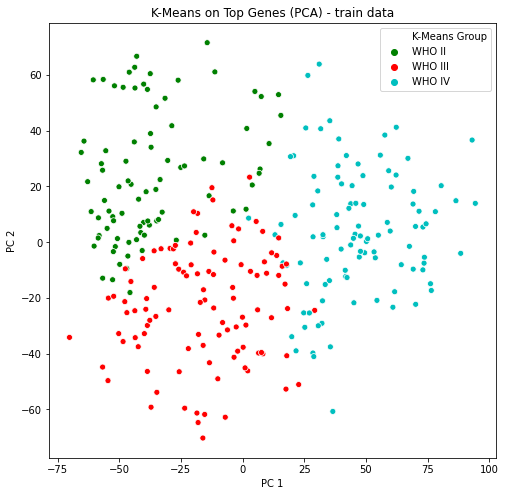

In [0]:
x = pca_kmeans_train['PC 1']
y = pca_kmeans_train['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = top_kmeans_train['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on Top Genes (PCA) - train data")
plt.show()

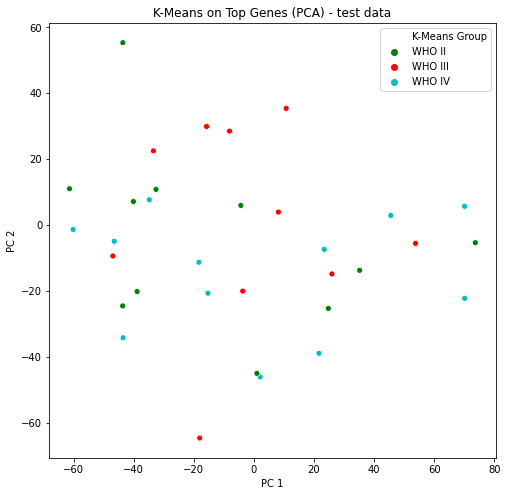

In [0]:
x = pca_kmeans_train['PC 1']
y = pca_kmeans_train['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = top_kmeans_test['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on Top Genes (PCA) - test data")
plt.show()

### Compare Clusters to Grades

#### Visually

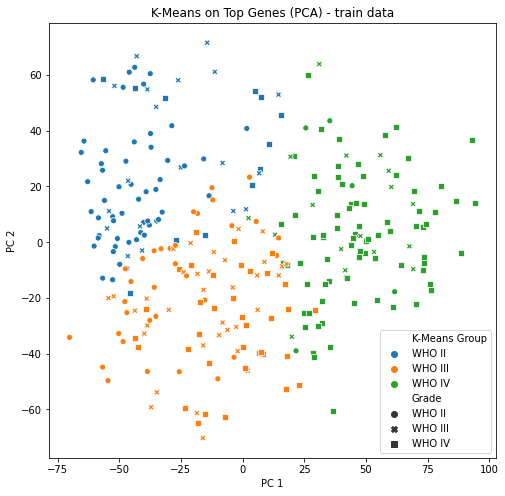

In [0]:
x = pca_kmeans_train['PC 1']
y = pca_kmeans_train['PC 2']

plt.figure(figsize = (8,8))
sb.scatterplot(x , y , hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = top_kmeans_train)
plt.title("K-Means on Top Genes (PCA) - train data")
plt.show()

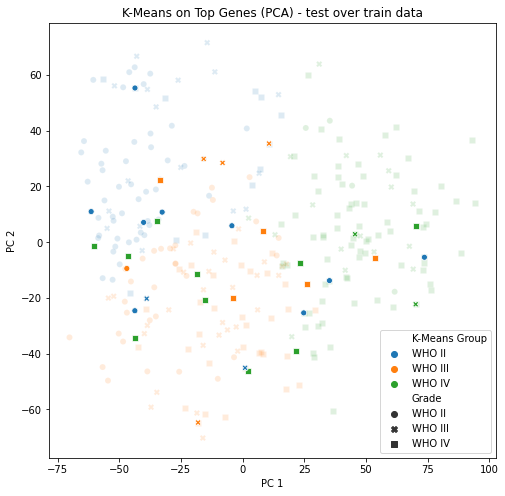

In [0]:
x = pca_kmeans_train['PC 1']
y = pca_kmeans_train['PC 2']
plt.figure(figsize = (8,8))
sb.scatterplot(x, y, hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = top_kmeans_train, alpha = .15)
sb.scatterplot(x, y, hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = top_kmeans_test, legend = False)
plt.title("K-Means on Top Genes (PCA) - test over train data")
plt.show()

#### Accuracy Score

In [0]:
get_accuracy(top_kmeans_train['Grade'], top_kmeans_train['K-Means Group'])

0.5787671232876712

In [0]:
get_accuracy(top_kmeans_test['Grade'], top_kmeans_test['K-Means Group'])

0.696969696969697

## On 100 Factors

### Implement

In [0]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

kmeans.fit(fa_train_genes)
test_pred = kmeans.predict(fa_test_genes)

In [0]:
fa_kmeans_test = pd.concat([pd.DataFrame(fa_test), pd.DataFrame(test_pred)], axis = 1)

col_titles[:-2] = fa_train.columns.values[:-1]
col_titles[-2:] = ['Grade', 'K-Means Group']
fa_kmeans_test.columns = col_titles

fa_kmeans_test = fa_kmeans_test.replace({'K-Means Group': {2:'WHO III', 0:'WHO IV', 1:'WHO II'}})

fa_kmeans_test.head()

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15,Factor 16,Factor 17,Factor 18,Factor 19,Factor 20,Factor 21,Factor 22,Factor 23,Factor 24,Factor 25,Factor 26,Factor 27,Factor 28,Factor 29,Factor 30,Factor 31,Factor 32,Factor 33,Factor 34,Factor 35,Factor 36,Factor 37,Factor 38,Factor 39,Factor 40,...,Factor 63,Factor 64,Factor 65,Factor 66,Factor 67,Factor 68,Factor 69,Factor 70,Factor 71,Factor 72,Factor 73,Factor 74,Factor 75,Factor 76,Factor 77,Factor 78,Factor 79,Factor 80,Factor 81,Factor 82,Factor 83,Factor 84,Factor 85,Factor 86,Factor 87,Factor 88,Factor 89,Factor 90,Factor 91,Factor 92,Factor 93,Factor 94,Factor 95,Factor 96,Factor 97,Factor 98,Factor 99,Factor 100,Grade,K-Means Group
0,-0.293440,2.538886,-0.681511,0.568800,-0.486379,-0.779511,0.319821,1.345924,-0.322250,-1.543843,0.583401,1.232805,1.015854,0.371118,0.726277,-1.793935,0.595507,1.381473,0.146248,-0.627867,1.816056,-1.514732,1.279376,-0.541915,-0.503033,0.677510,-2.602009,0.990409,-1.203804,-1.624827,1.442395,0.003285,-0.806711,-2.130532,-0.922185,1.211113,0.675092,0.930663,-0.030370,0.327993,...,0.181058,1.941298,-2.222015,-0.918663,-1.127551,0.955807,-0.755799,0.019922,3.750914,-0.136771,2.480472,1.341996,1.514001,-1.479348,-2.774186,2.167005,1.845020,-0.688455,-1.843069,-0.394638,2.116943,-0.407150,0.818184,-0.816016,0.064942,0.986092,0.205071,1.520231,-0.337685,-1.020581,-0.319427,-2.768241,0.609570,0.387526,-0.541136,0.203349,0.843216,-0.207020,WHO IV,WHO II
1,0.324620,0.320905,-0.001379,3.038895,1.789471,0.165920,-2.021166,-1.015364,0.394811,-2.838859,-0.892280,-2.068333,0.330254,0.075194,-0.361176,0.709951,1.915603,-1.290557,-0.529883,1.427255,-0.678221,0.282330,0.281810,0.989438,0.133487,-0.813798,0.024551,1.098699,1.331911,-0.247413,1.089651,1.520390,2.552489,0.659972,0.443962,-1.244502,-0.129881,-0.534517,-0.642364,-0.998721,...,-1.190419,0.839269,-0.432565,-0.610082,0.100808,-0.780341,-1.514881,0.213097,0.493203,-1.221235,0.915697,0.513288,0.614149,-0.283112,0.548249,-0.632030,1.084227,0.111545,1.039633,-0.012621,0.441137,0.886790,-0.718504,-1.305706,0.202242,-0.760016,1.094748,-0.414678,0.618624,-0.250067,-0.622165,-0.176920,1.646883,-1.226587,0.509953,0.791242,-0.390949,-0.668325,WHO IV,WHO II
2,-1.149085,-0.725466,-0.161190,0.100292,-0.135751,0.447639,1.397324,0.732199,0.198626,-0.174552,0.252575,0.098434,-0.201954,1.109297,-0.362313,0.611463,0.252529,-0.328643,0.187580,-0.351575,1.453071,-0.282818,0.086284,-0.131108,-0.075098,0.546457,-0.347318,0.404466,0.175415,-0.935541,0.697452,0.543868,-1.326968,-0.798311,0.110845,-1.492511,-0.294801,0.442117,-0.170704,-1.192030,...,-0.183156,-0.440594,0.938233,-0.046092,-0.661072,0.329273,-0.586578,0.515794,-0.039014,0.324517,0.114069,-0.110840,0.209480,-0.006129,-0.641516,0.481802,0.213864,0.377849,0.004588,-0.405983,-0.021938,1.210337,0.795871,-0.848095,0.590221,0.391976,-0.268752,-0.157662,-0.176234,0.056113,-0.188803,-0.267155,0.447616,-0.704491,0.614786,0.263612,0.665294,-0.383083,WHO II,WHO II
3,-1.171114,0.380817,-0.509393,-0.778159,0.568190,0.228791,0.408663,-1.304155,0.910656,-0.400083,0.108526,-0.780755,-0.610037,-0.624102,-1.455385,0.215294,-1.350310,-0.298107,-0.909006,0.128485,-0.005939,-1.041672,0.504513,0.006271,0.233487,0.173494,-0.586015,0.290266,-0.825464,0.271224,0.395707,-0.256013,0.119838,-0.852398,0.395025,-0.068228,-0.552795,-0.170839,0.146349,-0.367205,...,0.171287,-0.204903,0.103397,-0.068474,0.006126,-0.111813,0.439918,0.409053,0.541837,-0.766683,-0.208610,0.150967,0.201722,0.477650,0.570681,-0.450848,-0.179122,-0.210300,-0.046033,-0.044556,-0.177725,-0.080124,-0.229516,0.140195,0.034021,0.122877,0.360044,0.347633,0.132775,0.123528,0.107490,0.339592,-0.311282,0.034030,-0.348044,0.098321,-0.154382,-0.752504,WHO II,WHO II
4,-0.999554,0.257892,-0.399793,-0.399037,0.653508,-0.356721,0.683092,-0.835377,2.041559,-0.493432,0.701805,-0.706554,-1.159834,-0.390775,-0.939134,0.467496,-0.002841

In [0]:
fa_kmeans_train = pd.concat([pd.DataFrame(fa_train), pd.DataFrame(kmeans.labels_)], axis = 1)

col_titles[:-2] = fa_train.columns.values[:-1]
col_titles[-2:] = ['Grade', 'K-Means Group']
fa_kmeans_train.columns = col_titles

fa_kmeans_train = fa_kmeans_train.replace({'K-Means Group': {2:'WHO III', 0:'WHO IV', 1:'WHO II'}})

fa_kmeans_train.head()

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15,Factor 16,Factor 17,Factor 18,Factor 19,Factor 20,Factor 21,Factor 22,Factor 23,Factor 24,Factor 25,Factor 26,Factor 27,Factor 28,Factor 29,Factor 30,Factor 31,Factor 32,Factor 33,Factor 34,Factor 35,Factor 36,Factor 37,Factor 38,Factor 39,Factor 40,...,Factor 63,Factor 64,Factor 65,Factor 66,Factor 67,Factor 68,Factor 69,Factor 70,Factor 71,Factor 72,Factor 73,Factor 74,Factor 75,Factor 76,Factor 77,Factor 78,Factor 79,Factor 80,Factor 81,Factor 82,Factor 83,Factor 84,Factor 85,Factor 86,Factor 87,Factor 88,Factor 89,Factor 90,Factor 91,Factor 92,Factor 93,Factor 94,Factor 95,Factor 96,Factor 97,Factor 98,Factor 99,Factor 100,Grade,K-Means Group
0,-0.767871,-0.385531,0.115836,2.388345,-0.383484,-0.467369,0.561467,-2.350664,0.418821,3.973832,1.393458,0.537795,-1.186955,0.241165,-2.461988,-0.384562,-0.998326,0.576849,1.282513,0.930144,-1.114290,-0.555400,0.582111,-1.286940,-0.756003,-0.851512,0.500168,-0.302530,-1.151444,1.133120,0.066960,-0.897220,0.713943,0.469944,0.523972,0.829169,-0.259754,0.334612,0.638612,0.837120,...,0.667772,-0.687835,-1.093906,0.663421,1.777082,0.403360,1.039033,0.014080,0.939824,-0.798166,-0.012489,-1.292066,-1.089388,0.435321,1.080004,-0.580681,0.193973,-0.696573,0.209947,1.181998,1.581319,0.001383,-0.257150,0.536074,0.311319,0.998915,-0.095354,2.095175,0.483481,0.344128,1.088099,-1.533397,0.904053,-0.544323,-2.056798,1.683718,-0.716638,-0.717733,WHO II,WHO II
1,0.539117,0.327107,0.852022,-0.332517,-0.004732,0.745542,0.420696,0.905649,-0.866477,1.996034,0.113299,-0.303487,-0.368289,-0.738100,-0.355224,-0.306828,1.579579,-0.624290,-0.943939,-0.140500,-0.371726,1.095854,-0.376742,-0.131920,1.156971,0.019174,0.526034,1.989616,1.022750,0.108739,-0.671821,-0.700076,0.210346,0.400768,-0.186391,-1.013761,1.210125,0.822048,-0.608654,0.412536,...,-1.716859,0.398347,0.363219,0.184676,-0.871169,2.087683,-2.375473,4.507718,0.359282,0.120722,-1.184790,-1.131110,0.596269,-1.417280,3.027256,-1.059554,-1.926482,-1.727431,0.575586,-1.020027,-0.035904,-0.445189,0.958550,1.122069,-1.147704,1.916830,0.175825,-1.755637,-0.108784,0.047249,-2.818945,2.346825,-2.154707,-0.128855,-1.230194,0.923162,-1.032598,0.883319,WHO IV,WHO II
2,-0.914146,-0.218124,-0.782675,1.019773,0.375657,0.519532,0.913710,-1.079186,-0.907992,1.785236,0.315228,0.503691,-0.523415,0.600933,-0.377421,1.659806,0.111216,-0.507630,0.373521,1.309040,2.158432,-0.649656,2.112633,-0.537144,-0.300375,0.304272,-1.232271,-0.303918,-0.466015,-0.998909,0.478124,0.124541,-0.578029,-0.843605,0.154575,0.143870,-0.867417,-0.063425,0.102344,-0.828719,...,-0.342601,-1.091383,0.584348,0.084750,-0.297700,0.573446,-0.372649,0.069827,-0.060793,0.694590,1.544628,1.004739,1.563913,-0.019049,0.554957,0.060621,-0.619902,0.381322,0.727567,-0.004370,-0.079075,1.533853,-0.318394,0.100634,-0.178083,-0.220553,0.727758,-1.449127,0.138948,0.788301,0.348312,0.520673,1.320611,-0.702829,-0.331891,-0.452675,-0.783852,-0.367775,WHO II,WHO II
3,-0.010240,-0.408593,-1.194213,-0.386557,0.003723,-1.695766,-0.276458,0.752302,1.858447,-0.038924,-0.494421,-0.505349,-1.804313,-0.779621,-1.425660,0.286663,0.260123,1.654794,-0.879751,-0.318515,0.663504,-0.573909,-0.654317,0.076841,-1.708391,-1.136160,-0.360114,0.521692,0.938267,-0.223938,-0.616241,-0.095428,-0.039779,1.251148,-0.454566,0.253899,-1.674527,0.542885,-0.161628,-0.132685,...,0.414760,-1.054944,-0.810270,0.392132,0.229581,-0.028218,1.044777,0.852055,-0.145478,0.086758,-0.776033,0.473123,0.725105,0.000560,0.576832,-0.573361,-0.678358,1.069336,-0.443874,1.552338,-0.308504,-0.923042,-1.355427,0.088791,0.648256,-0.374091,-0.184248,-0.618326,-0.348110,1.108395,-0.278188,-0.167396,-0.417089,-0.212686,0.996606,0.270324,0.030926,0.107322,WHO II,WHO II
4,-0.785148,-0.501948,-1.059175,-0.116568,-0.353897,1.322514,1.409249,-0.578670,0.985555,-0.809191,0.794120,0.010905,0.750028,0.052386,0.721943,0.340907,-1.095

### Plot clusters

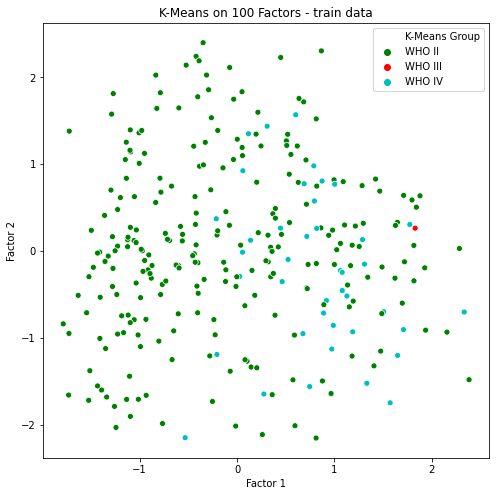

In [0]:
x = fa_kmeans_train['Factor 1']
y = fa_kmeans_train['Factor 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = fa_kmeans_train['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on 100 Factors - train data")
plt.show()

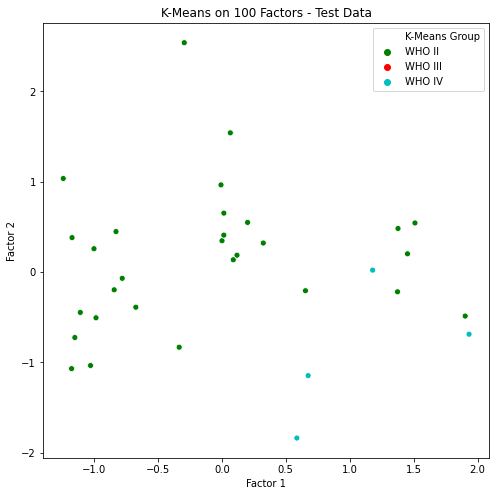

In [0]:
x = fa_kmeans_test['Factor 1']
y = fa_kmeans_test['Factor 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = fa_kmeans_test['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on 100 Factors - Test Data")
plt.show()

### Compare Clusters to Grades

#### Visually

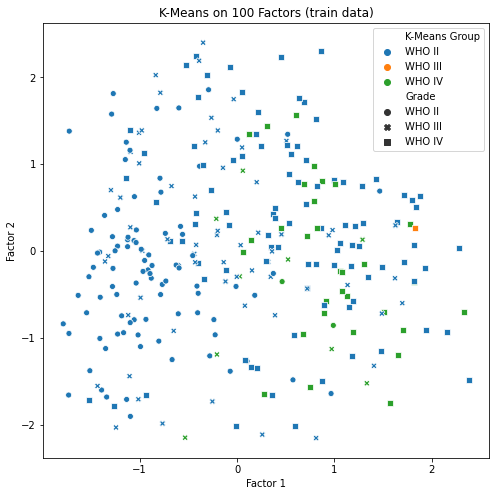

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'Factor 1', y = 'Factor 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = fa_kmeans_train)
plt.title("K-Means on 100 Factors (train data)")
plt.show()

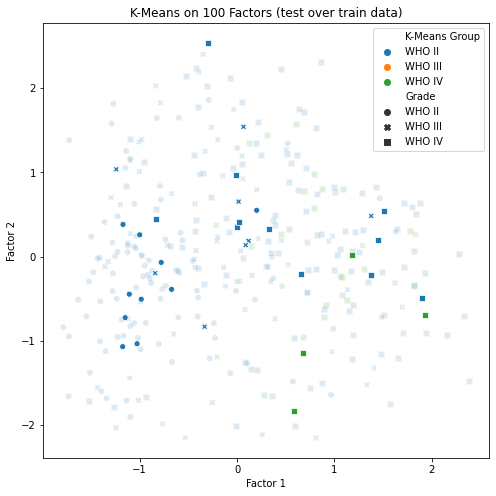

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'Factor 1', y = 'Factor 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = fa_kmeans_train, alpha = .15)
sb.scatterplot(x = 'Factor 1', y = 'Factor 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = fa_kmeans_test, legend = False)
plt.title("K-Means on 100 Factors (test over train data)")
plt.show()

#### Accuracy Score

In [0]:
get_accuracy(fa_kmeans_train['Grade'], fa_kmeans_train['K-Means Group'])

0.4178082191780822

In [0]:
get_accuracy(fa_kmeans_test['Grade'], fa_kmeans_test['K-Means Group'])

0.42424242424242425

## On genes identified by Factor Analysis

### Implement

In [0]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

kmeans.fit(fa_important_train)
test_pred = kmeans.predict(fa_important_test)

In [0]:
fa_top_kmeans_test = pd.concat([pd.DataFrame(fa_test), pd.DataFrame(test_pred)], axis = 1)

col_titles[:-2] = fa_train.columns.values[:-1]
col_titles[-2:] = ['Grade', 'K-Means Group']
fa_top_kmeans_test.columns = col_titles

fa_top_kmeans_test = fa_top_kmeans_test.replace({'K-Means Group': {2:'WHO III', 0:'WHO IV', 1:'WHO II'}})

fa_top_kmeans_test.head()

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15,Factor 16,Factor 17,Factor 18,Factor 19,Factor 20,Factor 21,Factor 22,Factor 23,Factor 24,Factor 25,Factor 26,Factor 27,Factor 28,Factor 29,Factor 30,Factor 31,Factor 32,Factor 33,Factor 34,Factor 35,Factor 36,Factor 37,Factor 38,Factor 39,Factor 40,...,Factor 63,Factor 64,Factor 65,Factor 66,Factor 67,Factor 68,Factor 69,Factor 70,Factor 71,Factor 72,Factor 73,Factor 74,Factor 75,Factor 76,Factor 77,Factor 78,Factor 79,Factor 80,Factor 81,Factor 82,Factor 83,Factor 84,Factor 85,Factor 86,Factor 87,Factor 88,Factor 89,Factor 90,Factor 91,Factor 92,Factor 93,Factor 94,Factor 95,Factor 96,Factor 97,Factor 98,Factor 99,Factor 100,Grade,K-Means Group
0,-0.293440,2.538886,-0.681511,0.568800,-0.486379,-0.779511,0.319821,1.345924,-0.322250,-1.543843,0.583401,1.232805,1.015854,0.371118,0.726277,-1.793935,0.595507,1.381473,0.146248,-0.627867,1.816056,-1.514732,1.279376,-0.541915,-0.503033,0.677510,-2.602009,0.990409,-1.203804,-1.624827,1.442395,0.003285,-0.806711,-2.130532,-0.922185,1.211113,0.675092,0.930663,-0.030370,0.327993,...,0.181058,1.941298,-2.222015,-0.918663,-1.127551,0.955807,-0.755799,0.019922,3.750914,-0.136771,2.480472,1.341996,1.514001,-1.479348,-2.774186,2.167005,1.845020,-0.688455,-1.843069,-0.394638,2.116943,-0.407150,0.818184,-0.816016,0.064942,0.986092,0.205071,1.520231,-0.337685,-1.020581,-0.319427,-2.768241,0.609570,0.387526,-0.541136,0.203349,0.843216,-0.207020,WHO IV,WHO III
1,0.324620,0.320905,-0.001379,3.038895,1.789471,0.165920,-2.021166,-1.015364,0.394811,-2.838859,-0.892280,-2.068333,0.330254,0.075194,-0.361176,0.709951,1.915603,-1.290557,-0.529883,1.427255,-0.678221,0.282330,0.281810,0.989438,0.133487,-0.813798,0.024551,1.098699,1.331911,-0.247413,1.089651,1.520390,2.552489,0.659972,0.443962,-1.244502,-0.129881,-0.534517,-0.642364,-0.998721,...,-1.190419,0.839269,-0.432565,-0.610082,0.100808,-0.780341,-1.514881,0.213097,0.493203,-1.221235,0.915697,0.513288,0.614149,-0.283112,0.548249,-0.632030,1.084227,0.111545,1.039633,-0.012621,0.441137,0.886790,-0.718504,-1.305706,0.202242,-0.760016,1.094748,-0.414678,0.618624,-0.250067,-0.622165,-0.176920,1.646883,-1.226587,0.509953,0.791242,-0.390949,-0.668325,WHO IV,WHO IV
2,-1.149085,-0.725466,-0.161190,0.100292,-0.135751,0.447639,1.397324,0.732199,0.198626,-0.174552,0.252575,0.098434,-0.201954,1.109297,-0.362313,0.611463,0.252529,-0.328643,0.187580,-0.351575,1.453071,-0.282818,0.086284,-0.131108,-0.075098,0.546457,-0.347318,0.404466,0.175415,-0.935541,0.697452,0.543868,-1.326968,-0.798311,0.110845,-1.492511,-0.294801,0.442117,-0.170704,-1.192030,...,-0.183156,-0.440594,0.938233,-0.046092,-0.661072,0.329273,-0.586578,0.515794,-0.039014,0.324517,0.114069,-0.110840,0.209480,-0.006129,-0.641516,0.481802,0.213864,0.377849,0.004588,-0.405983,-0.021938,1.210337,0.795871,-0.848095,0.590221,0.391976,-0.268752,-0.157662,-0.176234,0.056113,-0.188803,-0.267155,0.447616,-0.704491,0.614786,0.263612,0.665294,-0.383083,WHO II,WHO II
3,-1.171114,0.380817,-0.509393,-0.778159,0.568190,0.228791,0.408663,-1.304155,0.910656,-0.400083,0.108526,-0.780755,-0.610037,-0.624102,-1.455385,0.215294,-1.350310,-0.298107,-0.909006,0.128485,-0.005939,-1.041672,0.504513,0.006271,0.233487,0.173494,-0.586015,0.290266,-0.825464,0.271224,0.395707,-0.256013,0.119838,-0.852398,0.395025,-0.068228,-0.552795,-0.170839,0.146349,-0.367205,...,0.171287,-0.204903,0.103397,-0.068474,0.006126,-0.111813,0.439918,0.409053,0.541837,-0.766683,-0.208610,0.150967,0.201722,0.477650,0.570681,-0.450848,-0.179122,-0.210300,-0.046033,-0.044556,-0.177725,-0.080124,-0.229516,0.140195,0.034021,0.122877,0.360044,0.347633,0.132775,0.123528,0.107490,0.339592,-0.311282,0.034030,-0.348044,0.098321,-0.154382,-0.752504,WHO II,WHO III
4,-0.999554,0.257892,-0.399793,-0.399037,0.653508,-0.356721,0.683092,-0.835377,2.041559,-0.493432,0.701805,-0.706554,-1.159834,-0.390775,-0.939134,0.467496,-0.0028

In [0]:
fa_top_kmeans_train = pd.concat([pd.DataFrame(fa_train), pd.DataFrame(kmeans.labels_)], axis = 1)

col_titles[:-2] = fa_train.columns.values[:-1]
col_titles[-2:] = ['Grade', 'K-Means Group']
fa_top_kmeans_train.columns = col_titles

fa_top_kmeans_train = fa_top_kmeans_train.replace({'K-Means Group': {2:'WHO III', 0:'WHO IV', 1:'WHO II'}})

fa_top_kmeans_train.head()

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15,Factor 16,Factor 17,Factor 18,Factor 19,Factor 20,Factor 21,Factor 22,Factor 23,Factor 24,Factor 25,Factor 26,Factor 27,Factor 28,Factor 29,Factor 30,Factor 31,Factor 32,Factor 33,Factor 34,Factor 35,Factor 36,Factor 37,Factor 38,Factor 39,Factor 40,...,Factor 63,Factor 64,Factor 65,Factor 66,Factor 67,Factor 68,Factor 69,Factor 70,Factor 71,Factor 72,Factor 73,Factor 74,Factor 75,Factor 76,Factor 77,Factor 78,Factor 79,Factor 80,Factor 81,Factor 82,Factor 83,Factor 84,Factor 85,Factor 86,Factor 87,Factor 88,Factor 89,Factor 90,Factor 91,Factor 92,Factor 93,Factor 94,Factor 95,Factor 96,Factor 97,Factor 98,Factor 99,Factor 100,Grade,K-Means Group
0,-0.767871,-0.385531,0.115836,2.388345,-0.383484,-0.467369,0.561467,-2.350664,0.418821,3.973832,1.393458,0.537795,-1.186955,0.241165,-2.461988,-0.384562,-0.998326,0.576849,1.282513,0.930144,-1.114290,-0.555400,0.582111,-1.286940,-0.756003,-0.851512,0.500168,-0.302530,-1.151444,1.133120,0.066960,-0.897220,0.713943,0.469944,0.523972,0.829169,-0.259754,0.334612,0.638612,0.837120,...,0.667772,-0.687835,-1.093906,0.663421,1.777082,0.403360,1.039033,0.014080,0.939824,-0.798166,-0.012489,-1.292066,-1.089388,0.435321,1.080004,-0.580681,0.193973,-0.696573,0.209947,1.181998,1.581319,0.001383,-0.257150,0.536074,0.311319,0.998915,-0.095354,2.095175,0.483481,0.344128,1.088099,-1.533397,0.904053,-0.544323,-2.056798,1.683718,-0.716638,-0.717733,WHO II,WHO II
1,0.539117,0.327107,0.852022,-0.332517,-0.004732,0.745542,0.420696,0.905649,-0.866477,1.996034,0.113299,-0.303487,-0.368289,-0.738100,-0.355224,-0.306828,1.579579,-0.624290,-0.943939,-0.140500,-0.371726,1.095854,-0.376742,-0.131920,1.156971,0.019174,0.526034,1.989616,1.022750,0.108739,-0.671821,-0.700076,0.210346,0.400768,-0.186391,-1.013761,1.210125,0.822048,-0.608654,0.412536,...,-1.716859,0.398347,0.363219,0.184676,-0.871169,2.087683,-2.375473,4.507718,0.359282,0.120722,-1.184790,-1.131110,0.596269,-1.417280,3.027256,-1.059554,-1.926482,-1.727431,0.575586,-1.020027,-0.035904,-0.445189,0.958550,1.122069,-1.147704,1.916830,0.175825,-1.755637,-0.108784,0.047249,-2.818945,2.346825,-2.154707,-0.128855,-1.230194,0.923162,-1.032598,0.883319,WHO IV,WHO IV
2,-0.914146,-0.218124,-0.782675,1.019773,0.375657,0.519532,0.913710,-1.079186,-0.907992,1.785236,0.315228,0.503691,-0.523415,0.600933,-0.377421,1.659806,0.111216,-0.507630,0.373521,1.309040,2.158432,-0.649656,2.112633,-0.537144,-0.300375,0.304272,-1.232271,-0.303918,-0.466015,-0.998909,0.478124,0.124541,-0.578029,-0.843605,0.154575,0.143870,-0.867417,-0.063425,0.102344,-0.828719,...,-0.342601,-1.091383,0.584348,0.084750,-0.297700,0.573446,-0.372649,0.069827,-0.060793,0.694590,1.544628,1.004739,1.563913,-0.019049,0.554957,0.060621,-0.619902,0.381322,0.727567,-0.004370,-0.079075,1.533853,-0.318394,0.100634,-0.178083,-0.220553,0.727758,-1.449127,0.138948,0.788301,0.348312,0.520673,1.320611,-0.702829,-0.331891,-0.452675,-0.783852,-0.367775,WHO II,WHO III
3,-0.010240,-0.408593,-1.194213,-0.386557,0.003723,-1.695766,-0.276458,0.752302,1.858447,-0.038924,-0.494421,-0.505349,-1.804313,-0.779621,-1.425660,0.286663,0.260123,1.654794,-0.879751,-0.318515,0.663504,-0.573909,-0.654317,0.076841,-1.708391,-1.136160,-0.360114,0.521692,0.938267,-0.223938,-0.616241,-0.095428,-0.039779,1.251148,-0.454566,0.253899,-1.674527,0.542885,-0.161628,-0.132685,...,0.414760,-1.054944,-0.810270,0.392132,0.229581,-0.028218,1.044777,0.852055,-0.145478,0.086758,-0.776033,0.473123,0.725105,0.000560,0.576832,-0.573361,-0.678358,1.069336,-0.443874,1.552338,-0.308504,-0.923042,-1.355427,0.088791,0.648256,-0.374091,-0.184248,-0.618326,-0.348110,1.108395,-0.278188,-0.167396,-0.417089,-0.212686,0.996606,0.270324,0.030926,0.107322,WHO II,WHO III
4,-0.785148,-0.501948,-1.059175,-0.116568,-0.353897,1.322514,1.409249,-0.578670,0.985555,-0.809191,0.794120,0.010905,0.750028,0.052386,0.721943,0.340907,-1.0

### Plot clusters

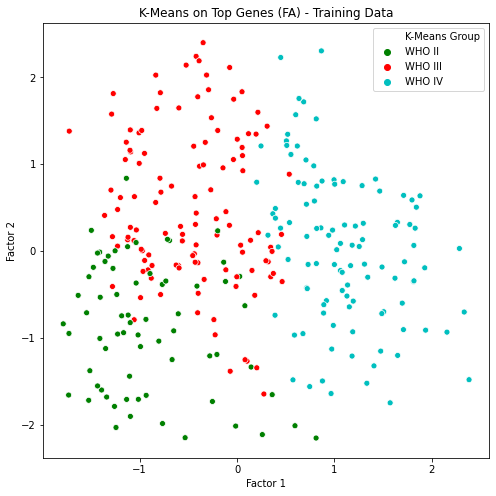

In [0]:
x = fa_top_kmeans_train['Factor 1']
y = fa_top_kmeans_train['Factor 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = fa_top_kmeans_train['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on Top Genes (FA) - Training Data")
plt.show()

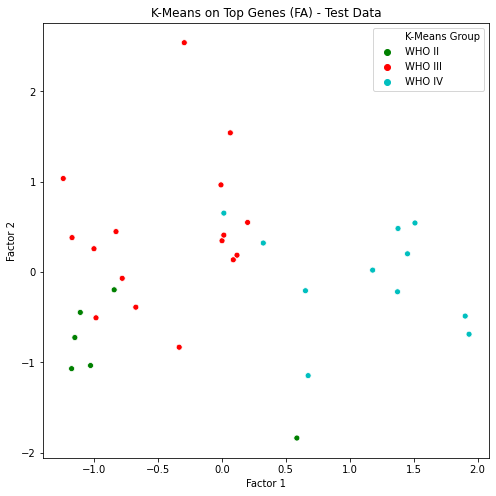

In [0]:
x = fa_top_kmeans_test['Factor 1']
y = fa_top_kmeans_test['Factor 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = fa_top_kmeans_test['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on Top Genes (FA) - Test Data")
plt.show()

### Compare Clusters to Grades

#### Visually

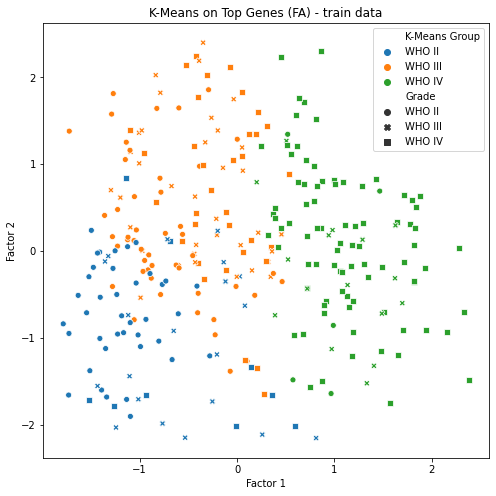

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'Factor 1', y = 'Factor 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = fa_top_kmeans_train)
plt.title("K-Means on Top Genes (FA) - train data")
plt.show()

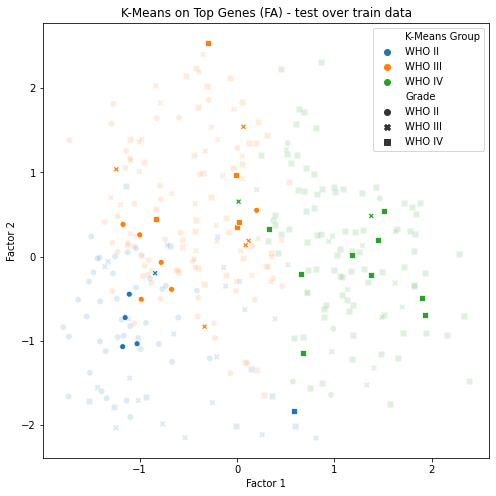

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'Factor 1', y = 'Factor 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = fa_top_kmeans_train, alpha = .15)
sb.scatterplot(x = 'Factor 1', y = 'Factor 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = fa_top_kmeans_test, legend = False)
plt.title("K-Means on Top Genes (FA) - test over train data")
plt.show()

#### Accuracy Score

In [0]:
get_accuracy(fa_top_kmeans_train['Grade'], fa_top_kmeans_train['K-Means Group'])

0.5445205479452054

In [0]:
get_accuracy(fa_top_kmeans_test['Grade'], fa_top_kmeans_test['K-Means Group'])

0.5454545454545454

## On n Sparse PCs

### Implement

In [0]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

kmeans.fit(sparse_train_genes)
test_pred = kmeans.predict(sparse_test_genes)

In [0]:
sparse_kmeans_test = pd.concat([pd.DataFrame(sparse_test), pd.DataFrame(test_pred)], axis = 1)

col_titles[:-2] = sparse_train.columns.values[:-1]
col_titles[-2:] = ['Grade', 'K-Means Group']
sparse_kmeans_test.columns = col_titles

sparse_kmeans_test = sparse_kmeans_test.replace({'K-Means Group': {0:'WHO III', 1:'WHO IV', 2:'WHO II'}})

sparse_kmeans_test.head()

,PC 1,PC 2,Grade,K-Means Group
0,37.152352,-70.491281,WHO IV,WHO III
1,8.400580,7.307506,WHO IV,WHO IV
2,-47.912547,-11.787691,WHO II,WHO II
3,-28.936388,-34.764760,WHO II,WHO II
4,-27.600268,-26.016465,WHO II,WHO II


In [0]:
sparse_kmeans_train = pd.concat([pd.DataFrame(sparse_train), pd.DataFrame(kmeans.labels_)], axis = 1)

col_titles[:-2] = sparse_train.columns.values[:-1]
col_titles[-2:] = ['Grade', 'K-Means Group']
sparse_kmeans_train.columns = col_titles

sparse_kmeans_train = sparse_kmeans_train.replace({'K-Means Group': {0:'WHO III', 1:'WHO IV', 2:'WHO II'}})

sparse_kmeans_train.head()

,PC 1,PC 2,Grade,K-Means Group
0,-36.592388,-3.616241,WHO II,WHO II
1,21.645254,8.726605,WHO IV,WHO IV
2,-32.763010,-18.839944,WHO II,WHO II
3,-7.433758,2.223518,WHO II,WHO II
4,-30.657532,-10.679793,WHO II,WHO II


### Plot clusters

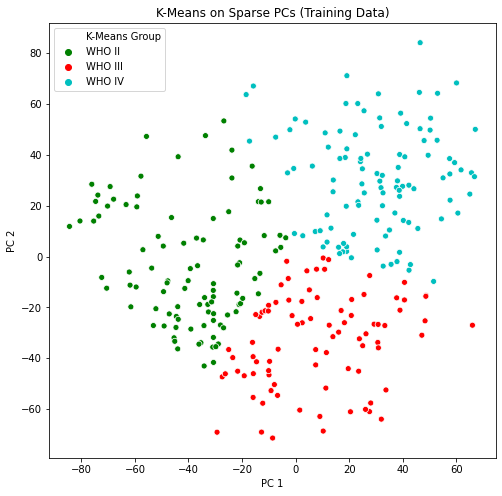

In [0]:
x = sparse_kmeans_train['PC 1']
y = sparse_kmeans_train['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = sparse_kmeans_train['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on Sparse PCs (Training Data)")
plt.show()

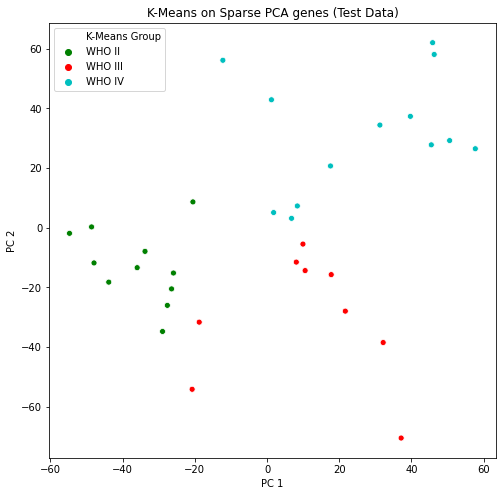

In [0]:
x = sparse_kmeans_test['PC 1']
y = sparse_kmeans_test['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = sparse_kmeans_test['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on Sparse PCA genes (Test Data)")
plt.show()

### Compare Clusters to Grades

#### Visually

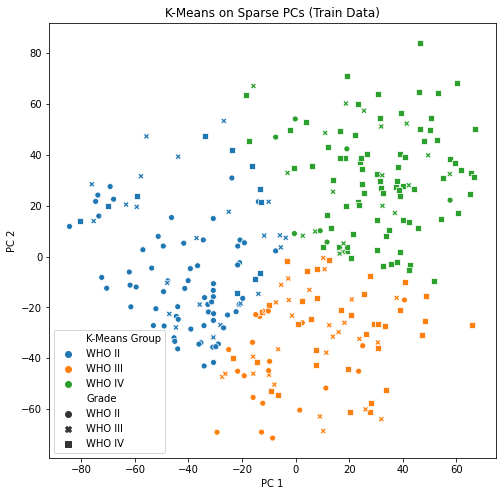

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = sparse_kmeans_train)
plt.title("K-Means on Sparse PCs (Train Data)")
plt.show()

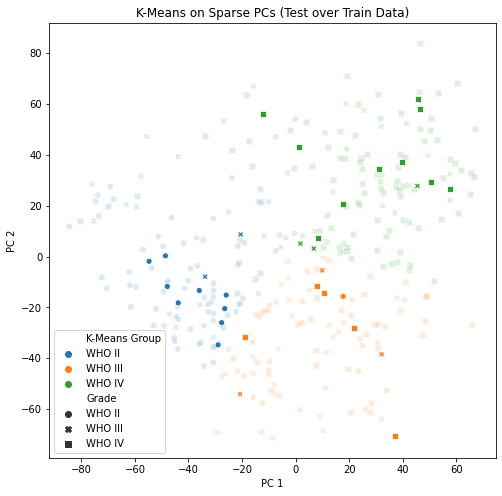

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = sparse_kmeans_train, alpha = .15)
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = sparse_kmeans_test, legend = False)
plt.title("K-Means on Sparse PCs (Test over Train Data)")
plt.show()

#### Accuracy Score

In [0]:
get_accuracy(sparse_kmeans_train['Grade'], sparse_kmeans_train['K-Means Group'])

0.5993150684931506

In [0]:
get_accuracy(sparse_kmeans_test['Grade'], sparse_kmeans_test['K-Means Group'])

0.6666666666666666

## On genes identified by Sparse PCA

### Implement

In [0]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

kmeans.fit(sparse_important_train)
test_pred = kmeans.predict(sparse_important_test)

In [0]:
sparse_top_kmeans_test = pd.concat([pd.DataFrame(sparse_test), pd.DataFrame(test_pred)], axis = 1)

col_titles[:-2] = sparse_train.columns.values[:-1]
col_titles[-2:] = ['Grade', 'K-Means Group']
sparse_top_kmeans_test.columns = col_titles

sparse_top_kmeans_test = sparse_top_kmeans_test.replace({'K-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

sparse_top_kmeans_test.head()

,PC 1,PC 2,Grade,K-Means Group
0,37.152352,-70.491281,WHO IV,WHO III
1,8.400580,7.307506,WHO IV,WHO IV
2,-47.912547,-11.787691,WHO II,WHO II
3,-28.936388,-34.764760,WHO II,WHO III
4,-27.600268,-26.016465,WHO II,WHO III


In [0]:
sparse_top_kmeans_train = pd.concat([pd.DataFrame(sparse_train), pd.DataFrame(kmeans.labels_)], axis = 1)

col_titles[:-2] = sparse_train.columns.values[:-1]
col_titles[-2:] = ['Grade', 'K-Means Group']
sparse_top_kmeans_train.columns = col_titles

sparse_top_kmeans_train = sparse_top_kmeans_train.replace({'K-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

sparse_top_kmeans_train.head()

,PC 1,PC 2,Grade,K-Means Group
0,-36.592388,-3.616241,WHO II,WHO II
1,21.645254,8.726605,WHO IV,WHO IV
2,-32.763010,-18.839944,WHO II,WHO III
3,-7.433758,2.223518,WHO II,WHO III
4,-30.657532,-10.679793,WHO II,WHO III


### Plot clusters

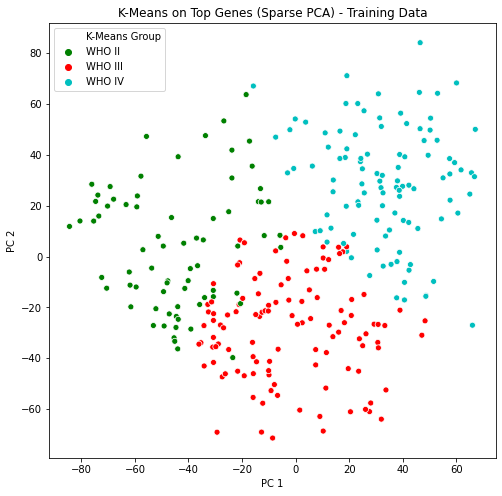

In [0]:
x = sparse_top_kmeans_train['PC 1']
y = sparse_top_kmeans_train['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = sparse_top_kmeans_train['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on Top Genes (Sparse PCA) - Training Data")
plt.show()

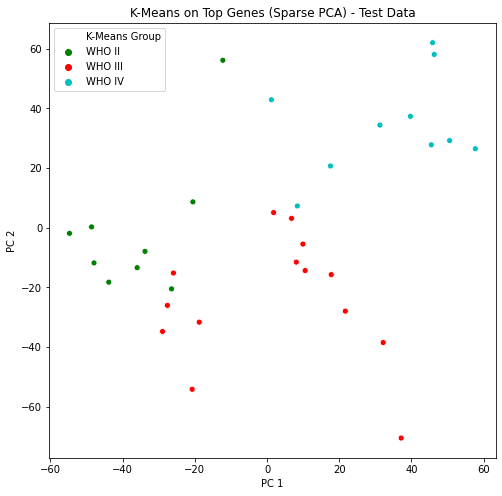

In [0]:
x = sparse_top_kmeans_test['PC 1']
y = sparse_top_kmeans_test['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = sparse_top_kmeans_test['K-Means Group'], palette = ['g', 'r', 'c'], hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("K-Means on Top Genes (Sparse PCA) - Test Data")
plt.show()

### Compare Clusters to Grades

#### Visually

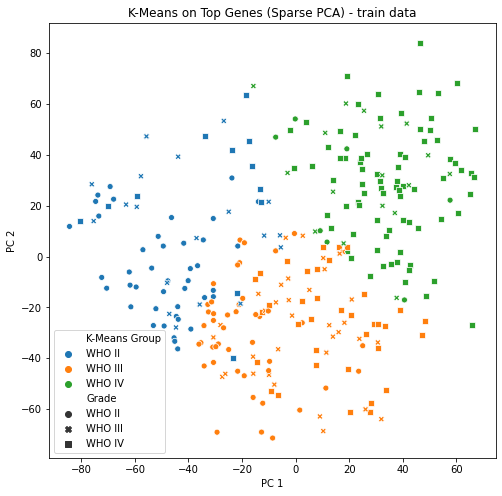

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = sparse_top_kmeans_train)
plt.title("K-Means on Top Genes (Sparse PCA) - train data")
plt.show()

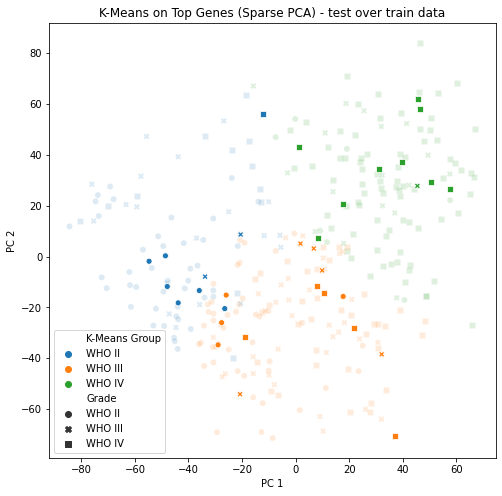

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = sparse_top_kmeans_train, alpha = .15)
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'K-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = sparse_top_kmeans_test, legend = False)
plt.title("K-Means on Top Genes (Sparse PCA) - test over train data")
plt.show()

#### Accuracy Score

In [0]:
get_accuracy(sparse_top_kmeans_train['Grade'], sparse_top_kmeans_train['K-Means Group'])

0.5376712328767124

In [0]:
get_accuracy(sparse_top_kmeans_test['Grade'], sparse_top_kmeans_test['K-Means Group'])

0.6060606060606061

# Fuzzy C-Means

## On all 8000+ genes

### Implement

In [0]:
centers, c_train, init, distance, idk, iterations, fpc_train = cmeans(train_data.T, 
                                                                c = 3, m = 2, error=0.005, 
                                                                maxiter=1000, seed = 40)
c_test, init, distance, idk, iterations, fpc_test = cmeans_predict(test_data.T,
                                                                   centers, m = 2, error = 0.005,
                                                                   maxiter = 1000, seed = 30)

In [0]:
clusters_train = pd.DataFrame(np.argmax(c_train, axis = 0))

cmeans_train = pd.concat([pd.DataFrame(pca_train_genes), pd.DataFrame(clusters_train), pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, 103)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_train.columns = col_titles

cmeans_train = cmeans_train.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

cmeans_train.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,...,PC 63,PC 64,PC 65,PC 66,PC 67,PC 68,PC 69,PC 70,PC 71,PC 72,PC 73,PC 74,PC 75,PC 76,PC 77,PC 78,PC 79,PC 80,PC 81,PC 82,PC 83,PC 84,PC 85,PC 86,PC 87,PC 88,PC 89,PC 90,PC 91,PC 92,PC 93,PC 94,PC 95,PC 96,PC 97,PC 98,PC 99,PC 100,C-Means Group,Grade
0,-33.435050,22.490684,38.097767,33.143324,-17.619483,-3.171199,20.422858,-43.082454,-8.627830,-40.189536,-5.465451,12.660921,6.473937,1.850705,17.776311,3.827960,5.569363,-7.038127,5.134618,-1.663095,-6.170663,4.012359,-1.837601,9.008581,6.178398,-7.795723,-4.336150,1.467781,-4.227110,3.907333,3.873936,-5.471964,-7.335916,-0.225879,-0.498414,2.383156,-2.361388,0.037723,-0.908430,-3.256367,...,2.803386,2.272098,-6.949592,-4.367347,3.341168,1.947714,0.368989,4.152339,-1.243948,6.176505,0.441244,3.876104,-1.597739,-1.460799,2.279836,3.711773,-4.189875,-1.905389,-0.335042,4.345799,0.330479,-0.276266,-2.592846,-1.454869,5.041591,5.734734,0.123303,0.652437,4.450397,4.326512,-0.874418,-1.986951,-2.692382,-1.379689,1.034875,-3.335310,3.982891,-3.748216,WHO II,WHO II
1,23.423648,-7.423201,-17.507606,8.792664,6.431287,18.670136,9.897008,4.258857,-5.588947,-21.095098,-0.322124,0.209306,0.053304,-8.668610,0.180721,-4.388219,-2.996144,16.387477,-4.154526,-6.628741,-1.232861,-4.223455,5.966935,2.511681,-3.733841,1.644175,11.705988,4.247669,6.254536,2.301708,4.047875,-1.748213,-5.792585,-3.768745,6.325283,-4.410534,2.398020,-8.268529,10.467071,-0.573543,...,-2.924163,8.960608,3.823409,-1.243221,-7.467617,-7.572804,10.589349,0.772206,-11.084777,2.638333,3.811274,4.791859,7.358702,1.595207,-7.155816,6.898175,-1.040545,-0.265182,-8.283871,4.145279,0.835572,6.715944,-3.471030,11.431920,-3.422275,3.884578,-0.331670,4.339098,-4.573922,-1.594635,-8.345405,-3.611264,5.372493,0.348840,1.586277,3.331050,-0.243719,5.853999,WHO IV,WHO IV
2,-40.110197,7.114937,26.472899,-2.714790,2.348762,10.846683,24.951134,-15.586976,-12.524094,-13.831167,-8.258101,3.049686,-0.538163,4.341180,2.305371,13.008403,2.597718,-4.470039,-2.298502,17.885348,8.249679,7.956260,7.983512,4.190690,-6.485299,6.298476,-5.140809,0.337568,-6.390877,-3.273234,-3.172202,2.805812,4.912493,5.161848,-1.987693,-0.899333,-5.078180,-0.617562,-0.176509,2.137058,...,4.914696,3.133128,3.798334,3.028337,-0.084716,-0.897116,0.959289,-2.269742,0.740839,-1.123870,-4.365821,-1.742024,-2.435739,3.307302,-1.834632,6.475913,1.375272,0.094449,0.035361,-2.306720,-2.782514,-2.975034,-5.741852,-2.000292,-1.551768,-0.109299,-1.936931,4.388676,-3.977612,1.910316,3.031441,-3.236150,-0.829958,0.282971,1.168424,3.326105,0.266835,1.991631,WHO II,WHO II
3,-4.322818,5.918644,3.995310,-19.628973,-7.751300,-32.174292,-13.651544,2.071658,15.121449,-6.344336,-5.886292,0.644285,14.280968,-13.589546,9.365648,4.461883,-8.266585,2.415868,8.723480,0.640381,6.564455,2.067038,-4.285749,-0.938584,4.231604,1.755127,-3.522140,1.826236,7.630807,-3.197037,-6.149750,0.346512,-2.897506,-3.820346,-1.361873,-4.142842,-7.828329,-2.262813,3.168992,5.944592,...,2.550852,-0.166442,-1.226370,-1.065782,6.247316,2.170066,4.669627,-2.872206,0.270311,-1.223580,-2.399002,0.008102,-0.680455,-5.269030,-1.359116,-2.503650,-0.514182,3.798668,-5.069770,2.514992,-2.986627,1.182284,2.554844,-1.019743,-1.606059,1.312819,0.347434,-2.273195,0.749121,-2.407184,4.828789,-1.261966,1.076348,-0.596083,-3.169724,-2.342887,2.049022,3.854297,WHO II,WHO II
4,-32.589107,10.796249,10.908327,-21.124218,-3.384025,1.144437,17.386578,-5.382837,19.263953,8.948880,2.557172,6.291258,-4.473211,8.318475,-10.763676,0.585800,-2.121526,-7.917563,-0.147576,-3.251826,-7.029230,-4.653908,1.834073,1.242064,1.823627,-0.874835,-4.370777,-1.894273,7.025319,-4.739808,4.005834,5.864892,3.790564,7.195704,-0.669111,0.070380,-2.022720,0.079781,5.210897,-1.290279,...,-2.062645,1.687858,-1.904295,-1.139900,-4.28719

In [0]:
clusters_test = pd.DataFrame(np.argmax(c_test, axis = 0))

cmeans_test = pd.concat([pd.DataFrame(pca_test_genes), pd.DataFrame(clusters_test), pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, 103)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_test.columns = col_titles

cmeans_test = cmeans_test.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

cmeans_test.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,...,PC 63,PC 64,PC 65,PC 66,PC 67,PC 68,PC 69,PC 70,PC 71,PC 72,PC 73,PC 74,PC 75,PC 76,PC 77,PC 78,PC 79,PC 80,PC 81,PC 82,PC 83,PC 84,PC 85,PC 86,PC 87,PC 88,PC 89,PC 90,PC 91,PC 92,PC 93,PC 94,PC 95,PC 96,PC 97,PC 98,PC 99,PC 100,C-Means Group,Grade
0,-17.018512,-76.678514,15.561575,3.062704,-7.722779,-8.775850,-4.664851,23.154748,0.509266,7.973678,-3.623022,5.866161,-4.550189,12.146785,-1.392219,-18.246023,6.896821,0.944526,11.384552,6.991666,12.338170,11.705946,0.708997,2.287630,-13.341123,6.993175,-10.261956,8.248515,-2.400219,-1.427749,-4.416294,1.179152,9.364390,11.176043,8.197916,0.347621,-5.342266,6.541101,9.915753,-1.131762,...,-1.568144,0.758518,1.980277,4.713281,4.851716,-5.931367,-4.419590,-1.302903,-5.505166,1.024360,-2.717740,-8.427008,8.541599,-1.745657,8.284553,-3.434737,-9.377509,-9.517866,8.774370,-2.559249,0.977984,-0.086417,1.912350,-2.874511,0.575641,-1.678528,-6.968492,3.596621,0.387272,-1.224354,4.477667,-4.144775,-2.552277,-1.567604,-1.138090,-3.252450,6.836434,0.187049,WHO II,WHO IV
1,10.671509,6.637014,61.410853,35.650647,23.106033,-2.143400,-25.585916,-1.896293,-3.161299,29.643057,20.772200,-8.631180,10.108813,-4.321810,-1.290577,12.302224,5.609744,10.251688,-11.286736,8.424100,-7.446585,0.833440,6.362327,-1.295788,-0.538751,-2.789574,-0.909597,3.487231,13.054560,9.224215,-0.364302,-0.802777,9.328509,-10.093221,-1.792623,-4.062803,1.789310,-1.835673,0.649405,4.240894,...,2.205854,-2.969950,-0.531894,2.501960,-2.282490,-0.616521,-5.275008,2.981498,-4.601314,0.469132,-3.394217,5.113290,2.023322,-1.051664,-0.371899,3.816695,-0.850683,0.229438,1.325637,-0.948086,0.219822,-5.783033,2.556722,-1.987221,-2.458668,1.409523,-2.752795,4.696642,-4.087550,2.507288,5.316961,1.223567,1.236127,-1.043795,-2.984997,-2.397036,-3.314017,0.924540,WHO IV,WHO IV
2,-47.478944,19.938839,0.775281,-5.393339,1.060002,-1.258285,18.845099,10.749346,8.432701,-1.510634,2.498965,2.215257,-3.571031,5.632856,3.777480,3.711318,-0.018851,-0.569086,-3.031431,4.688648,9.404736,-0.974123,-0.790132,0.615564,-4.147071,8.098679,1.431979,2.792576,-0.381679,-5.142564,-0.689776,2.999639,7.062379,6.517923,-4.294524,-4.471987,2.412686,-1.969096,-0.674309,5.679641,...,1.325819,1.072653,1.519531,2.222347,-3.172628,-0.909233,3.724285,-0.655441,2.266533,1.877241,-0.885325,1.589409,0.469133,2.633640,1.337861,2.052690,-1.653839,-2.518615,0.860467,-0.412610,3.996704,2.738325,-1.375810,-0.843922,0.995765,-3.157285,-2.557065,0.082646,-0.126904,0.214093,0.752416,1.038075,-1.575182,1.096215,2.445567,-0.557107,-0.759410,1.535533,WHO II,WHO II
3,-46.293701,-8.338783,-8.556460,-11.787487,7.931985,-12.844711,6.540826,-18.449559,8.280567,2.268379,6.155999,6.697884,12.438830,-3.760121,3.321463,1.446364,-10.134700,-5.682686,-2.644134,3.815761,-2.071600,7.834877,-0.859072,-0.570158,-3.168933,-0.344856,-2.032103,3.334026,-3.248693,3.036791,3.179862,-0.565128,0.365566,3.902595,-1.120040,-1.179762,-0.556647,1.268869,-1.564766,0.533795,...,2.495933,-0.372766,-0.927606,0.403050,0.726465,-0.684169,0.750278,-1.785646,-0.733537,3.459306,-0.805410,1.273227,0.250722,1.422381,1.070423,1.603022,0.121284,0.918156,-2.341091,0.902276,-2.473149,0.797977,0.554601,2.005249,0.440211,1.854731,-0.984441,0.483813,1.189386,-0.137946,1.147722,-1.115155,0.602337,-0.278470,2.430697,-0.163343,-0.634093,-0.515978,WHO II,WHO II
4,-39.708933,-1.918164,-1.080752,-5.932954,7.909142,-28.034355,4.023443,-14.541399,18.140554,-0.283957,4.532071,6.897541,6.876370,-6.633463,1.865288,2.967301,-10.198049,1.619586,-1.488168,2.531958,4.955702,6.443589,-2.912846,-0.136850,-4.473982,4.336008,-2.179830,0.619619,-1.113891,-1.565422,-3.957438,-4.143265,-1.543306,0.800459,-1.424751,-0.076890,0.131354,-0.574398,1.389086,-0.054548,...,1.942085,1.935728,-0.081159,0.762961,1.872073,-0.05

### Plot Clusters

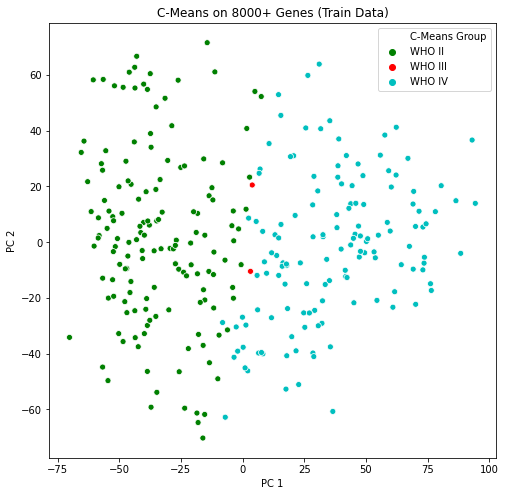

In [0]:
x = cmeans_train['PC 1']
y = cmeans_train['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_train['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on 8000+ Genes (Train Data)")
plt.show()

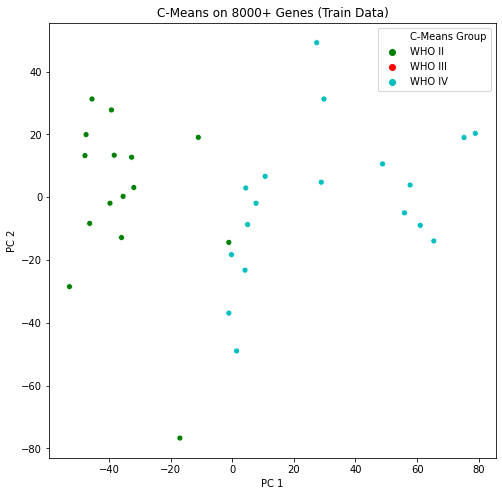

In [0]:
x = cmeans_test['PC 1']
y = cmeans_test['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_test['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on 8000+ Genes (Train Data)")
plt.show()

### Compare Clusters to Grades

#### Visually

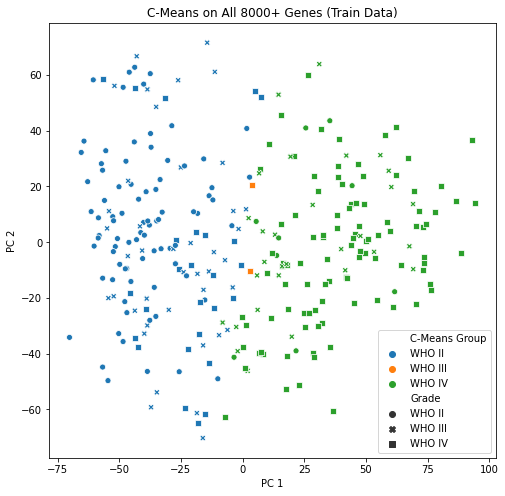

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train)
plt.title("C-Means on All 8000+ Genes (Train Data)")
plt.show()

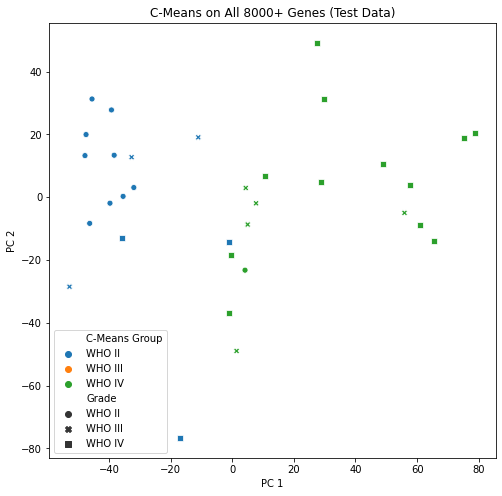

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_test)
plt.title("C-Means on All 8000+ Genes (Test Data)")
plt.show()

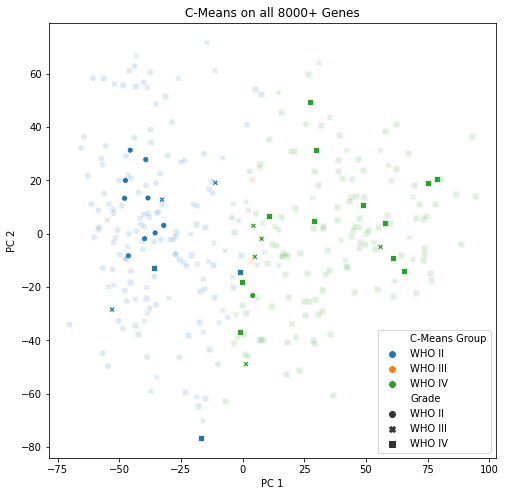

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_test)
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train, alpha = .15, legend = False)
plt.title("C-Means on all 8000+ Genes")
plt.show()

#### Accuracy Score

In [0]:
get_accuracy(cmeans_train['Grade'], cmeans_train['C-Means Group'])

0.6301369863013698

In [0]:
get_accuracy(cmeans_test['Grade'], cmeans_test['C-Means Group'])

0.6363636363636364

## On 100 PCs

### Implement

In [0]:
centers_pca, c_train_pca, init, distance, idk, iterations, fpc_train = cmeans(pca_train_genes.T, 
                                                                c = 3, m = 2, error=0.005, 
                                                                maxiter=1000, seed = 40)
c_test_pca, init, distance, idk, iterations, fpc_test = cmeans_predict(pca_test_genes.T,
                                                                   centers_pca, m = 2, error = 0.005,
                                                                   maxiter = 1000, seed = 30)

In [0]:
clusters_train_pca = pd.DataFrame(np.argmax(c_train_pca, axis = 0))

cmeans_train_pca = pd.concat([pd.DataFrame(pca_train_genes), pd.DataFrame(clusters_train_pca), pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, 103)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_train_pca.columns = col_titles

cmeans_train_pca = cmeans_train_pca.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

cmeans_train_pca.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,...,PC 63,PC 64,PC 65,PC 66,PC 67,PC 68,PC 69,PC 70,PC 71,PC 72,PC 73,PC 74,PC 75,PC 76,PC 77,PC 78,PC 79,PC 80,PC 81,PC 82,PC 83,PC 84,PC 85,PC 86,PC 87,PC 88,PC 89,PC 90,PC 91,PC 92,PC 93,PC 94,PC 95,PC 96,PC 97,PC 98,PC 99,PC 100,C-Means Group,Grade
0,-33.435050,22.490684,38.097767,33.143324,-17.619483,-3.171199,20.422858,-43.082454,-8.627830,-40.189536,-5.465451,12.660921,6.473937,1.850705,17.776311,3.827960,5.569363,-7.038127,5.134618,-1.663095,-6.170663,4.012359,-1.837601,9.008581,6.178398,-7.795723,-4.336150,1.467781,-4.227110,3.907333,3.873936,-5.471964,-7.335916,-0.225879,-0.498414,2.383156,-2.361388,0.037723,-0.908430,-3.256367,...,2.803386,2.272098,-6.949592,-4.367347,3.341168,1.947714,0.368989,4.152339,-1.243948,6.176505,0.441244,3.876104,-1.597739,-1.460799,2.279836,3.711773,-4.189875,-1.905389,-0.335042,4.345799,0.330479,-0.276266,-2.592846,-1.454869,5.041591,5.734734,0.123303,0.652437,4.450397,4.326512,-0.874418,-1.986951,-2.692382,-1.379689,1.034875,-3.335310,3.982891,-3.748216,WHO II,WHO II
1,23.423648,-7.423201,-17.507606,8.792664,6.431287,18.670136,9.897008,4.258857,-5.588947,-21.095098,-0.322124,0.209306,0.053304,-8.668610,0.180721,-4.388219,-2.996144,16.387477,-4.154526,-6.628741,-1.232861,-4.223455,5.966935,2.511681,-3.733841,1.644175,11.705988,4.247669,6.254536,2.301708,4.047875,-1.748213,-5.792585,-3.768745,6.325283,-4.410534,2.398020,-8.268529,10.467071,-0.573543,...,-2.924163,8.960608,3.823409,-1.243221,-7.467617,-7.572804,10.589349,0.772206,-11.084777,2.638333,3.811274,4.791859,7.358702,1.595207,-7.155816,6.898175,-1.040545,-0.265182,-8.283871,4.145279,0.835572,6.715944,-3.471030,11.431920,-3.422275,3.884578,-0.331670,4.339098,-4.573922,-1.594635,-8.345405,-3.611264,5.372493,0.348840,1.586277,3.331050,-0.243719,5.853999,WHO IV,WHO IV
2,-40.110197,7.114937,26.472899,-2.714790,2.348762,10.846683,24.951134,-15.586976,-12.524094,-13.831167,-8.258101,3.049686,-0.538163,4.341180,2.305371,13.008403,2.597718,-4.470039,-2.298502,17.885348,8.249679,7.956260,7.983512,4.190690,-6.485299,6.298476,-5.140809,0.337568,-6.390877,-3.273234,-3.172202,2.805812,4.912493,5.161848,-1.987693,-0.899333,-5.078180,-0.617562,-0.176509,2.137058,...,4.914696,3.133128,3.798334,3.028337,-0.084716,-0.897116,0.959289,-2.269742,0.740839,-1.123870,-4.365821,-1.742024,-2.435739,3.307302,-1.834632,6.475913,1.375272,0.094449,0.035361,-2.306720,-2.782514,-2.975034,-5.741852,-2.000292,-1.551768,-0.109299,-1.936931,4.388676,-3.977612,1.910316,3.031441,-3.236150,-0.829958,0.282971,1.168424,3.326105,0.266835,1.991631,WHO II,WHO II
3,-4.322818,5.918644,3.995310,-19.628973,-7.751300,-32.174292,-13.651544,2.071658,15.121449,-6.344336,-5.886292,0.644285,14.280968,-13.589546,9.365648,4.461883,-8.266585,2.415868,8.723480,0.640381,6.564455,2.067038,-4.285749,-0.938584,4.231604,1.755127,-3.522140,1.826236,7.630807,-3.197037,-6.149750,0.346512,-2.897506,-3.820346,-1.361873,-4.142842,-7.828329,-2.262813,3.168992,5.944592,...,2.550852,-0.166442,-1.226370,-1.065782,6.247316,2.170066,4.669627,-2.872206,0.270311,-1.223580,-2.399002,0.008102,-0.680455,-5.269030,-1.359116,-2.503650,-0.514182,3.798668,-5.069770,2.514992,-2.986627,1.182284,2.554844,-1.019743,-1.606059,1.312819,0.347434,-2.273195,0.749121,-2.407184,4.828789,-1.261966,1.076348,-0.596083,-3.169724,-2.342887,2.049022,3.854297,WHO II,WHO II
4,-32.589107,10.796249,10.908327,-21.124218,-3.384025,1.144437,17.386578,-5.382837,19.263953,8.948880,2.557172,6.291258,-4.473211,8.318475,-10.763676,0.585800,-2.121526,-7.917563,-0.147576,-3.251826,-7.029230,-4.653908,1.834073,1.242064,1.823627,-0.874835,-4.370777,-1.894273,7.025319,-4.739808,4.005834,5.864892,3.790564,7.195704,-0.669111,0.070380,-2.022720,0.079781,5.210897,-1.290279,...,-2.062645,1.687858,-1.904295,-1.139900,-4.28719

In [0]:
clusters_test_pca = pd.DataFrame(np.argmax(c_test_pca, axis = 0))

cmeans_test_pca = pd.concat([pd.DataFrame(pca_test_genes), pd.DataFrame(clusters_test_pca), 
                             pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, 103)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_test_pca.columns = col_titles

cmeans_test_pca = cmeans_test_pca.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

cmeans_test_pca.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,...,PC 63,PC 64,PC 65,PC 66,PC 67,PC 68,PC 69,PC 70,PC 71,PC 72,PC 73,PC 74,PC 75,PC 76,PC 77,PC 78,PC 79,PC 80,PC 81,PC 82,PC 83,PC 84,PC 85,PC 86,PC 87,PC 88,PC 89,PC 90,PC 91,PC 92,PC 93,PC 94,PC 95,PC 96,PC 97,PC 98,PC 99,PC 100,C-Means Group,Grade
0,-17.018512,-76.678514,15.561575,3.062704,-7.722779,-8.775850,-4.664851,23.154748,0.509266,7.973678,-3.623022,5.866161,-4.550189,12.146785,-1.392219,-18.246023,6.896821,0.944526,11.384552,6.991666,12.338170,11.705946,0.708997,2.287630,-13.341123,6.993175,-10.261956,8.248515,-2.400219,-1.427749,-4.416294,1.179152,9.364390,11.176043,8.197916,0.347621,-5.342266,6.541101,9.915753,-1.131762,...,-1.568144,0.758518,1.980277,4.713281,4.851716,-5.931367,-4.419590,-1.302903,-5.505166,1.024360,-2.717740,-8.427008,8.541599,-1.745657,8.284553,-3.434737,-9.377509,-9.517866,8.774370,-2.559249,0.977984,-0.086417,1.912350,-2.874511,0.575641,-1.678528,-6.968492,3.596621,0.387272,-1.224354,4.477667,-4.144775,-2.552277,-1.567604,-1.138090,-3.252450,6.836434,0.187049,WHO II,WHO IV
1,10.671509,6.637014,61.410853,35.650647,23.106033,-2.143400,-25.585916,-1.896293,-3.161299,29.643057,20.772200,-8.631180,10.108813,-4.321810,-1.290577,12.302224,5.609744,10.251688,-11.286736,8.424100,-7.446585,0.833440,6.362327,-1.295788,-0.538751,-2.789574,-0.909597,3.487231,13.054560,9.224215,-0.364302,-0.802777,9.328509,-10.093221,-1.792623,-4.062803,1.789310,-1.835673,0.649405,4.240894,...,2.205854,-2.969950,-0.531894,2.501960,-2.282490,-0.616521,-5.275008,2.981498,-4.601314,0.469132,-3.394217,5.113290,2.023322,-1.051664,-0.371899,3.816695,-0.850683,0.229438,1.325637,-0.948086,0.219822,-5.783033,2.556722,-1.987221,-2.458668,1.409523,-2.752795,4.696642,-4.087550,2.507288,5.316961,1.223567,1.236127,-1.043795,-2.984997,-2.397036,-3.314017,0.924540,WHO IV,WHO IV
2,-47.478944,19.938839,0.775281,-5.393339,1.060002,-1.258285,18.845099,10.749346,8.432701,-1.510634,2.498965,2.215257,-3.571031,5.632856,3.777480,3.711318,-0.018851,-0.569086,-3.031431,4.688648,9.404736,-0.974123,-0.790132,0.615564,-4.147071,8.098679,1.431979,2.792576,-0.381679,-5.142564,-0.689776,2.999639,7.062379,6.517923,-4.294524,-4.471987,2.412686,-1.969096,-0.674309,5.679641,...,1.325819,1.072653,1.519531,2.222347,-3.172628,-0.909233,3.724285,-0.655441,2.266533,1.877241,-0.885325,1.589409,0.469133,2.633640,1.337861,2.052690,-1.653839,-2.518615,0.860467,-0.412610,3.996704,2.738325,-1.375810,-0.843922,0.995765,-3.157285,-2.557065,0.082646,-0.126904,0.214093,0.752416,1.038075,-1.575182,1.096215,2.445567,-0.557107,-0.759410,1.535533,WHO II,WHO II
3,-46.293701,-8.338783,-8.556460,-11.787487,7.931985,-12.844711,6.540826,-18.449559,8.280567,2.268379,6.155999,6.697884,12.438830,-3.760121,3.321463,1.446364,-10.134700,-5.682686,-2.644134,3.815761,-2.071600,7.834877,-0.859072,-0.570158,-3.168933,-0.344856,-2.032103,3.334026,-3.248693,3.036791,3.179862,-0.565128,0.365566,3.902595,-1.120040,-1.179762,-0.556647,1.268869,-1.564766,0.533795,...,2.495933,-0.372766,-0.927606,0.403050,0.726465,-0.684169,0.750278,-1.785646,-0.733537,3.459306,-0.805410,1.273227,0.250722,1.422381,1.070423,1.603022,0.121284,0.918156,-2.341091,0.902276,-2.473149,0.797977,0.554601,2.005249,0.440211,1.854731,-0.984441,0.483813,1.189386,-0.137946,1.147722,-1.115155,0.602337,-0.278470,2.430697,-0.163343,-0.634093,-0.515978,WHO II,WHO II
4,-39.708933,-1.918164,-1.080752,-5.932954,7.909142,-28.034355,4.023443,-14.541399,18.140554,-0.283957,4.532071,6.897541,6.876370,-6.633463,1.865288,2.967301,-10.198049,1.619586,-1.488168,2.531958,4.955702,6.443589,-2.912846,-0.136850,-4.473982,4.336008,-2.179830,0.619619,-1.113891,-1.565422,-3.957438,-4.143265,-1.543306,0.800459,-1.424751,-0.076890,0.131354,-0.574398,1.389086,-0.054548,...,1.942085,1.935728,-0.081159,0.762961,1.872073,-0.05

### Plot Clusters

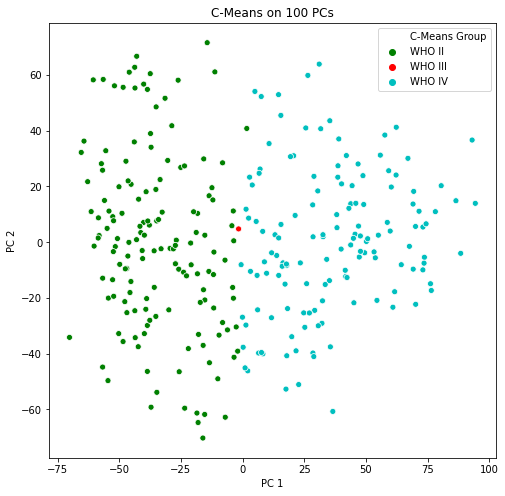

In [0]:
x = cmeans_train_pca['PC 1']
y = cmeans_train_pca['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_train_pca['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on 100 PCs")
plt.show()

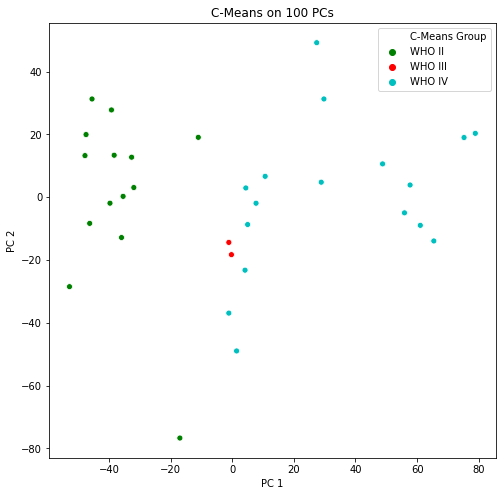

In [0]:
x = cmeans_test_pca['PC 1']
y = cmeans_test_pca['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_test_pca['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on 100 PCs")
plt.show()

### Compare Clusters to Grades

#### Visually

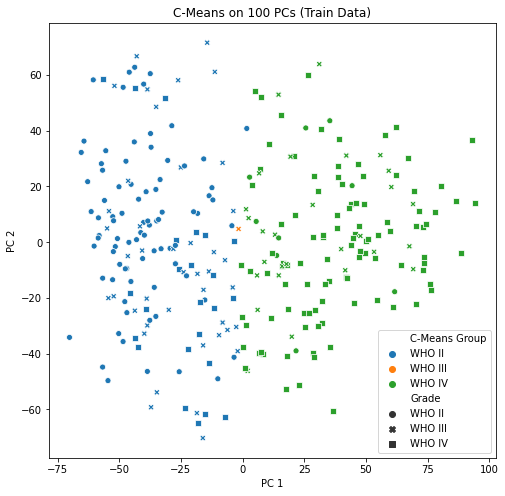

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train_pca)
plt.title("C-Means on 100 PCs (Train Data)")
plt.show()

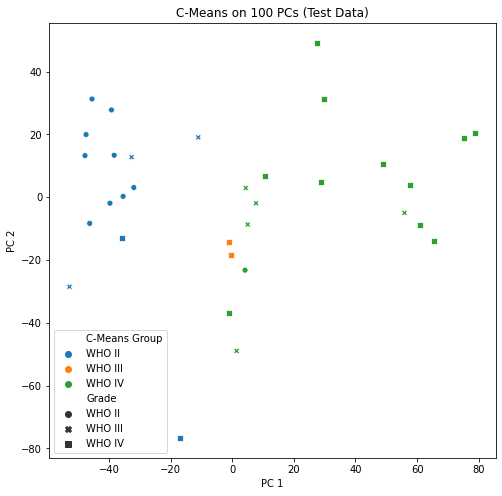

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_test_pca)
plt.title("C-Means on 100 PCs (Test Data)")
plt.show()

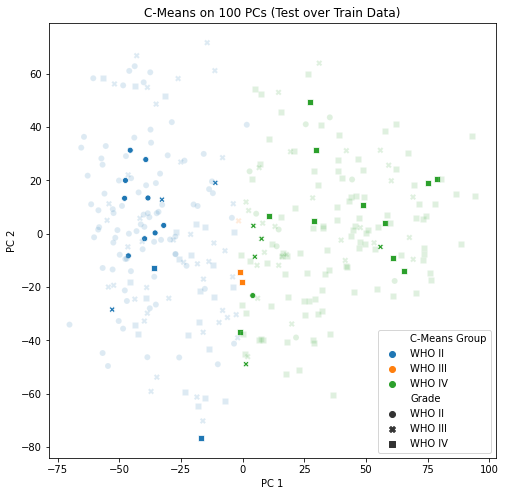

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_test_pca)
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train_pca, alpha = .15, legend = False)
plt.title("C-Means on 100 PCs (Test over Train Data)")
plt.show()

#### Accuracy Score

In [0]:
get_accuracy(cmeans_train_pca['Grade'], cmeans_train_pca['C-Means Group'])

0.6472602739726028

In [0]:
get_accuracy(cmeans_test_pca['Grade'], cmeans_test_pca['C-Means Group'])

0.6060606060606061

## On important genes identified by PCA

### Implement

In [0]:
centers_top, c_train_top, init, distance, idk, iterations, fpc_train = cmeans(important_train.T, 
                                                                c = 3, m = 2, error=0.005, 
                                                                maxiter=1000, seed = 40)
c_test_top, init, distance, idk, iterations, fpc_test = cmeans_predict(important_test.T,
                                                                   centers_top, m = 2, error = 0.005,
                                                                   maxiter = 1000, seed = 30)

In [0]:
clusters_train_top = pd.DataFrame(np.argmax(c_train_top, axis = 0))

cmeans_train_top = pd.concat([pd.DataFrame(pca_train_genes), pd.DataFrame(clusters_train_top), pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, 103)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_train_top.columns = col_titles

cmeans_train_top = cmeans_train_top.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

cmeans_train_top.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,...,PC 63,PC 64,PC 65,PC 66,PC 67,PC 68,PC 69,PC 70,PC 71,PC 72,PC 73,PC 74,PC 75,PC 76,PC 77,PC 78,PC 79,PC 80,PC 81,PC 82,PC 83,PC 84,PC 85,PC 86,PC 87,PC 88,PC 89,PC 90,PC 91,PC 92,PC 93,PC 94,PC 95,PC 96,PC 97,PC 98,PC 99,PC 100,C-Means Group,Grade
0,-33.435050,22.490684,38.097767,33.143324,-17.619483,-3.171199,20.422858,-43.082454,-8.627830,-40.189536,-5.465451,12.660921,6.473937,1.850705,17.776311,3.827960,5.569363,-7.038127,5.134618,-1.663095,-6.170663,4.012359,-1.837601,9.008581,6.178398,-7.795723,-4.336150,1.467781,-4.227110,3.907333,3.873936,-5.471964,-7.335916,-0.225879,-0.498414,2.383156,-2.361388,0.037723,-0.908430,-3.256367,...,2.803386,2.272098,-6.949592,-4.367347,3.341168,1.947714,0.368989,4.152339,-1.243948,6.176505,0.441244,3.876104,-1.597739,-1.460799,2.279836,3.711773,-4.189875,-1.905389,-0.335042,4.345799,0.330479,-0.276266,-2.592846,-1.454869,5.041591,5.734734,0.123303,0.652437,4.450397,4.326512,-0.874418,-1.986951,-2.692382,-1.379689,1.034875,-3.335310,3.982891,-3.748216,WHO II,WHO II
1,23.423648,-7.423201,-17.507606,8.792664,6.431287,18.670136,9.897008,4.258857,-5.588947,-21.095098,-0.322124,0.209306,0.053304,-8.668610,0.180721,-4.388219,-2.996144,16.387477,-4.154526,-6.628741,-1.232861,-4.223455,5.966935,2.511681,-3.733841,1.644175,11.705988,4.247669,6.254536,2.301708,4.047875,-1.748213,-5.792585,-3.768745,6.325283,-4.410534,2.398020,-8.268529,10.467071,-0.573543,...,-2.924163,8.960608,3.823409,-1.243221,-7.467617,-7.572804,10.589349,0.772206,-11.084777,2.638333,3.811274,4.791859,7.358702,1.595207,-7.155816,6.898175,-1.040545,-0.265182,-8.283871,4.145279,0.835572,6.715944,-3.471030,11.431920,-3.422275,3.884578,-0.331670,4.339098,-4.573922,-1.594635,-8.345405,-3.611264,5.372493,0.348840,1.586277,3.331050,-0.243719,5.853999,WHO IV,WHO IV
2,-40.110197,7.114937,26.472899,-2.714790,2.348762,10.846683,24.951134,-15.586976,-12.524094,-13.831167,-8.258101,3.049686,-0.538163,4.341180,2.305371,13.008403,2.597718,-4.470039,-2.298502,17.885348,8.249679,7.956260,7.983512,4.190690,-6.485299,6.298476,-5.140809,0.337568,-6.390877,-3.273234,-3.172202,2.805812,4.912493,5.161848,-1.987693,-0.899333,-5.078180,-0.617562,-0.176509,2.137058,...,4.914696,3.133128,3.798334,3.028337,-0.084716,-0.897116,0.959289,-2.269742,0.740839,-1.123870,-4.365821,-1.742024,-2.435739,3.307302,-1.834632,6.475913,1.375272,0.094449,0.035361,-2.306720,-2.782514,-2.975034,-5.741852,-2.000292,-1.551768,-0.109299,-1.936931,4.388676,-3.977612,1.910316,3.031441,-3.236150,-0.829958,0.282971,1.168424,3.326105,0.266835,1.991631,WHO II,WHO II
3,-4.322818,5.918644,3.995310,-19.628973,-7.751300,-32.174292,-13.651544,2.071658,15.121449,-6.344336,-5.886292,0.644285,14.280968,-13.589546,9.365648,4.461883,-8.266585,2.415868,8.723480,0.640381,6.564455,2.067038,-4.285749,-0.938584,4.231604,1.755127,-3.522140,1.826236,7.630807,-3.197037,-6.149750,0.346512,-2.897506,-3.820346,-1.361873,-4.142842,-7.828329,-2.262813,3.168992,5.944592,...,2.550852,-0.166442,-1.226370,-1.065782,6.247316,2.170066,4.669627,-2.872206,0.270311,-1.223580,-2.399002,0.008102,-0.680455,-5.269030,-1.359116,-2.503650,-0.514182,3.798668,-5.069770,2.514992,-2.986627,1.182284,2.554844,-1.019743,-1.606059,1.312819,0.347434,-2.273195,0.749121,-2.407184,4.828789,-1.261966,1.076348,-0.596083,-3.169724,-2.342887,2.049022,3.854297,WHO II,WHO II
4,-32.589107,10.796249,10.908327,-21.124218,-3.384025,1.144437,17.386578,-5.382837,19.263953,8.948880,2.557172,6.291258,-4.473211,8.318475,-10.763676,0.585800,-2.121526,-7.917563,-0.147576,-3.251826,-7.029230,-4.653908,1.834073,1.242064,1.823627,-0.874835,-4.370777,-1.894273,7.025319,-4.739808,4.005834,5.864892,3.790564,7.195704,-0.669111,0.070380,-2.022720,0.079781,5.210897,-1.290279,...,-2.062645,1.687858,-1.904295,-1.139900,-4.28719

In [0]:
clusters_test_top = pd.DataFrame(np.argmax(c_test_top, axis = 0))

cmeans_test_top = pd.concat([pd.DataFrame(pca_test_genes), pd.DataFrame(clusters_test_top), pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, 103)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_test_top.columns = col_titles

cmeans_test_top = cmeans_test_top.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

cmeans_test_top.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,...,PC 63,PC 64,PC 65,PC 66,PC 67,PC 68,PC 69,PC 70,PC 71,PC 72,PC 73,PC 74,PC 75,PC 76,PC 77,PC 78,PC 79,PC 80,PC 81,PC 82,PC 83,PC 84,PC 85,PC 86,PC 87,PC 88,PC 89,PC 90,PC 91,PC 92,PC 93,PC 94,PC 95,PC 96,PC 97,PC 98,PC 99,PC 100,C-Means Group,Grade
0,-17.018512,-76.678514,15.561575,3.062704,-7.722779,-8.775850,-4.664851,23.154748,0.509266,7.973678,-3.623022,5.866161,-4.550189,12.146785,-1.392219,-18.246023,6.896821,0.944526,11.384552,6.991666,12.338170,11.705946,0.708997,2.287630,-13.341123,6.993175,-10.261956,8.248515,-2.400219,-1.427749,-4.416294,1.179152,9.364390,11.176043,8.197916,0.347621,-5.342266,6.541101,9.915753,-1.131762,...,-1.568144,0.758518,1.980277,4.713281,4.851716,-5.931367,-4.419590,-1.302903,-5.505166,1.024360,-2.717740,-8.427008,8.541599,-1.745657,8.284553,-3.434737,-9.377509,-9.517866,8.774370,-2.559249,0.977984,-0.086417,1.912350,-2.874511,0.575641,-1.678528,-6.968492,3.596621,0.387272,-1.224354,4.477667,-4.144775,-2.552277,-1.567604,-1.138090,-3.252450,6.836434,0.187049,WHO II,WHO IV
1,10.671509,6.637014,61.410853,35.650647,23.106033,-2.143400,-25.585916,-1.896293,-3.161299,29.643057,20.772200,-8.631180,10.108813,-4.321810,-1.290577,12.302224,5.609744,10.251688,-11.286736,8.424100,-7.446585,0.833440,6.362327,-1.295788,-0.538751,-2.789574,-0.909597,3.487231,13.054560,9.224215,-0.364302,-0.802777,9.328509,-10.093221,-1.792623,-4.062803,1.789310,-1.835673,0.649405,4.240894,...,2.205854,-2.969950,-0.531894,2.501960,-2.282490,-0.616521,-5.275008,2.981498,-4.601314,0.469132,-3.394217,5.113290,2.023322,-1.051664,-0.371899,3.816695,-0.850683,0.229438,1.325637,-0.948086,0.219822,-5.783033,2.556722,-1.987221,-2.458668,1.409523,-2.752795,4.696642,-4.087550,2.507288,5.316961,1.223567,1.236127,-1.043795,-2.984997,-2.397036,-3.314017,0.924540,WHO IV,WHO IV
2,-47.478944,19.938839,0.775281,-5.393339,1.060002,-1.258285,18.845099,10.749346,8.432701,-1.510634,2.498965,2.215257,-3.571031,5.632856,3.777480,3.711318,-0.018851,-0.569086,-3.031431,4.688648,9.404736,-0.974123,-0.790132,0.615564,-4.147071,8.098679,1.431979,2.792576,-0.381679,-5.142564,-0.689776,2.999639,7.062379,6.517923,-4.294524,-4.471987,2.412686,-1.969096,-0.674309,5.679641,...,1.325819,1.072653,1.519531,2.222347,-3.172628,-0.909233,3.724285,-0.655441,2.266533,1.877241,-0.885325,1.589409,0.469133,2.633640,1.337861,2.052690,-1.653839,-2.518615,0.860467,-0.412610,3.996704,2.738325,-1.375810,-0.843922,0.995765,-3.157285,-2.557065,0.082646,-0.126904,0.214093,0.752416,1.038075,-1.575182,1.096215,2.445567,-0.557107,-0.759410,1.535533,WHO II,WHO II
3,-46.293701,-8.338783,-8.556460,-11.787487,7.931985,-12.844711,6.540826,-18.449559,8.280567,2.268379,6.155999,6.697884,12.438830,-3.760121,3.321463,1.446364,-10.134700,-5.682686,-2.644134,3.815761,-2.071600,7.834877,-0.859072,-0.570158,-3.168933,-0.344856,-2.032103,3.334026,-3.248693,3.036791,3.179862,-0.565128,0.365566,3.902595,-1.120040,-1.179762,-0.556647,1.268869,-1.564766,0.533795,...,2.495933,-0.372766,-0.927606,0.403050,0.726465,-0.684169,0.750278,-1.785646,-0.733537,3.459306,-0.805410,1.273227,0.250722,1.422381,1.070423,1.603022,0.121284,0.918156,-2.341091,0.902276,-2.473149,0.797977,0.554601,2.005249,0.440211,1.854731,-0.984441,0.483813,1.189386,-0.137946,1.147722,-1.115155,0.602337,-0.278470,2.430697,-0.163343,-0.634093,-0.515978,WHO II,WHO II
4,-39.708933,-1.918164,-1.080752,-5.932954,7.909142,-28.034355,4.023443,-14.541399,18.140554,-0.283957,4.532071,6.897541,6.876370,-6.633463,1.865288,2.967301,-10.198049,1.619586,-1.488168,2.531958,4.955702,6.443589,-2.912846,-0.136850,-4.473982,4.336008,-2.179830,0.619619,-1.113891,-1.565422,-3.957438,-4.143265,-1.543306,0.800459,-1.424751,-0.076890,0.131354,-0.574398,1.389086,-0.054548,...,1.942085,1.935728,-0.081159,0.762961,1.872073,-0.05

### Plot Clusters

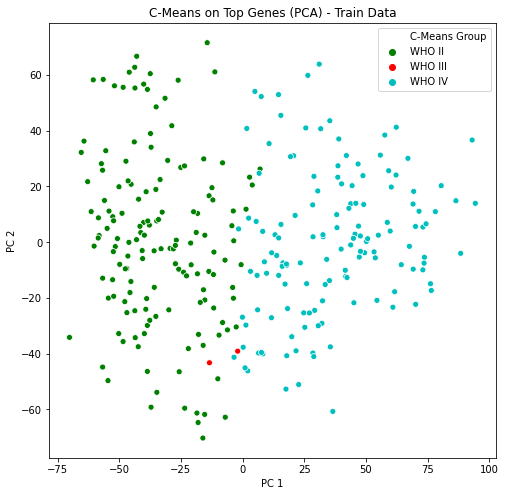

In [0]:
x = cmeans_train_top['PC 1']
y = cmeans_train_top['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_train_top['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on Top Genes (PCA) - Train Data")
plt.show()

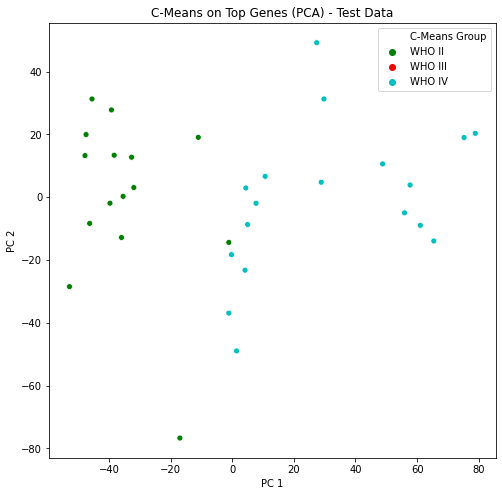

In [0]:
x = cmeans_test['PC 1']
y = cmeans_test['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_test['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on Top Genes (PCA) - Test Data")
plt.show()

### Compare Clusters to Grades

#### Visually

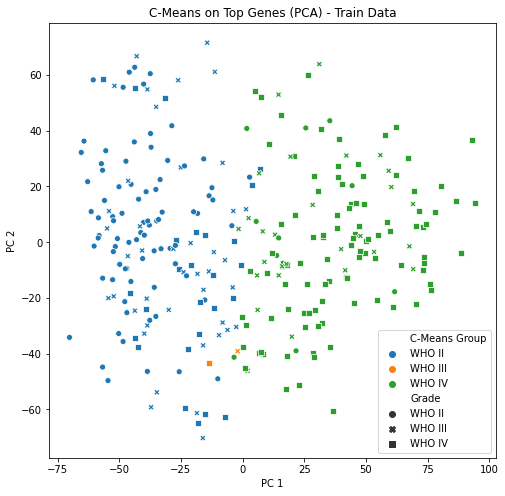

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train_top)
plt.title("C-Means on Top Genes (PCA) - Train Data")
plt.show()

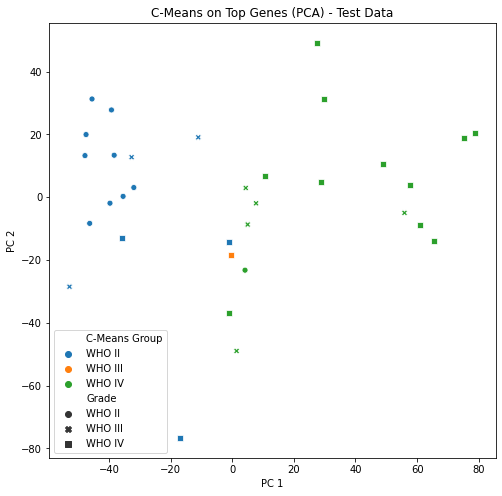

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_test_top)
plt.title("C-Means on Top Genes (PCA) - Test Data")
plt.show()

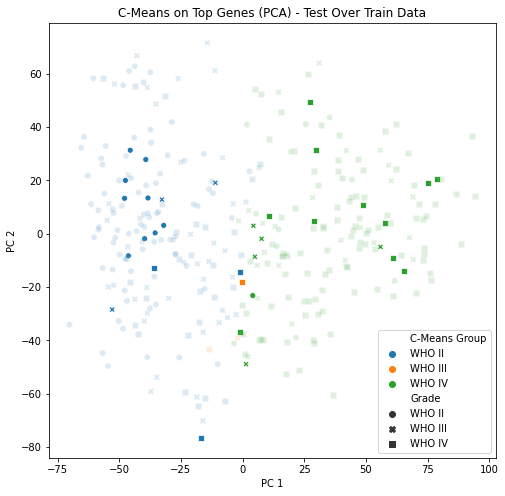

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_test_top)
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train_top, alpha = .15, legend = False)
plt.title("C-Means on Top Genes (PCA) - Test Over Train Data")
plt.show()

#### Accuracy Score

In [0]:
get_accuracy(cmeans_train_top['Grade'], cmeans_train_top['C-Means Group'])

0.6335616438356164

In [0]:
get_accuracy(cmeans_test_top['Grade'], cmeans_test_top['C-Means Group'])

0.6060606060606061

## On 100 Factors

### Implement

In [0]:
centers_fa, c_train_fa, init, distance, idk, iterations, fpc_train = cmeans(fa_train_genes.T, 
                                                                c = 3, m = 2, error=0.005, 
                                                                maxiter=1000, seed = 40)
c_test_fa, init, distance, idk, iterations, fpc_test = cmeans_predict(fa_test_genes.T,
                                                                   centers_fa, m = 2, error = 0.005,
                                                                   maxiter = 1000, seed = 30)

In [0]:
clusters_train_fa = pd.DataFrame(np.argmax(c_train_fa, axis = 0))

cmeans_train_fa = pd.concat([pd.DataFrame(fa_train_genes), pd.DataFrame(clusters_train_fa), pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'Factor {x}' for x in range(1, 103)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_train_fa.columns = col_titles

cmeans_train_fa = cmeans_train_fa.replace({'C-Means Group': {2:'WHO III', 0:'WHO IV', 1:'WHO II'}})

cmeans_train_fa.head()

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15,Factor 16,Factor 17,Factor 18,Factor 19,Factor 20,Factor 21,Factor 22,Factor 23,Factor 24,Factor 25,Factor 26,Factor 27,Factor 28,Factor 29,Factor 30,Factor 31,Factor 32,Factor 33,Factor 34,Factor 35,Factor 36,Factor 37,Factor 38,Factor 39,Factor 40,...,Factor 63,Factor 64,Factor 65,Factor 66,Factor 67,Factor 68,Factor 69,Factor 70,Factor 71,Factor 72,Factor 73,Factor 74,Factor 75,Factor 76,Factor 77,Factor 78,Factor 79,Factor 80,Factor 81,Factor 82,Factor 83,Factor 84,Factor 85,Factor 86,Factor 87,Factor 88,Factor 89,Factor 90,Factor 91,Factor 92,Factor 93,Factor 94,Factor 95,Factor 96,Factor 97,Factor 98,Factor 99,Factor 100,C-Means Group,Grade
0,-0.767871,-0.385531,0.115836,2.388345,-0.383484,-0.467369,0.561467,-2.350664,0.418821,3.973832,1.393458,0.537795,-1.186955,0.241165,-2.461988,-0.384562,-0.998326,0.576849,1.282513,0.930144,-1.114290,-0.555400,0.582111,-1.286940,-0.756003,-0.851512,0.500168,-0.302530,-1.151444,1.133120,0.066960,-0.897220,0.713943,0.469944,0.523972,0.829169,-0.259754,0.334612,0.638612,0.837120,...,0.667772,-0.687835,-1.093906,0.663421,1.777082,0.403360,1.039033,0.014080,0.939824,-0.798166,-0.012489,-1.292066,-1.089388,0.435321,1.080004,-0.580681,0.193973,-0.696573,0.209947,1.181998,1.581319,0.001383,-0.257150,0.536074,0.311319,0.998915,-0.095354,2.095175,0.483481,0.344128,1.088099,-1.533397,0.904053,-0.544323,-2.056798,1.683718,-0.716638,-0.717733,WHO II,WHO II
1,0.539117,0.327107,0.852022,-0.332517,-0.004732,0.745542,0.420696,0.905649,-0.866477,1.996034,0.113299,-0.303487,-0.368289,-0.738100,-0.355224,-0.306828,1.579579,-0.624290,-0.943939,-0.140500,-0.371726,1.095854,-0.376742,-0.131920,1.156971,0.019174,0.526034,1.989616,1.022750,0.108739,-0.671821,-0.700076,0.210346,0.400768,-0.186391,-1.013761,1.210125,0.822048,-0.608654,0.412536,...,-1.716859,0.398347,0.363219,0.184676,-0.871169,2.087683,-2.375473,4.507718,0.359282,0.120722,-1.184790,-1.131110,0.596269,-1.417280,3.027256,-1.059554,-1.926482,-1.727431,0.575586,-1.020027,-0.035904,-0.445189,0.958550,1.122069,-1.147704,1.916830,0.175825,-1.755637,-0.108784,0.047249,-2.818945,2.346825,-2.154707,-0.128855,-1.230194,0.923162,-1.032598,0.883319,WHO II,WHO IV
2,-0.914146,-0.218124,-0.782675,1.019773,0.375657,0.519532,0.913710,-1.079186,-0.907992,1.785236,0.315228,0.503691,-0.523415,0.600933,-0.377421,1.659806,0.111216,-0.507630,0.373521,1.309040,2.158432,-0.649656,2.112633,-0.537144,-0.300375,0.304272,-1.232271,-0.303918,-0.466015,-0.998909,0.478124,0.124541,-0.578029,-0.843605,0.154575,0.143870,-0.867417,-0.063425,0.102344,-0.828719,...,-0.342601,-1.091383,0.584348,0.084750,-0.297700,0.573446,-0.372649,0.069827,-0.060793,0.694590,1.544628,1.004739,1.563913,-0.019049,0.554957,0.060621,-0.619902,0.381322,0.727567,-0.004370,-0.079075,1.533853,-0.318394,0.100634,-0.178083,-0.220553,0.727758,-1.449127,0.138948,0.788301,0.348312,0.520673,1.320611,-0.702829,-0.331891,-0.452675,-0.783852,-0.367775,WHO IV,WHO II
3,-0.010240,-0.408593,-1.194213,-0.386557,0.003723,-1.695766,-0.276458,0.752302,1.858447,-0.038924,-0.494421,-0.505349,-1.804313,-0.779621,-1.425660,0.286663,0.260123,1.654794,-0.879751,-0.318515,0.663504,-0.573909,-0.654317,0.076841,-1.708391,-1.136160,-0.360114,0.521692,0.938267,-0.223938,-0.616241,-0.095428,-0.039779,1.251148,-0.454566,0.253899,-1.674527,0.542885,-0.161628,-0.132685,...,0.414760,-1.054944,-0.810270,0.392132,0.229581,-0.028218,1.044777,0.852055,-0.145478,0.086758,-0.776033,0.473123,0.725105,0.000560,0.576832,-0.573361,-0.678358,1.069336,-0.443874,1.552338,-0.308504,-0.923042,-1.355427,0.088791,0.648256,-0.374091,-0.184248,-0.618326,-0.348110,1.108395,-0.278188,-0.167396,-0.417089,-0.212686,0.996606,0.270324,0.030926,0.107322,WHO III,WHO II
4,-0.785148,-0.501948,-1.059175,-0.116568,-0.353897,1.322514,1.409249,-0.578670,0.985555,-0.809191,0.794120,0.010905,0.750028,0.052386,0.721943,0.340907,-1.09

In [0]:
clusters_test_fa = pd.DataFrame(np.argmax(c_test_fa, axis = 0))

cmeans_test_fa = pd.concat([pd.DataFrame(fa_test_genes), pd.DataFrame(clusters_test_fa), 
                             pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'Factor {x}' for x in range(1, 103)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_test_fa.columns = col_titles

cmeans_test_fa = cmeans_test_fa.replace({'C-Means Group': {2:'WHO III', 0:'WHO IV', 1:'WHO II'}})

cmeans_test_fa.head()

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15,Factor 16,Factor 17,Factor 18,Factor 19,Factor 20,Factor 21,Factor 22,Factor 23,Factor 24,Factor 25,Factor 26,Factor 27,Factor 28,Factor 29,Factor 30,Factor 31,Factor 32,Factor 33,Factor 34,Factor 35,Factor 36,Factor 37,Factor 38,Factor 39,Factor 40,...,Factor 63,Factor 64,Factor 65,Factor 66,Factor 67,Factor 68,Factor 69,Factor 70,Factor 71,Factor 72,Factor 73,Factor 74,Factor 75,Factor 76,Factor 77,Factor 78,Factor 79,Factor 80,Factor 81,Factor 82,Factor 83,Factor 84,Factor 85,Factor 86,Factor 87,Factor 88,Factor 89,Factor 90,Factor 91,Factor 92,Factor 93,Factor 94,Factor 95,Factor 96,Factor 97,Factor 98,Factor 99,Factor 100,C-Means Group,Grade
0,-0.293440,2.538886,-0.681511,0.568800,-0.486379,-0.779511,0.319821,1.345924,-0.322250,-1.543843,0.583401,1.232805,1.015854,0.371118,0.726277,-1.793935,0.595507,1.381473,0.146248,-0.627867,1.816056,-1.514732,1.279376,-0.541915,-0.503033,0.677510,-2.602009,0.990409,-1.203804,-1.624827,1.442395,0.003285,-0.806711,-2.130532,-0.922185,1.211113,0.675092,0.930663,-0.030370,0.327993,...,0.181058,1.941298,-2.222015,-0.918663,-1.127551,0.955807,-0.755799,0.019922,3.750914,-0.136771,2.480472,1.341996,1.514001,-1.479348,-2.774186,2.167005,1.845020,-0.688455,-1.843069,-0.394638,2.116943,-0.407150,0.818184,-0.816016,0.064942,0.986092,0.205071,1.520231,-0.337685,-1.020581,-0.319427,-2.768241,0.609570,0.387526,-0.541136,0.203349,0.843216,-0.207020,WHO III,WHO IV
1,0.324620,0.320905,-0.001379,3.038895,1.789471,0.165920,-2.021166,-1.015364,0.394811,-2.838859,-0.892280,-2.068333,0.330254,0.075194,-0.361176,0.709951,1.915603,-1.290557,-0.529883,1.427255,-0.678221,0.282330,0.281810,0.989438,0.133487,-0.813798,0.024551,1.098699,1.331911,-0.247413,1.089651,1.520390,2.552489,0.659972,0.443962,-1.244502,-0.129881,-0.534517,-0.642364,-0.998721,...,-1.190419,0.839269,-0.432565,-0.610082,0.100808,-0.780341,-1.514881,0.213097,0.493203,-1.221235,0.915697,0.513288,0.614149,-0.283112,0.548249,-0.632030,1.084227,0.111545,1.039633,-0.012621,0.441137,0.886790,-0.718504,-1.305706,0.202242,-0.760016,1.094748,-0.414678,0.618624,-0.250067,-0.622165,-0.176920,1.646883,-1.226587,0.509953,0.791242,-0.390949,-0.668325,WHO IV,WHO IV
2,-1.149085,-0.725466,-0.161190,0.100292,-0.135751,0.447639,1.397324,0.732199,0.198626,-0.174552,0.252575,0.098434,-0.201954,1.109297,-0.362313,0.611463,0.252529,-0.328643,0.187580,-0.351575,1.453071,-0.282818,0.086284,-0.131108,-0.075098,0.546457,-0.347318,0.404466,0.175415,-0.935541,0.697452,0.543868,-1.326968,-0.798311,0.110845,-1.492511,-0.294801,0.442117,-0.170704,-1.192030,...,-0.183156,-0.440594,0.938233,-0.046092,-0.661072,0.329273,-0.586578,0.515794,-0.039014,0.324517,0.114069,-0.110840,0.209480,-0.006129,-0.641516,0.481802,0.213864,0.377849,0.004588,-0.405983,-0.021938,1.210337,0.795871,-0.848095,0.590221,0.391976,-0.268752,-0.157662,-0.176234,0.056113,-0.188803,-0.267155,0.447616,-0.704491,0.614786,0.263612,0.665294,-0.383083,WHO III,WHO II
3,-1.171114,0.380817,-0.509393,-0.778159,0.568190,0.228791,0.408663,-1.304155,0.910656,-0.400083,0.108526,-0.780755,-0.610037,-0.624102,-1.455385,0.215294,-1.350310,-0.298107,-0.909006,0.128485,-0.005939,-1.041672,0.504513,0.006271,0.233487,0.173494,-0.586015,0.290266,-0.825464,0.271224,0.395707,-0.256013,0.119838,-0.852398,0.395025,-0.068228,-0.552795,-0.170839,0.146349,-0.367205,...,0.171287,-0.204903,0.103397,-0.068474,0.006126,-0.111813,0.439918,0.409053,0.541837,-0.766683,-0.208610,0.150967,0.201722,0.477650,0.570681,-0.450848,-0.179122,-0.210300,-0.046033,-0.044556,-0.177725,-0.080124,-0.229516,0.140195,0.034021,0.122877,0.360044,0.347633,0.132775,0.123528,0.107490,0.339592,-0.311282,0.034030,-0.348044,0.098321,-0.154382,-0.752504,WHO II,WHO II
4,-0.999554,0.257892,-0.399793,-0.399037,0.653508,-0.356721,0.683092,-0.835377,2.041559,-0.493432,0.701805,-0.706554,-1.159834,-0.390775,-0.939134,0.467496,-0.0028

### Plot Clusters

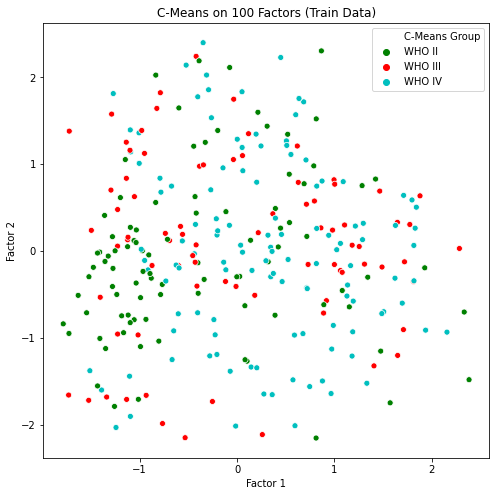

In [0]:
x = cmeans_train_fa['Factor 1']
y = cmeans_train_fa['Factor 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_train_fa['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on 100 Factors (Train Data)")
plt.show()

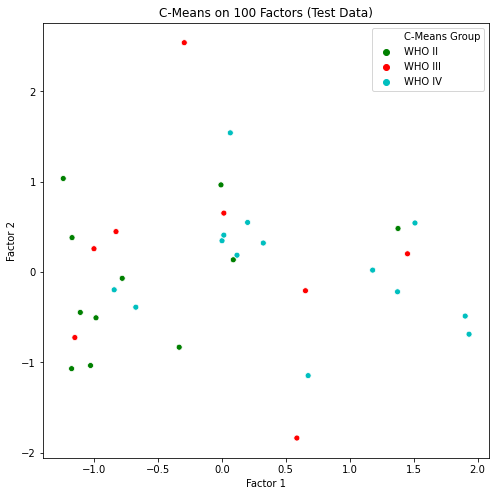

In [0]:
x = cmeans_test_fa['Factor 1']
y = cmeans_test_fa['Factor 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_test_fa['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on 100 Factors (Test Data)")
plt.show()

### Compare Clusters to Grades

#### Visually

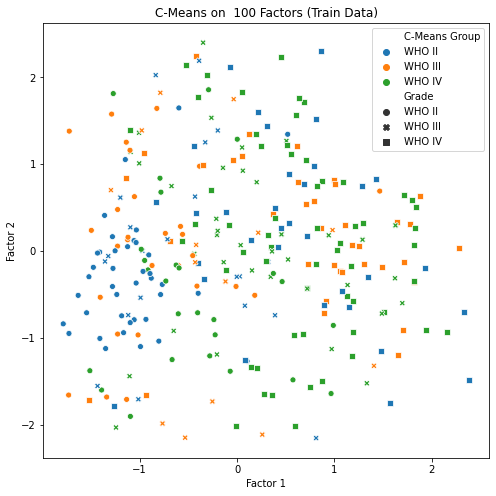

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'Factor 1', y = 'Factor 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train_fa)
plt.title("C-Means on  100 Factors (Train Data)")
plt.show()

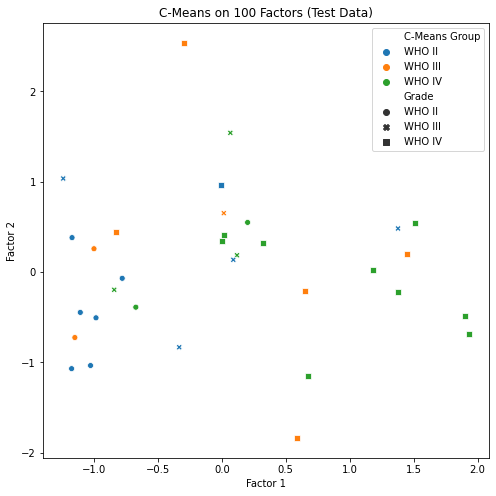

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'Factor 1', y = 'Factor 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_test_fa)
plt.title("C-Means on 100 Factors (Test Data)")
plt.show()

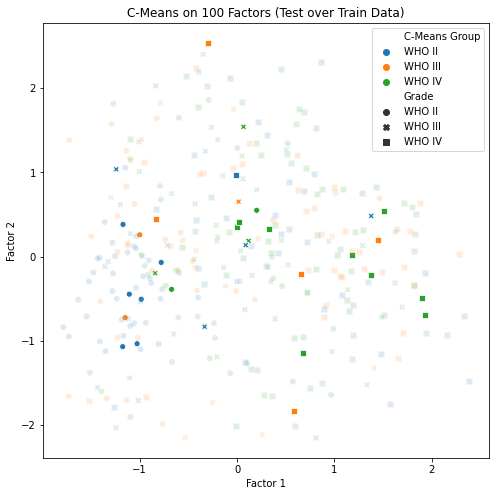

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'Factor 1', y = 'Factor 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_test_fa)
sb.scatterplot(x = 'Factor 1', y = 'Factor 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train_fa, alpha = .15, legend = False)
plt.title("C-Means on 100 Factors (Test over Train Data)")
plt.show()

#### Accuracy Score

In [0]:
get_accuracy(cmeans_train_fa['Grade'], cmeans_train_fa['C-Means Group'])

0.3801369863013699

In [0]:
get_accuracy(cmeans_test_fa['Grade'], cmeans_test_fa['C-Means Group'])

0.48484848484848486

## On important genes identified by FA

### Implement

In [0]:
centers_top_fa, c_train_top_fa, init, distance, idk, iterations, fpc_train = cmeans(fa_important_train.T, 
                                                                c = 3, m = 2, error=0.005, 
                                                                maxiter=1000, seed = 40)
c_test_top_fa, init, distance, idk, iterations, fpc_test = cmeans_predict(fa_important_test.T,
                                                                   centers_top_fa, m = 2, error = 0.005,
                                                                   maxiter = 1000, seed = 30)

In [0]:
clusters_train_top_fa = pd.DataFrame(np.argmax(c_train_top_fa, axis = 0))

cmeans_train_top_fa = pd.concat([pd.DataFrame(fa_train_genes), pd.DataFrame(clusters_train_top_fa), pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'Factor {x}' for x in range(1, 103)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_train_top_fa.columns = col_titles

cmeans_train_top_fa = cmeans_train_top_fa.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

cmeans_train_top_fa.head()

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15,Factor 16,Factor 17,Factor 18,Factor 19,Factor 20,Factor 21,Factor 22,Factor 23,Factor 24,Factor 25,Factor 26,Factor 27,Factor 28,Factor 29,Factor 30,Factor 31,Factor 32,Factor 33,Factor 34,Factor 35,Factor 36,Factor 37,Factor 38,Factor 39,Factor 40,...,Factor 63,Factor 64,Factor 65,Factor 66,Factor 67,Factor 68,Factor 69,Factor 70,Factor 71,Factor 72,Factor 73,Factor 74,Factor 75,Factor 76,Factor 77,Factor 78,Factor 79,Factor 80,Factor 81,Factor 82,Factor 83,Factor 84,Factor 85,Factor 86,Factor 87,Factor 88,Factor 89,Factor 90,Factor 91,Factor 92,Factor 93,Factor 94,Factor 95,Factor 96,Factor 97,Factor 98,Factor 99,Factor 100,C-Means Group,Grade
0,-0.767871,-0.385531,0.115836,2.388345,-0.383484,-0.467369,0.561467,-2.350664,0.418821,3.973832,1.393458,0.537795,-1.186955,0.241165,-2.461988,-0.384562,-0.998326,0.576849,1.282513,0.930144,-1.114290,-0.555400,0.582111,-1.286940,-0.756003,-0.851512,0.500168,-0.302530,-1.151444,1.133120,0.066960,-0.897220,0.713943,0.469944,0.523972,0.829169,-0.259754,0.334612,0.638612,0.837120,...,0.667772,-0.687835,-1.093906,0.663421,1.777082,0.403360,1.039033,0.014080,0.939824,-0.798166,-0.012489,-1.292066,-1.089388,0.435321,1.080004,-0.580681,0.193973,-0.696573,0.209947,1.181998,1.581319,0.001383,-0.257150,0.536074,0.311319,0.998915,-0.095354,2.095175,0.483481,0.344128,1.088099,-1.533397,0.904053,-0.544323,-2.056798,1.683718,-0.716638,-0.717733,WHO II,WHO II
1,0.539117,0.327107,0.852022,-0.332517,-0.004732,0.745542,0.420696,0.905649,-0.866477,1.996034,0.113299,-0.303487,-0.368289,-0.738100,-0.355224,-0.306828,1.579579,-0.624290,-0.943939,-0.140500,-0.371726,1.095854,-0.376742,-0.131920,1.156971,0.019174,0.526034,1.989616,1.022750,0.108739,-0.671821,-0.700076,0.210346,0.400768,-0.186391,-1.013761,1.210125,0.822048,-0.608654,0.412536,...,-1.716859,0.398347,0.363219,0.184676,-0.871169,2.087683,-2.375473,4.507718,0.359282,0.120722,-1.184790,-1.131110,0.596269,-1.417280,3.027256,-1.059554,-1.926482,-1.727431,0.575586,-1.020027,-0.035904,-0.445189,0.958550,1.122069,-1.147704,1.916830,0.175825,-1.755637,-0.108784,0.047249,-2.818945,2.346825,-2.154707,-0.128855,-1.230194,0.923162,-1.032598,0.883319,WHO IV,WHO IV
2,-0.914146,-0.218124,-0.782675,1.019773,0.375657,0.519532,0.913710,-1.079186,-0.907992,1.785236,0.315228,0.503691,-0.523415,0.600933,-0.377421,1.659806,0.111216,-0.507630,0.373521,1.309040,2.158432,-0.649656,2.112633,-0.537144,-0.300375,0.304272,-1.232271,-0.303918,-0.466015,-0.998909,0.478124,0.124541,-0.578029,-0.843605,0.154575,0.143870,-0.867417,-0.063425,0.102344,-0.828719,...,-0.342601,-1.091383,0.584348,0.084750,-0.297700,0.573446,-0.372649,0.069827,-0.060793,0.694590,1.544628,1.004739,1.563913,-0.019049,0.554957,0.060621,-0.619902,0.381322,0.727567,-0.004370,-0.079075,1.533853,-0.318394,0.100634,-0.178083,-0.220553,0.727758,-1.449127,0.138948,0.788301,0.348312,0.520673,1.320611,-0.702829,-0.331891,-0.452675,-0.783852,-0.367775,WHO II,WHO II
3,-0.010240,-0.408593,-1.194213,-0.386557,0.003723,-1.695766,-0.276458,0.752302,1.858447,-0.038924,-0.494421,-0.505349,-1.804313,-0.779621,-1.425660,0.286663,0.260123,1.654794,-0.879751,-0.318515,0.663504,-0.573909,-0.654317,0.076841,-1.708391,-1.136160,-0.360114,0.521692,0.938267,-0.223938,-0.616241,-0.095428,-0.039779,1.251148,-0.454566,0.253899,-1.674527,0.542885,-0.161628,-0.132685,...,0.414760,-1.054944,-0.810270,0.392132,0.229581,-0.028218,1.044777,0.852055,-0.145478,0.086758,-0.776033,0.473123,0.725105,0.000560,0.576832,-0.573361,-0.678358,1.069336,-0.443874,1.552338,-0.308504,-0.923042,-1.355427,0.088791,0.648256,-0.374091,-0.184248,-0.618326,-0.348110,1.108395,-0.278188,-0.167396,-0.417089,-0.212686,0.996606,0.270324,0.030926,0.107322,WHO II,WHO II
4,-0.785148,-0.501948,-1.059175,-0.116568,-0.353897,1.322514,1.409249,-0.578670,0.985555,-0.809191,0.794120,0.010905,0.750028,0.052386,0.721943,0.340907,-1.095

In [0]:
clusters_test_top_fa = pd.DataFrame(np.argmax(c_test_top_fa, axis = 0))

cmeans_test_top_fa = pd.concat([pd.DataFrame(fa_test_genes), pd.DataFrame(clusters_test_top_fa), pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'Factor {x}' for x in range(1, 103)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_test_top_fa.columns = col_titles

cmeans_test_top_fa = cmeans_test_top_fa.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

cmeans_test_top_fa.head()

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15,Factor 16,Factor 17,Factor 18,Factor 19,Factor 20,Factor 21,Factor 22,Factor 23,Factor 24,Factor 25,Factor 26,Factor 27,Factor 28,Factor 29,Factor 30,Factor 31,Factor 32,Factor 33,Factor 34,Factor 35,Factor 36,Factor 37,Factor 38,Factor 39,Factor 40,...,Factor 63,Factor 64,Factor 65,Factor 66,Factor 67,Factor 68,Factor 69,Factor 70,Factor 71,Factor 72,Factor 73,Factor 74,Factor 75,Factor 76,Factor 77,Factor 78,Factor 79,Factor 80,Factor 81,Factor 82,Factor 83,Factor 84,Factor 85,Factor 86,Factor 87,Factor 88,Factor 89,Factor 90,Factor 91,Factor 92,Factor 93,Factor 94,Factor 95,Factor 96,Factor 97,Factor 98,Factor 99,Factor 100,C-Means Group,Grade
0,-0.293440,2.538886,-0.681511,0.568800,-0.486379,-0.779511,0.319821,1.345924,-0.322250,-1.543843,0.583401,1.232805,1.015854,0.371118,0.726277,-1.793935,0.595507,1.381473,0.146248,-0.627867,1.816056,-1.514732,1.279376,-0.541915,-0.503033,0.677510,-2.602009,0.990409,-1.203804,-1.624827,1.442395,0.003285,-0.806711,-2.130532,-0.922185,1.211113,0.675092,0.930663,-0.030370,0.327993,...,0.181058,1.941298,-2.222015,-0.918663,-1.127551,0.955807,-0.755799,0.019922,3.750914,-0.136771,2.480472,1.341996,1.514001,-1.479348,-2.774186,2.167005,1.845020,-0.688455,-1.843069,-0.394638,2.116943,-0.407150,0.818184,-0.816016,0.064942,0.986092,0.205071,1.520231,-0.337685,-1.020581,-0.319427,-2.768241,0.609570,0.387526,-0.541136,0.203349,0.843216,-0.207020,WHO IV,WHO IV
1,0.324620,0.320905,-0.001379,3.038895,1.789471,0.165920,-2.021166,-1.015364,0.394811,-2.838859,-0.892280,-2.068333,0.330254,0.075194,-0.361176,0.709951,1.915603,-1.290557,-0.529883,1.427255,-0.678221,0.282330,0.281810,0.989438,0.133487,-0.813798,0.024551,1.098699,1.331911,-0.247413,1.089651,1.520390,2.552489,0.659972,0.443962,-1.244502,-0.129881,-0.534517,-0.642364,-0.998721,...,-1.190419,0.839269,-0.432565,-0.610082,0.100808,-0.780341,-1.514881,0.213097,0.493203,-1.221235,0.915697,0.513288,0.614149,-0.283112,0.548249,-0.632030,1.084227,0.111545,1.039633,-0.012621,0.441137,0.886790,-0.718504,-1.305706,0.202242,-0.760016,1.094748,-0.414678,0.618624,-0.250067,-0.622165,-0.176920,1.646883,-1.226587,0.509953,0.791242,-0.390949,-0.668325,WHO IV,WHO IV
2,-1.149085,-0.725466,-0.161190,0.100292,-0.135751,0.447639,1.397324,0.732199,0.198626,-0.174552,0.252575,0.098434,-0.201954,1.109297,-0.362313,0.611463,0.252529,-0.328643,0.187580,-0.351575,1.453071,-0.282818,0.086284,-0.131108,-0.075098,0.546457,-0.347318,0.404466,0.175415,-0.935541,0.697452,0.543868,-1.326968,-0.798311,0.110845,-1.492511,-0.294801,0.442117,-0.170704,-1.192030,...,-0.183156,-0.440594,0.938233,-0.046092,-0.661072,0.329273,-0.586578,0.515794,-0.039014,0.324517,0.114069,-0.110840,0.209480,-0.006129,-0.641516,0.481802,0.213864,0.377849,0.004588,-0.405983,-0.021938,1.210337,0.795871,-0.848095,0.590221,0.391976,-0.268752,-0.157662,-0.176234,0.056113,-0.188803,-0.267155,0.447616,-0.704491,0.614786,0.263612,0.665294,-0.383083,WHO II,WHO II
3,-1.171114,0.380817,-0.509393,-0.778159,0.568190,0.228791,0.408663,-1.304155,0.910656,-0.400083,0.108526,-0.780755,-0.610037,-0.624102,-1.455385,0.215294,-1.350310,-0.298107,-0.909006,0.128485,-0.005939,-1.041672,0.504513,0.006271,0.233487,0.173494,-0.586015,0.290266,-0.825464,0.271224,0.395707,-0.256013,0.119838,-0.852398,0.395025,-0.068228,-0.552795,-0.170839,0.146349,-0.367205,...,0.171287,-0.204903,0.103397,-0.068474,0.006126,-0.111813,0.439918,0.409053,0.541837,-0.766683,-0.208610,0.150967,0.201722,0.477650,0.570681,-0.450848,-0.179122,-0.210300,-0.046033,-0.044556,-0.177725,-0.080124,-0.229516,0.140195,0.034021,0.122877,0.360044,0.347633,0.132775,0.123528,0.107490,0.339592,-0.311282,0.034030,-0.348044,0.098321,-0.154382,-0.752504,WHO II,WHO II
4,-0.999554,0.257892,-0.399793,-0.399037,0.653508,-0.356721,0.683092,-0.835377,2.041559,-0.493432,0.701805,-0.706554,-1.159834,-0.390775,-0.939134,0.467496,-0.002841

### Plot Clusters

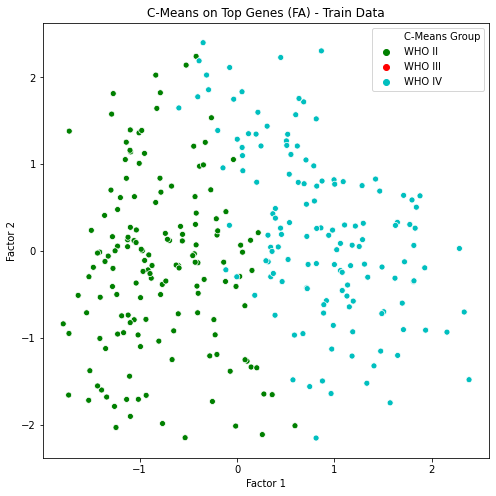

In [0]:
x = cmeans_train_top_fa['Factor 1']
y = cmeans_train_top_fa['Factor 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_train_top_fa['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on Top Genes (FA) - Train Data")
plt.show()

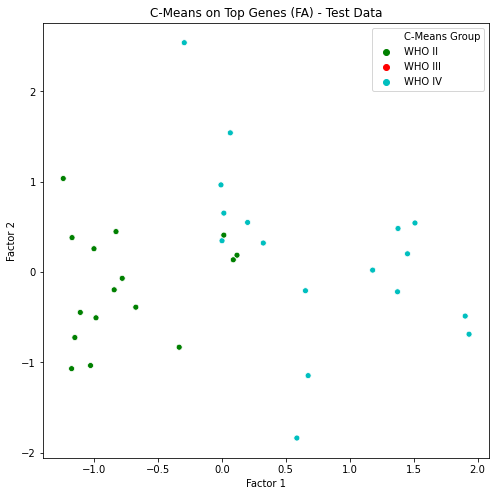

In [0]:
x = cmeans_test_top_fa['Factor 1']
y = cmeans_test_top_fa['Factor 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_test_top_fa['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on Top Genes (FA) - Test Data")
plt.show()

### Compare Clusters to Grades

#### Visually

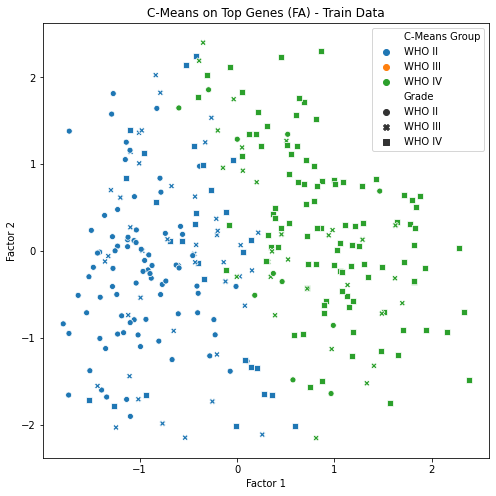

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'Factor 1', y = 'Factor 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train_top_fa)
plt.title("C-Means on Top Genes (FA) - Train Data")
plt.show()

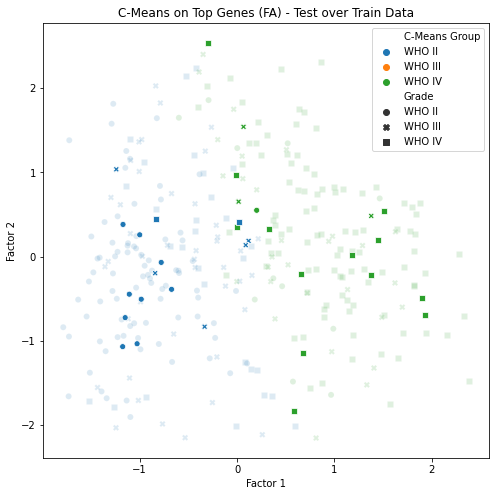

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'Factor 1', y = 'Factor 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train_top_fa, alpha = .15)
sb.scatterplot(x = 'Factor 1', y = 'Factor 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_test_top_fa, legend = False)
plt.title("C-Means on Top Genes (FA) - Test over Train Data")
plt.show()

#### Accuracy Score

In [0]:
get_accuracy(cmeans_train_top_fa['Grade'], cmeans_train_top_fa['C-Means Group'])

0.6198630136986302

In [0]:
get_accuracy(cmeans_test_top_fa['Grade'], cmeans_test_top_fa['C-Means Group'])

0.6666666666666666

## On n Sparse PCs

### Implement

In [0]:
centers_sparse, c_train_sparse, init, distance, idk, iterations, fpc_train = cmeans(sparse_train_genes.T, 
                                                                c = 3, m = 2, error=0.005, 
                                                                maxiter=1000, seed = 40)
c_test_sparse, init, distance, idk, iterations, fpc_test = cmeans_predict(sparse_test_genes.T,
                                                                   centers_sparse, m = 2, error = 0.005,
                                                                   maxiter = 1000, seed = 30)

In [0]:
clusters_train_sparse = pd.DataFrame(np.argmax(c_train_sparse, axis = 0))

cmeans_train_sparse = pd.concat([pd.DataFrame(sparse_train_genes), pd.DataFrame(clusters_train_sparse), pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, n+3)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_train_sparse.columns = col_titles

cmeans_train_sparse = cmeans_train_sparse.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

cmeans_train_sparse.head()

,PC 1,PC 2,C-Means Group,Grade
0,-36.592388,-3.616241,WHO II,WHO II
1,21.645254,8.726605,WHO IV,WHO IV
2,-32.763010,-18.839944,WHO II,WHO II
3,-7.433758,2.223518,WHO III,WHO II
4,-30.657532,-10.679793,WHO II,WHO II


In [0]:
clusters_test_sparse = pd.DataFrame(np.argmax(c_test_sparse, axis = 0))

cmeans_test_sparse = pd.concat([pd.DataFrame(sparse_test_genes), pd.DataFrame(clusters_test_sparse), 
                             pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, n+3)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_test_sparse.columns = col_titles

cmeans_test_sparse = cmeans_test_sparse.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

cmeans_test_sparse.head()

,PC 1,PC 2,C-Means Group,Grade
0,37.152352,-70.491281,WHO III,WHO IV
1,8.400580,7.307506,WHO III,WHO IV
2,-47.912547,-11.787691,WHO II,WHO II
3,-28.936388,-34.764760,WHO II,WHO II
4,-27.600268,-26.016465,WHO II,WHO II


### Plot Clusters

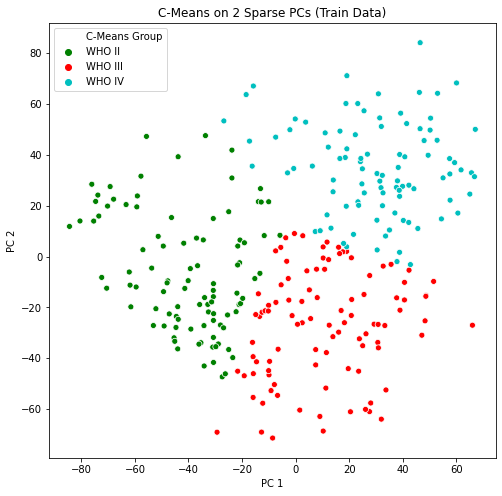

In [0]:
x = cmeans_train_sparse['PC 1']
y = cmeans_train_sparse['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_train_sparse['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on 2 Sparse PCs (Train Data)")
plt.show()

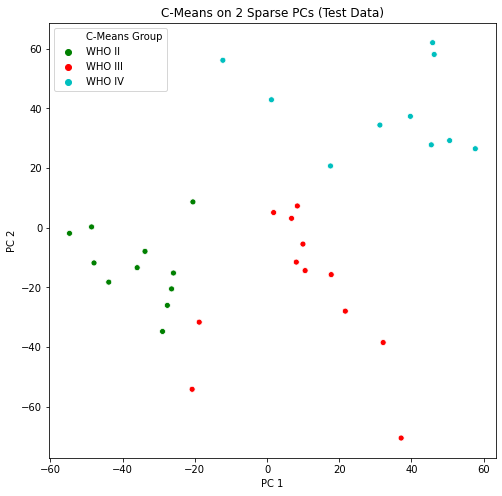

In [0]:
x = cmeans_test_sparse['PC 1']
y = cmeans_test_sparse['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_test_sparse['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on 2 Sparse PCs (Test Data)")
plt.show()

### Compare Clusters to Grades

#### Visually

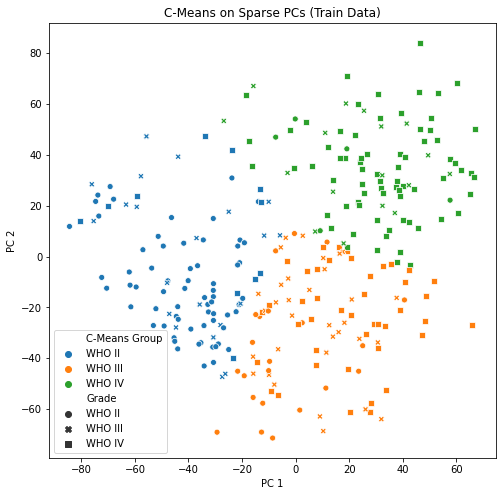

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train_sparse)
plt.title("C-Means on Sparse PCs (Train Data)")
plt.show()

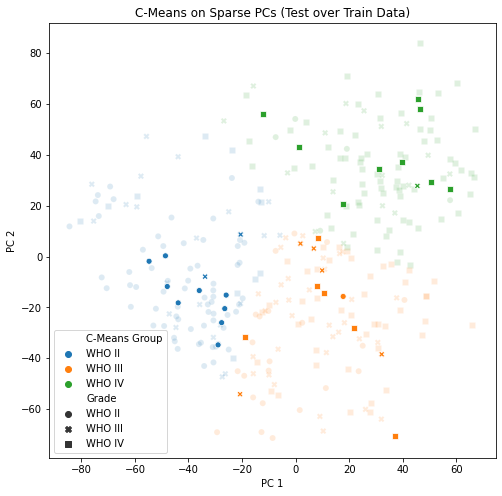

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train_sparse, alpha = .15)
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_test_sparse, legend = False)
plt.title("C-Means on Sparse PCs (Test over Train Data)")
plt.show()

#### Accuracy Score

In [0]:
get_accuracy(cmeans_train_sparse['Grade'], cmeans_train_sparse['C-Means Group'])

0.589041095890411

In [0]:
get_accuracy(cmeans_test_sparse['Grade'], cmeans_test_sparse['C-Means Group'])

0.696969696969697

## On important genes identified by Sparse PCA

### Implement

In [0]:
centers_top_sparse, c_train_top_sparse, init, distance, idk, iterations, fpc_train = cmeans(sparse_important_train.T, 
                                                                c = 3, m = 2, error=0.005, 
                                                                maxiter=1000, seed = 40)
c_test_top_sparse, init, distance, idk, iterations, fpc_test = cmeans_predict(sparse_important_test.T,
                                                                   centers_top_sparse, m = 2, error = 0.005,
                                                                   maxiter = 1000, seed = 30)

In [0]:
clusters_train_top_sparse = pd.DataFrame(np.argmax(c_train_top_sparse, axis = 0))

cmeans_train_top_sparse = pd.concat([pd.DataFrame(sparse_train_genes), 
                                     pd.DataFrame(clusters_train_top_sparse), 
                                     pd.DataFrame(train_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, n+3)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_train_top_sparse.columns = col_titles

cmeans_train_top_sparse = cmeans_train_top_sparse.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

cmeans_train_top_sparse.head()

,PC 1,PC 2,C-Means Group,Grade
0,-36.592388,-3.616241,WHO II,WHO II
1,21.645254,8.726605,WHO IV,WHO IV
2,-32.763010,-18.839944,WHO II,WHO II
3,-7.433758,2.223518,WHO III,WHO II
4,-30.657532,-10.679793,WHO II,WHO II


In [0]:
clusters_test_top_sparse = pd.DataFrame(np.argmax(c_test_top_sparse, axis = 0))

cmeans_test_top_sparse = pd.concat([pd.DataFrame(sparse_test_genes), pd.DataFrame(clusters_test_top_sparse), 
                                    pd.DataFrame(test_lbl)], axis = 1)

col_titles = [f'PC {x}' for x in range(1, n+3)]
col_titles[-2:] = ['C-Means Group', 'Grade']
cmeans_test_top_sparse.columns = col_titles

cmeans_test_top_sparse = cmeans_test_top_sparse.replace({'C-Means Group': {0:'WHO III', 2:'WHO IV', 1:'WHO II'}})

cmeans_test_top_sparse.head()

,PC 1,PC 2,C-Means Group,Grade
0,37.152352,-70.491281,WHO III,WHO IV
1,8.400580,7.307506,WHO IV,WHO IV
2,-47.912547,-11.787691,WHO II,WHO II
3,-28.936388,-34.764760,WHO III,WHO II
4,-27.600268,-26.016465,WHO III,WHO II


### Plot Clusters

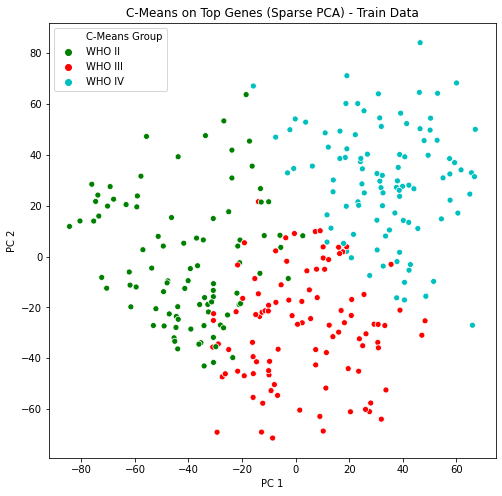

In [0]:
x = cmeans_train_top_sparse['PC 1']
y = cmeans_train_top_sparse['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_train_top_sparse['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on Top Genes (Sparse PCA) - Train Data")
plt.show()

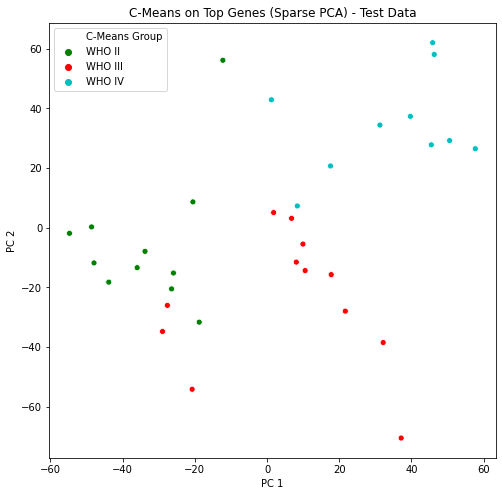

In [0]:
x = cmeans_test_top_sparse['PC 1']
y = cmeans_test_top_sparse['PC 2']
plt.figure(figsize = (8,8))

sb.scatterplot(x, y, hue = cmeans_test_top_sparse['C-Means Group'], palette = ['g', 'r', 'c'], 
               hue_order = ['WHO II', 'WHO III', 'WHO IV'])
plt.title("C-Means on Top Genes (Sparse PCA) - Test Data")
plt.show()

### Compare Clusters to Grades

#### Visually

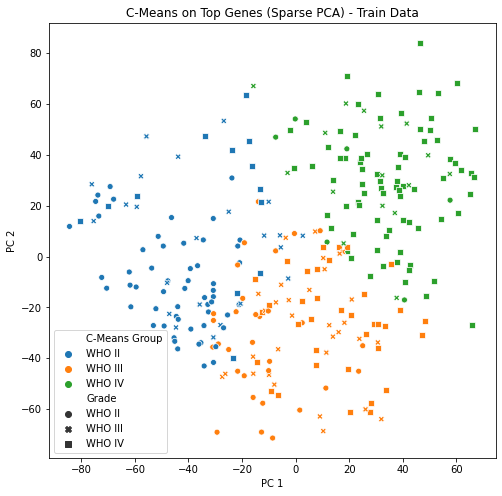

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train_top_sparse)
plt.title("C-Means on Top Genes (Sparse PCA) - Train Data")
plt.show()

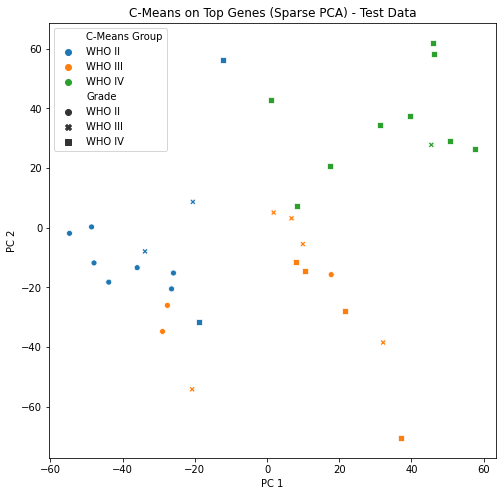

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_test_top_sparse)
plt.title("C-Means on Top Genes (Sparse PCA) - Test Data")
plt.show()

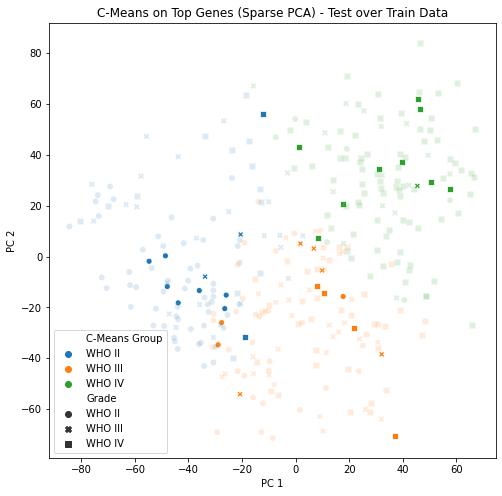

In [0]:
plt.figure(figsize = (8,8))
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_test_top_sparse)
sb.scatterplot(x = 'PC 1', y = 'PC 2', hue = 'C-Means Group',  hue_order = ['WHO II', 'WHO III', 'WHO IV'],
               style = 'Grade', style_order = ['WHO II', 'WHO III', 'WHO IV'],
               data = cmeans_train_top_sparse, alpha = .15, legend = False)
plt.title("C-Means on Top Genes (Sparse PCA) - Test over Train Data")
plt.show()

#### Accuracy Score

In [0]:
get_accuracy(cmeans_train_top_sparse['Grade'], cmeans_train_top_sparse['C-Means Group'])

0.571917808219178

In [0]:
get_accuracy(cmeans_test_top_sparse['Grade'], cmeans_test_top_sparse['C-Means Group'])

0.6363636363636364

# Investigating top genes

## Find common genes

In [0]:
fa_important_genes.shape

(2051,)

In [0]:
pca_important_genes = important_genes
pca_important_genes.shape

(3410,)

In [0]:
sparse_important_genes.shape

(200,)

In [0]:
lists = [fa_important_genes, pca_important_genes, sparse_important_genes]
all_top = []
for list in lists:
  all_top.extend(list)

all_top = np.asarray(all_top)
print(all_top.shape)

(5661,)


In [0]:
unique_all, counts_all = np.unique(all_top, return_counts = True)
for i, gene in enumerate(unique_all[:10]):
  print(f'\nGene {gene}: {counts_all[i]}')



Gene 10001: 1

Gene 10006: 1

Gene 10007: 1

Gene 10013: 2

Gene 10016: 1

Gene 10023: 1

Gene 10031: 1

Gene 10036: 1

Gene 10037: 1

Gene 10041: 1


In [0]:
once_all = []
twice_all = []
thrice_all = []
for i, gene in enumerate(unique_all):
  if counts_all[i] == 1:
    once_all.append(gene)
  elif counts_all[i] == 2:
    twice_all.append(gene)
  else:
    thrice_all.append(gene)


In [0]:
print('One time: ', len(once_all))
print('Two times: ', len(twice_all))
print('Three times: ', len(thrice_all))

One time:  3482
Two times:  1082
Three times:  5


## Retrieve gene names

In [0]:
all_genes = [int(i) for i in thrice_all]
print(np.sort(all_genes))

[ 1295  4082  7350 19766 22242]


In [0]:
gene_data = pd.read_csv('expression_data.csv')
clinical_data = pd.read_csv('clinical_data.csv')

In [0]:
gene_data.head()

,Gene_Name,CGGA_1001,CGGA_1006,CGGA_1007,CGGA_1011,CGGA_1015,CGGA_1019,CGGA_1022,CGGA_1023,CGGA_1024,CGGA_1026,CGGA_1034,CGGA_1035,CGGA_1039,CGGA_1045,CGGA_1049,CGGA_1052,CGGA_1072,CGGA_1077,CGGA_1078,CGGA_1079,CGGA_1081,CGGA_1083,CGGA_1091,CGGA_1109,CGGA_1124,CGGA_1139,CGGA_1140,CGGA_1145,CGGA_1171,CGGA_1177,CGGA_1180,CGGA_1188,CGGA_1214,CGGA_1216,CGGA_1218,CGGA_1224,CGGA_1234,CGGA_1237,CGGA_1240,...,CGGA_D39,CGGA_D40,CGGA_D45,CGGA_D46,CGGA_D47,CGGA_D48,CGGA_D52,CGGA_D56,CGGA_D59,CGGA_277,CGGA_518,CGGA_J023,CGGA_J024,CGGA_J042,CGGA_J100,CGGA_1004,CGGA_1008,CGGA_1053,CGGA_1059,CGGA_1070,CGGA_1071,CGGA_1073,CGGA_1074,CGGA_1095,CGGA_1099,CGGA_1114,CGGA_1116,CGGA_1118,CGGA_1119,CGGA_1197,CGGA_1246,CGGA_1275,CGGA_1450,CGGA_1460,CGGA_1475,CGGA_243,CGGA_247,CGGA_738,CGGA_759,CGGA_D30
0,A1BG,12.64,7.03,30.09,6.64,1.83,39.03,12.96,9.28,2.35,3.56,3.18,49.16,9.99,40.35,14.70,4.48,11.04,48.61,13.12,9.59,30.45,18.72,47.06,21.99,10.63,18.90,23.58,9.62,11.87,38.88,55.84,23.07,18.49,18.82,20.02,21.39,6.78,4.97,10.89,...,10.13,17.68,8.97,16.73,9.92,28.25,7.06,21.27,20.50,22.14,7.52,9.38,14.35,21.13,2.24,20.74,15.97,26.36,20.84,5.25,11.83,39.87,20.71,10.94,5.74,13.74,14.75,19.61,21.50,14.90,4.46,28.42,19.32,2.24,18.89,4.03,5.29,4.64,7.07,31.41
1,A1BG-AS1,2.12,1.13,6.64,4.32,1.39,4.46,3.25,1.90,1.22,1.56,0.56,7.75,1.61,9.49,5.02,1.85,2.73,5.59,4.37,2.07,3.78,3.99,5.55,4.27,1.15,2.71,5.00,0.88,2.97,6.18,9.10,1.90,4.85,4.01,5.10,3.61,1.31,0.98,2.95,...,2.99,2.69,2.38,4.89,2.56,3.82,1.03,2.51,2.86,5.46,2.62,1.62,2.14,3.48,0.73,2.23,4.52,2.61,4.16,1.62,1.04,6.93,2.88,2.20,2.41,5.29,1.41,3.19,1.97,2.00,1.57,8.36,2.21,1.60,5.31,2.47,3.69,0.85,1.99,2.65
2,A2M,452.92,106.54,206.70,707.17,824.32,155.14,538.33,26.39,219.35,302.00,139.67,143.45,79.09,202.67,345.41,117.38,126.56,412.72,170.82,136.63,345.27,763.49,235.32,60.24,561.11,61.97,56.12,483.18,614.56,422.29,151.96,67.55,76.20,78.47,234.72,484.48,903.16,134.09,508.32,...,70.55,67.67,115.30,173.03,182.86,116.36,69.12,183.79,248.62,119.77,51.07,94.13,177.72,255.94,125.46,277.46,260.36,298.05,145.93,256.82,214.55,249.91,452.45,276.66,194.31,384.38,174.69,108.87,65.29,78.92,87.20,243.89,73.80,111.50,340.53,108.06,97.24,160.70,263.66,192.54
3,A2M-AS1,3.30,0.13,0.63,1.61,1.34,3.08,0.72,1.96,1.48,0.91,0.40,0.31,0.13,0.40,0.35,0.44,0.37,1.17,0.31,0.24,0.81,2.25,1.41,0.29,0.89,0.60,0.84,0.84,1.44,0.83,1.32,2.07,0.20,0.36,0.93,2.55,0.96,0.63,0.44,...,0.16,0.19,0.27,0.20,0.36,0.38,0.25,0.25,0.38,0.34,0.03,0.19,0.31,0.55,0.11,0.94,0.41,1.90,0.51,1.28,0.41,1.06,3.69,2.32,0.85,1.11,0.38,0.65,0.12,0.15,0.42,1.02,0.22,0.15,0.91,0.33,0.03,0.38,0.48,2.51
4,A2ML1,0.04,0.33,4.96,1.59,0.00,0.10,0.39,2.34,0.68,2.84,0.96,0.13,2.44,2.94,1.06,0.84,0.60,0.25,4.57,7.31,0.18,0.73,0.04,9.13,1.01,5.71,0.69,2.28,1.60,0.00,1.38,0.67,1.25,2.69,0.52,0.34,0.21,1.99,0.48,...,0.51,1.25,1.68,0.38,1.38,0.33,1.10,0.26,1.27,1.04,0.61,0.10,4.07,0.81,0.96,1.04,2.93,0.79,3.33,0.43,0.10,1.02,2.09,3.03,2.74,2.41,3.34,2.40,0.14,0.69,2.58,0.55,0.15,1.75,0.05,1.55,0.71,3.33,0.60,3.86


In [0]:
gene_names = []
for i in all_genes:
  gene_names.append(gene_data.iloc[i, 0])

In [0]:
gene_names

['AIFM3', 'SERPINI1', 'TPPP3', 'CES4A', 'FBXO2']

## Look at specific genes across grades

See other notebook